In [10]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torchvision.transforms import autoaugment, InterpolationMode
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [11]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class RetainRandomStateSettings:
    def __init__(self, tolerance: float = 1e-2):
        self.retention = tolerance
        self.__last_loss = float('inf')
        self.__initial_epoch_rng_state = torch.get_rng_state()

    def step(self):
        pass

class TolerateLossEpochsPeriod(RetainRandomStateSettings):
    def __init__(self, tolerance: float = 1e-2):
        super().__init__(tolerance)
        self.step = self.__update_epoch_at_first

    def __update_epoch_normally(self, loss):
        super().step()
        if abs(self.__last_loss - loss) < self.retention:
            print(f'|{self.__last_loss} - {loss}| < {self.retention}')
            print('new rng')
            self.__initial_epoch_rng_state = torch.get_rng_state()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)

    def __update_epoch_at_first(self, loss):
        self.__initial_epoch_rng_state = torch.get_rng_state()
        self.step = self.__update_epoch_next
        
    def __update_epoch_next(self, loss):
        super().step()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)
        self.step = self.__update_epoch_normally

class MyDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None, augment_times=1, tolerance: float = 1e-2):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.augment_times = augment_times
        self.loss_tolerance = TolerateLossEpochsPeriod(tolerance)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.imgs[idx]
        target = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
            if not isinstance(img, Image.Image):
                raise TypeError(f"Image at index {idx} is of type {type(img)}, expected PIL Image.")
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def update_loss(self, loss):
        self.loss_tolerance.step(loss)


In [12]:
class ExceptableTrivialAugmentWide(autoaugment.TrivialAugmentWide):
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: InterpolationMode = InterpolationMode.NEAREST,
        fill = None,
        excepting = {}
    ) -> None:
        super().__init__(num_magnitude_bins,interpolation,fill)
        self.excepting = excepting

    def _augmentation_space(self, num_bins: int):
        result = super()._augmentation_space(num_bins)
        return {key: value for key, value in result.items() if key not in self.excepting}

In [13]:
num_classes = 5       # 输出的类别总数
patch_size = 16       # 对输入的图像进行切分的大小，表示切分后每个小块的大小
hidden_size = 512     # 隐藏层的维度大小
num_layers = 10       # 编码器中的层数
dropout_prob = 0.25    # Dropout操作的概率，用于防止过拟合
batch_size =128     # 批次大小
num_epochs = 50    # 训练轮数
learning_rate = 1e-4  # 学习率
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
import warnings


_BATCH_NORM_PARAMS = {
    'eps': 0.001,
    'momentum': 0.9997,
    'affine': True,
}


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k,
                                          int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def fixed_padding(inputs, kernel_size, rate=1):
    """Pads the input along the spatial dimensions independently of input size.
    
    Args:
        inputs: A tensor of size [batch, height_in, width_in, channels].
        kernel_size: The kernel to be used in the conv2d or max_pool2d 
            operation. Should be a positive integer.
        rate: An integer, rate for atrous convolution.
        
    Returns:
        padded_inputs: A tensor of size [batch, height_out, width_out, 
            channels] with the input, either intact (if kernel_size == 1) or 
            padded (if kernel_size > 1).
    """
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = torch.nn.functional.pad(
        inputs, pad=(pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(torch.nn.Module):
    """Strided 2-D separable convolution with 'SAME' padding."""
    
    def __init__(self, in_channels, out_channels, kernel_size=1, 
                 stride=1, groups=1, depth_multiplier=1, rate=1, use_explicit_padding=True, 
                 activation_func=None, **kwargs):
        """Constructor.
        
        If stride > 1 and use_explicit_padding is True, then we do explicit
        zero-padding, followed by conv2d with 'VALID' padding.
        
        Args:
            in_channels: An integer, the number of input filters.
            out_channels: An integer, the number of output filters.
            kernel_size: An integer with the kernel_size of the filters.
            depth_multiplier: The number of depthwise convolution output
                channels for each input channel. The total number of depthwise
                convolution output channels will be equal to `num_filters_in *
                depth_multiplier`.
            stride: An integer, the output stride.
            rate: An integer, rate for atrous convolution.
            use_explicit_padding: If True, use explicit padding to make the
                model fully compatible with the open source version, otherwise
                use the nattive Pytorch 'SAME' padding.
            activation_func: Activation function.
            **kwargs: Additional keyword arguments to pass to torch.nn.Conv2d.
        """
        super(SeparableConv2d, self).__init__()
        self.__kernel_size = kernel_size
        self.__rate = rate
        self.__without_padding = stride == 1 or not use_explicit_padding
        
        out_channels_depthwise = in_channels * depth_multiplier
        if self.__without_padding:
            # Separable convolution for padding 'SAME'
            # Here, we assume that floor(padding) = padding
            padding = (kernel_size - 1) * rate // 2
            self.conv_depthwise = torch.nn.Conv2d(in_channels, 
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride, 
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   padding=padding,
                                                   bias=False,
                                                   **kwargs)
        else:
            # Separable convolution for padding 'VALID'
            self.conv_depthwise = torch.nn.Conv2d(in_channels,
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride,
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   bias=False,
                                                   **kwargs)
        self.batch_norm_depthwise = torch.nn.BatchNorm2d(
            out_channels_depthwise, **_BATCH_NORM_PARAMS)
        self.conv_pointwise = torch.nn.Conv2d(out_channels_depthwise,
                                               out_channels,
                                               kernel_size=1, 
                                               stride=1,
                                               groups=groups,
                                               bias=False,
                                               **kwargs)
        self.batch_norm_pointwise = torch.nn.BatchNorm2d(
            out_channels, **_BATCH_NORM_PARAMS)
        self.activation_func = activation_func
    
    def forward(self, x):
        """
        Input: [batch, height_in, width_in, channels]
        Output: [batch, height_out, width_out, channels]
        """
        if not self.__without_padding:
            x = fixed_padding(x, self.__kernel_size, self.__rate)
        x = self.conv_depthwise(x)
        x = self.batch_norm_depthwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        x = self.conv_pointwise(x)
        x = self.batch_norm_pointwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        return x


class Focus(nn.Module):
    # Focus wh information into c-space
    # ch_in, ch_out, kernel, stride, padding, groups
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, n=1, act=True):
        super().__init__()
        self.n = n
        self.conv = None
        expected_in_channels = c1 * (4**n)
        if expected_in_channels != c2:
            self.conv = Conv(expected_in_channels, c2, k, s, p, g, act=act)

    def forward(self, x):  # x(b,c,w,h) -> y(b,c*4^n,w/2^n,h/2^n)
        for _ in range(self.n):
            x = torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2],
                          x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1)
        if self.conv is not None:
            x = self.conv(x)
        return x


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(
            k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(
            act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class SeparableBottleneck(nn.Module):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = SeparableConv2d(c_, c2, 3, 1, groups=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class SeparableC3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    # ch_in, ch_out, number, shortcut, groups, expansion
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = SeparableConv2d(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(
            *(SeparableBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            # suppress torch 1.9.0 max_pool2d() warning
            warnings.simplefilter('ignore')
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


class SingleEncoderModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super(SingleEncoderModule, self).__init__()
        layers: list[nn.Module] = []
        if has_leading_max_pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers += [
            Conv(in_channels, out_channels, 3, 1),
            #SeparableC3(out_channels, out_channels, n)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class SPPSingleEncoderModule(SingleEncoderModule):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super().__init__(in_channels, out_channels, n, has_leading_max_pool)
        layers = list(self.layers.children())
        layers.insert(len(layers)-1,SPPF(out_channels, out_channels))
        self.layers = nn.Sequential(*layers)

class ViTModule(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size, num_layers, num_heads, dropout_prob=0.3):
        super(ViTModule, self).__init__()
        self.channels_out = channels_out
        self.patch_embedding = None
        if channels_in != channels_out:
            self.patch_embedding = nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=patch_size, stride=patch_size),
                nn.BatchNorm2d(channels_out),
                nn.GELU(),
                nn.Conv2d(channels_out, channels_out,
                          kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(channels_out),
                nn.GELU()
            )

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=channels_out, nhead=num_heads, dropout=dropout_prob),
            num_layers=num_layers
        )

    def forward(self, x: torch.Tensor):
        if self.patch_embedding is not None:
            x = self.patch_embedding(x)
        b, _, w, h = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer_encoder(x)

        x = x.permute(1, 2, 0).reshape(b, self.channels_out, w, h)
        return x


class VTCNet(nn.Module):
    def __init__(self, num_classes: int = 1):
        super(VTCNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        # self.batch_norm = nn.BatchNorm2d(3)

        #self.focus = Focus(3, 12)
        self.vit = ViTModule(3, 1024, patch_size=16, num_layers=3, num_heads=8)

        self.encoders = nn.Sequential(
            SingleEncoderModule(3, 64, has_leading_max_pool=False),
            SingleEncoderModule(64, 128, 2),
            SingleEncoderModule(128, 256, 3),
            SingleEncoderModule(256, 512),
            SingleEncoderModule(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512+1024, num_classes, 1 , 1),
            nn.BatchNorm2d(num_classes),
            nn.GELU()
        )
        
        self.avg_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, *(x.shape[-3:]))
        # x = self.batch_norm(x)
        #x = self.focus(x)
        x = self.pool(x)
        encoded = self.encoders(x)
        x = self.vit(x)
        # x=encoded
        x = torch.concat([x, encoded], dim=1)
        del encoded
        x = self.classifier(x)
        x = self.avg_pool(x).flatten(2)
        x = x.squeeze(dim=2)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), path)

    def load_weights(self, path: str):
        self.load_state_dict(torch.load(path))


In [15]:
def initialize_weights(model):
    for m in model.modules():
        t = type(m)
        if t is nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif t is nn.BatchNorm2d:
            m.eps = 1e-3
            m.momentum = 0.03
        elif t in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True

In [16]:
import numpy as np
from collections.abc import Iterable
from numpy._typing import DTypeLike

def apply_from_axis(func, arr: np.ndarray, axis = 0, otypes: Iterable[DTypeLike] = ...):
    slices = (slice(None,None,None),)*(axis)
    if len(otypes) > 1:
        return tuple(np.array(item,dtype=otypes[i]) for i,item in enumerate(zip(*[func(arr[slices+(i,)]) for i in range(arr.shape[axis])])))
    else:
        return np.array([func(arr[slices+(i,)]) for i in range(arr.shape[axis])],otypes[0],copy=False)

np.apply_from_axis = apply_from_axis

Fold 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.9549503231048584
Train Acc (3077): 65.09587260318492%
------Weighted------
Weighted precision 0.6504829130036127
Weighted recall 0.6509587260318492
Weighted f1-score 0.6490129305027118
------Macro------
Macro precision 0.6513065177825724
Macro recall 0.6513185815683755
Macro f1-score 0.6496190252915016


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.7910096645355225
Val Acc (162): 35.18518518518518%
------Weighted------
Weighted precision 0.2000348503025879
Weighted recall 0.35185185185185186
Weighted f1-score 0.24807475221583236
------Macro------
Macro precision 0.20130405793056397
Macro recall 0.35210166177908114
Macro f1-score 0.24920979823199946
Training Loss: 0.9550, Training Accuracy: 65.10%
Validation Loss: 1.7910, Validation Accuracy: 35.19%
Epoch 2/50


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.670811767578125
Train Acc (3077): 76.86057848553786%
------Weighted------
Weighted precision 0.7690380065345161
Weighted recall 0.7686057848553787
Weighted f1-score 0.7670033899619796
------Macro------
Macro precision 0.7692579981589993
Macro recall 0.7691775763365523
Macro f1-score 0.7674045759054772


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.7166773080825806
Val Acc (162): 32.71604938271605%
------Weighted------
Weighted precision 0.13073825741450262
Weighted recall 0.3271604938271605
Weighted f1-score 0.18667146110511806
------Macro------
Macro precision 0.13189655172413794
Macro recall 0.32942326490713586
Macro f1-score 0.1882200647249191
Training Loss: 0.6708, Training Accuracy: 76.86%
Validation Loss: 1.7167, Validation Accuracy: 32.72%
Epoch 3/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.5414370068907738
Train Acc (3077): 81.96295092622684%
------Weighted------
Weighted precision 0.8200191608007781
Weighted recall 0.8196295092622684
Weighted f1-score 0.8187127279544593
------Macro------
Macro precision 0.8199572593745504
Macro recall 0.8200119878205042
Macro f1-score 0.8188745382303152


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.5078949332237244
Val Acc (162): 41.358024691358025%
------Weighted------
Weighted precision 0.3442261706150595
Weighted recall 0.41358024691358025
Weighted f1-score 0.31777385851459927
------Macro------
Macro precision 0.3481231231231231
Macro recall 0.4182978983382209
Macro f1-score 0.32126984126984126
Training Loss: 0.5414, Training Accuracy: 81.96%
Validation Loss: 1.5079, Validation Accuracy: 41.36%
Epoch 4/50


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.4100996917486191
Train Acc (3077): 87.09782255443614%
------Weighted------
Weighted precision 0.8707665737065785
Weighted recall 0.8709782255443614
Weighted f1-score 0.8704424841593053
------Macro------
Macro precision 0.8707632172075488
Macro recall 0.8712266200989534
Macro f1-score 0.8705679920325412


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Val Loss: 1.1265662908554077
Val Acc (162): 55.55555555555556%
------Weighted------
Weighted precision 0.6536183295442556
Weighted recall 0.5555555555555556
Weighted f1-score 0.5169946392955542
------Macro------
Macro precision 0.6531209531209531
Macro recall 0.5607710166177908
Macro f1-score 0.5196452162710804
Training Loss: 0.4101, Training Accuracy: 87.10%
Validation Loss: 1.1266, Validation Accuracy: 55.56%
Epoch 5/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.3160546188056469
Train Acc (3077): 91.22521936951576%
------Weighted------
Weighted precision 0.9122333577656374
Weighted recall 0.9122521936951576
Weighted f1-score 0.9120321499728363
------Macro------
Macro precision 0.9120931467906704
Macro recall 0.9123237634969736
Macro f1-score 0.9120001315594273


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.7852284610271454
Val Acc (162): 69.75308641975309%
------Weighted------
Weighted precision 0.7587452907237656
Weighted recall 0.6975308641975309
Weighted f1-score 0.6968132746868378
------Macro------
Macro precision 0.757240529744297
Macro recall 0.700745356793744
Macro f1-score 0.6973518839036081
Training Loss: 0.3161, Training Accuracy: 91.23%
Validation Loss: 0.7852, Validation Accuracy: 69.75%
Epoch 6/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.2309152053296566
Train Acc (3077): 94.70263243418914%
------Weighted------
Weighted precision 0.9469610190862608
Weighted recall 0.9470263243418915
Weighted f1-score 0.9469131496411463
------Macro------
Macro precision 0.9468069600839962
Macro recall 0.9470142923590636
Macro f1-score 0.9468310553724445


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.4895929992198944
Val Acc (162): 83.95061728395062%
------Weighted------
Weighted precision 0.8667601814952298
Weighted recall 0.8395061728395061
Weighted f1-score 0.8429436397182195
------Macro------
Macro precision 0.864823253332945
Macro recall 0.8410984848484848
Macro f1-score 0.8424768617552265
Training Loss: 0.2309, Training Accuracy: 94.70%
Validation Loss: 0.4896, Validation Accuracy: 83.95%
Epoch 7/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.18695959612727164
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9586779998648134
Weighted recall 0.9587260318492038
Weighted f1-score 0.9586205008796597
------Macro------
Macro precision 0.9585762514296245
Macro recall 0.9587481237254878
Macro f1-score 0.9585817401470379


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Val Loss: 0.3903491050004959
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8875989161646064
Weighted recall 0.8827160493827161
Weighted f1-score 0.8831950533469285
------Macro------
Macro precision 0.8869334533961897
Macro recall 0.8833211143695016
Macro f1-score 0.883158650216855
Training Loss: 0.1870, Training Accuracy: 95.87%
Validation Loss: 0.3903, Validation Accuracy: 88.27%
|0.2309152053296566 - 0.18695959612727164| < 0.07
new rng
Epoch 8/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.48502551913261416
Train Acc (3077): 83.13292167695808%
------Weighted------
Weighted precision 0.8309485104663057
Weighted recall 0.8313292167695807
Weighted f1-score 0.8306438388280518
------Macro------
Macro precision 0.8313297954437623
Macro recall 0.8319250217645633
Macro f1-score 0.8311403582623896


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Val Loss: 0.32892780005931854
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8779721658778453
Weighted recall 0.8765432098765432
Weighted f1-score 0.8762717073671263
------Macro------
Macro precision 0.8777844366586761
Macro recall 0.8770466764418379
Macro f1-score 0.8764398924244855
Training Loss: 0.4850, Training Accuracy: 83.13%
Validation Loss: 0.3289, Validation Accuracy: 87.65%
Epoch 9/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.3664704298973083
Train Acc (3077): 88.52778680532987%
------Weighted------
Weighted precision 0.8852538528679975
Weighted recall 0.8852778680532987
Weighted f1-score 0.8846557295362864
------Macro------
Macro precision 0.8852600109486002
Macro recall 0.8856247687663533
Macro f1-score 0.884840197841716


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.40759776532649994
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8558372934922405
Weighted recall 0.845679012345679
Weighted f1-score 0.8433908058497602
------Macro------
Macro precision 0.8552773010176662
Macro recall 0.8473240469208212
Macro f1-score 0.8439939173018896
Training Loss: 0.3665, Training Accuracy: 88.53%
Validation Loss: 0.4076, Validation Accuracy: 84.57%
Epoch 10/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.25888786390423774
Train Acc (3077): 92.55768605784856%
------Weighted------
Weighted precision 0.9257965244477492
Weighted recall 0.9255768605784855
Weighted f1-score 0.925447806062612
------Macro------
Macro precision 0.9256552577726593
Macro recall 0.9256295065353308
Macro f1-score 0.9254052785702707


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.3253125995397568
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9179012345679013
Weighted recall 0.9135802469135802
Weighted f1-score 0.9141542670671221
------Macro------
Macro precision 0.9169696969696972
Macro recall 0.9140029325513197
Macro f1-score 0.9138621930148171
Training Loss: 0.2589, Training Accuracy: 92.56%
Validation Loss: 0.3253, Validation Accuracy: 91.36%
Epoch 11/50


100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


Train Loss: 0.18914807930588723
Train Acc (3077): 95.32011699707508%
------Weighted------
Weighted precision 0.9534202477459076
Weighted recall 0.9532011699707508
Weighted f1-score 0.953125756116664
------Macro------
Macro precision 0.9531352418550139
Macro recall 0.9532589677374712
Macro f1-score 0.9530139382347759


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Val Loss: 0.31036408245563507
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9178229749217404
Weighted recall 0.9074074074074074
Weighted f1-score 0.9079327388588011
------Macro------
Macro precision 0.9163817663817664
Macro recall 0.9077651515151516
Macro f1-score 0.9072969084465031
Training Loss: 0.1891, Training Accuracy: 95.32%
Validation Loss: 0.3104, Validation Accuracy: 90.74%
|0.25888786390423774 - 0.18914807930588723| < 0.07
new rng
Epoch 12/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.369799011349678
Train Acc (3077): 88.78778030549236%
------Weighted------
Weighted precision 0.8879303230806539
Weighted recall 0.8878778030549236
Weighted f1-score 0.887822430904794
------Macro------
Macro precision 0.8878205629234603
Macro recall 0.8881000723876659
Macro f1-score 0.8878791511551878


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Val Loss: 0.21981839835643768
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9123332086295048
Weighted recall 0.9074074074074074
Weighted f1-score 0.9073325163398692
------Macro------
Macro precision 0.9112794612794612
Macro recall 0.9077407135874879
Macro f1-score 0.9069897504456328
Training Loss: 0.3698, Training Accuracy: 88.79%
Validation Loss: 0.2198, Validation Accuracy: 90.74%
Epoch 13/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.2366328376531601
Train Acc (3077): 94.76763080922977%
------Weighted------
Weighted precision 0.9475510292520108
Weighted recall 0.9476763080922977
Weighted f1-score 0.9475069424898405
------Macro------
Macro precision 0.9474372522667363
Macro recall 0.9477968680830273
Macro f1-score 0.9475107776545698


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.27671003341674805
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9258721518367312
Weighted recall 0.9259259259259259
Weighted f1-score 0.9256307050927698
------Macro------
Macro precision 0.9258869530216778
Macro recall 0.9261119257086999
Macro f1-score 0.9257346599396431
Training Loss: 0.2366, Training Accuracy: 94.77%
Validation Loss: 0.2767, Validation Accuracy: 92.59%
Epoch 14/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.31638336896896363
Train Acc (3077): 91.16022099447514%
------Weighted------
Weighted precision 0.910913986692571
Weighted recall 0.9116022099447514
Weighted f1-score 0.9107526556996192
------Macro------
Macro precision 0.9107868564198125
Macro recall 0.9109737152197862
Macro f1-score 0.9103670959908492


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Val Loss: 0.28042440116405487
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.938002532446977
Weighted recall 0.9320987654320988
Weighted f1-score 0.9324145642932683
------Macro------
Macro precision 0.9380419580419581
Macro recall 0.9329423264907136
Macro f1-score 0.9328471574604109
Training Loss: 0.3164, Training Accuracy: 91.16%
Validation Loss: 0.2804, Validation Accuracy: 93.21%
Epoch 15/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.20399637877941132
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.9504935052975954
Weighted recall 0.9506012349691257
Weighted f1-score 0.9504702345711264
------Macro------
Macro precision 0.9502854308898001
Macro recall 0.9505910405356822
Macro f1-score 0.9503619066808181


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Val Loss: 0.25761697441339493
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9274544943425399
Weighted recall 0.9259259259259259
Weighted f1-score 0.9260994192707155
------Macro------
Macro precision 0.9265999654993962
Macro recall 0.9259225317693061
Macro f1-score 0.9256567044067043
Training Loss: 0.2040, Training Accuracy: 95.06%
Validation Loss: 0.2576, Validation Accuracy: 92.59%
Epoch 16/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.1434536674618721
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9737637139117603
Weighted recall 0.9736756581085473
Weighted f1-score 0.973564464866624
------Macro------
Macro precision 0.9735793614012168
Macro recall 0.973791631132206
Macro f1-score 0.9735317052537669


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.27518267184495926
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9126128058435851
Weighted recall 0.9074074074074074
Weighted f1-score 0.907042638905066
------Macro------
Macro precision 0.911000479139024
Macro recall 0.9073741446725319
Macro f1-score 0.9061416440650705
Training Loss: 0.1435, Training Accuracy: 97.37%
Validation Loss: 0.2752, Validation Accuracy: 90.74%
|0.20399637877941132 - 0.1434536674618721| < 0.07
new rng
Epoch 17/50


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.25363953292369845
Train Acc (3077): 92.23269418264543%
------Weighted------
Weighted precision 0.9221776783958979
Weighted recall 0.9223269418264544
Weighted f1-score 0.9221503051681855
------Macro------
Macro precision 0.9220721838258733
Macro recall 0.9225006235613122
Macro f1-score 0.9221851727805215


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.15996883809566498
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9520489677352422
Weighted recall 0.9506172839506173
Weighted f1-score 0.950680382711404
------Macro------
Macro precision 0.9525420168067227
Macro recall 0.9511363636363637
Macro f1-score 0.9511983151469543
Training Loss: 0.2536, Training Accuracy: 92.23%
Validation Loss: 0.1600, Validation Accuracy: 95.06%
Epoch 18/50


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.22188552975654602
Train Acc (3077): 94.08514787130322%
------Weighted------
Weighted precision 0.9408226166968465
Weighted recall 0.9408514787130322
Weighted f1-score 0.940808153394092
------Macro------
Macro precision 0.940837145762315
Macro recall 0.9409674038300159
Macro f1-score 0.94087298349317


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.16444098204374313
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9416868393447914
Weighted recall 0.9382716049382716
Weighted f1-score 0.9380772720087077
------Macro------
Macro precision 0.9410635769459299
Macro recall 0.9388257575757576
Macro f1-score 0.9380005091284758
Training Loss: 0.2219, Training Accuracy: 94.09%
Validation Loss: 0.1644, Validation Accuracy: 93.83%
|0.25363953292369845 - 0.22188552975654602| < 0.07
new rng
Epoch 19/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.3013627701997757
Train Acc (3077): 92.1351966200845%
------Weighted------
Weighted precision 0.9209542943428124
Weighted recall 0.921351966200845
Weighted f1-score 0.9208684758669141
------Macro------
Macro precision 0.920969517000804
Macro recall 0.9215920280717361
Macro f1-score 0.9209986867725132


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Val Loss: 0.18137352913618088
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9173390122805368
Weighted recall 0.9135802469135802
Weighted f1-score 0.9127925723781773
------Macro------
Macro precision 0.9173631313995607
Macro recall 0.9147605083088954
Macro f1-score 0.9133896305874952
Training Loss: 0.3014, Training Accuracy: 92.14%
Validation Loss: 0.1814, Validation Accuracy: 91.36%
Epoch 20/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.31058306992053986
Train Acc (3077): 91.25771855703607%
------Weighted------
Weighted precision 0.91256762830084
Weighted recall 0.9125771855703607
Weighted f1-score 0.9123989840166927
------Macro------
Macro precision 0.912498949489614
Macro recall 0.9125372783749672
Macro f1-score 0.9123459497179855


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.18616696447134018
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9442016158315178
Weighted recall 0.9444444444444444
Weighted f1-score 0.9426772278678504
------Macro------
Macro precision 0.9443178635090399
Macro recall 0.9454545454545455
Macro f1-score 0.9432556894754105
Training Loss: 0.3106, Training Accuracy: 91.26%
Validation Loss: 0.1862, Validation Accuracy: 94.44%
|0.3013627701997757 - 0.31058306992053986| < 0.07
new rng
Epoch 21/50


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.28842124342918396
Train Acc (3077): 91.51771205719857%
------Weighted------
Weighted precision 0.9148880889290161
Weighted recall 0.9151771205719857
Weighted f1-score 0.9147778201281387
------Macro------
Macro precision 0.9148799047924336
Macro recall 0.9153073646523652
Macro f1-score 0.9148376276189826


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.1814209595322609
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.937814780925161
Weighted recall 0.9320987654320988
Weighted f1-score 0.9309699500907129
------Macro------
Macro precision 0.9370943749233224
Macro recall 0.9331439393939395
Macro f1-score 0.9311536133358167
Training Loss: 0.2884, Training Accuracy: 91.52%
Validation Loss: 0.1814, Validation Accuracy: 93.21%
|0.31058306992053986 - 0.28842124342918396| < 0.07
new rng
Epoch 22/50


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.2731101304292679
Train Acc (3077): 92.03769905752357%
------Weighted------
Weighted precision 0.9199568189113535
Weighted recall 0.9203769905752356
Weighted f1-score 0.9200127891684906
------Macro------
Macro precision 0.9199090375964539
Macro recall 0.9204982207430028
Macro f1-score 0.920048919846766


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Val Loss: 0.11528271250426769
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.951320806100218
Weighted recall 0.9506172839506173
Weighted f1-score 0.9505151013252864
------Macro------
Macro precision 0.9512923351158644
Macro recall 0.9513257575757577
Macro f1-score 0.950855117105117
Training Loss: 0.2731, Training Accuracy: 92.04%
Validation Loss: 0.1153, Validation Accuracy: 95.06%
|0.28842124342918396 - 0.2731101304292679| < 0.07
new rng
Epoch 23/50


100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


Train Loss: 0.24242612600326538
Train Acc (3077): 92.62268443288917%
------Weighted------
Weighted precision 0.9263545651154911
Weighted recall 0.9262268443288918
Weighted f1-score 0.9262602244837882
------Macro------
Macro precision 0.9263452051977497
Macro recall 0.9263125697852586
Macro f1-score 0.9262979425126939


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.1384020783007145
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575809296239405
Weighted recall 0.9567901234567902
Weighted f1-score 0.9564850707177268
------Macro------
Macro precision 0.9574539170506913
Macro recall 0.9575757575757576
Macro f1-score 0.9568124806371076
Training Loss: 0.2424, Training Accuracy: 92.62%
Validation Loss: 0.1384, Validation Accuracy: 95.68%
|0.2731101304292679 - 0.24242612600326538| < 0.07
new rng
Epoch 24/50


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.2589679145812988
Train Acc (3077): 92.55768605784856%
------Weighted------
Weighted precision 0.9257353876307526
Weighted recall 0.9255768605784855
Weighted f1-score 0.9255683232372722
------Macro------
Macro precision 0.9256371868674217
Macro recall 0.9258410510878982
Macro f1-score 0.9256513795068969


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.17535686492919922
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9587371122616044
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567447349310095
------Macro------
Macro precision 0.95881394591072
Macro recall 0.9575757575757576
Macro f1-score 0.9571746880570411
Training Loss: 0.2590, Training Accuracy: 92.56%
Validation Loss: 0.1754, Validation Accuracy: 95.68%
|0.24242612600326538 - 0.2589679145812988| < 0.07
new rng
Epoch 25/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.2545686614513397
Train Acc (3077): 92.52518687032824%
------Weighted------
Weighted precision 0.9250706035608839
Weighted recall 0.9252518687032825
Weighted f1-score 0.9249952990854855
------Macro------
Macro precision 0.9250774168419639
Macro recall 0.925579736691337
Macro f1-score 0.9251641710501591


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.16592898219823837
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9464800510552144
Weighted recall 0.9444444444444444
Weighted f1-score 0.9447088238599433
------Macro------
Macro precision 0.9461675579322637
Macro recall 0.9450757575757576
Macro f1-score 0.9448691296265922
Training Loss: 0.2546, Training Accuracy: 92.53%
Validation Loss: 0.1659, Validation Accuracy: 94.44%
|0.2589679145812988 - 0.2545686614513397| < 0.07
new rng
Epoch 26/50


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.2618840646743774
Train Acc (3077): 92.65518362040949%
------Weighted------
Weighted precision 0.9265576889441272
Weighted recall 0.9265518362040949
Weighted f1-score 0.9264950780051726
------Macro------
Macro precision 0.9265028344475621
Macro recall 0.9267573843427414
Macro f1-score 0.9265708570846127


100%|██████████| 2/2 [00:00<00:00,  7.16it/s]


Val Loss: 0.2076396346092224
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.951320806100218
Weighted recall 0.9506172839506173
Weighted f1-score 0.9505151013252864
------Macro------
Macro precision 0.9512923351158644
Macro recall 0.9513257575757577
Macro f1-score 0.950855117105117
Training Loss: 0.2619, Training Accuracy: 92.66%
Validation Loss: 0.2076, Validation Accuracy: 95.06%
|0.2545686614513397 - 0.2618840646743774| < 0.07
new rng
Epoch 27/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.2371472531557083
Train Acc (3077): 93.17517062073448%
------Weighted------
Weighted precision 0.93234912261135
Weighted recall 0.9317517062073448
Weighted f1-score 0.9317874872979461
------Macro------
Macro precision 0.9320113648141023
Macro recall 0.9319495362038982
Macro f1-score 0.9317195565931508


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.2036789506673813
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.95112790486565
Weighted recall 0.9506172839506173
Weighted f1-score 0.9505180690365876
------Macro------
Macro precision 0.9511029411764707
Macro recall 0.9513257575757577
Macro f1-score 0.9508580308580308
Training Loss: 0.2371, Training Accuracy: 93.18%
Validation Loss: 0.2037, Validation Accuracy: 95.06%
|0.2618840646743774 - 0.2371472531557083| < 0.07
new rng
Epoch 28/50


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.28471068739891053
Train Acc (3077): 92.20019499512512%
------Weighted------
Weighted precision 0.9222242941248515
Weighted recall 0.9220019499512512
Weighted f1-score 0.9217875689404147
------Macro------
Macro precision 0.9223425411688441
Macro recall 0.9222094735580437
Macro f1-score 0.9219567137139089


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.165118046104908
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9579843645941053
Weighted recall 0.9567901234567902
Weighted f1-score 0.9569429965493967
------Macro------
Macro precision 0.9583572783952292
Macro recall 0.9570075757575758
Macro f1-score 0.9572448506765892
Training Loss: 0.2847, Training Accuracy: 92.20%
Validation Loss: 0.1651, Validation Accuracy: 95.68%
|0.2371472531557083 - 0.28471068739891053| < 0.07
new rng
Epoch 29/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.20633187025785446
Train Acc (3077): 94.54013649658758%
------Weighted------
Weighted precision 0.9454423984590788
Weighted recall 0.9454013649658759
Weighted f1-score 0.9453364844649913
------Macro------
Macro precision 0.9453198824552951
Macro recall 0.9456238086941731
Macro f1-score 0.9453855226806487


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Val Loss: 0.11492778360843658
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9639168822062669
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627947355618066
------Macro------
Macro precision 0.9643639524775427
Macro recall 0.9628787878787879
Macro f1-score 0.9629744239266541
Training Loss: 0.2063, Training Accuracy: 94.54%
Validation Loss: 0.1149, Validation Accuracy: 96.30%
Epoch 30/50


100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


Train Loss: 0.14562434881925582
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9656799927740588
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654906879474807
------Macro------
Macro precision 0.9655221386093341
Macro recall 0.9656022170466606
Macro f1-score 0.9654387246668437


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.09723230451345444
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694813409234662
Weighted recall 0.9691358024691358
Weighted f1-score 0.969219159932261
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.9693181818181819
Macro f1-score 0.969490211281256
Training Loss: 0.1456, Training Accuracy: 96.56%
Validation Loss: 0.0972, Validation Accuracy: 96.91%
|0.20633187025785446 - 0.14562434881925582| < 0.07
new rng
Epoch 31/50


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.18892106533050537
Train Acc (3077): 94.93012674683133%
------Weighted------
Weighted precision 0.9491858496985207
Weighted recall 0.9493012674683133
Weighted f1-score 0.9491802236956264
------Macro------
Macro precision 0.9491435384660452
Macro recall 0.9493909899992662
Macro f1-score 0.9492048091008062


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Val Loss: 0.08921084180474281
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631262596092346
Weighted recall 0.9629629629629629
Weighted f1-score 0.9627714749242526
------Macro------
Macro precision 0.962866568914956
Macro recall 0.9632575757575758
Macro f1-score 0.962780969030969
Training Loss: 0.1889, Training Accuracy: 94.93%
Validation Loss: 0.0892, Validation Accuracy: 96.30%
|0.14562434881925582 - 0.18892106533050537| < 0.07
new rng
Epoch 32/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.15658239156007767
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9587203362853493
Weighted recall 0.9587260318492038
Weighted f1-score 0.9586544645430268
------Macro------
Macro precision 0.9586719400361463
Macro recall 0.9588730695293833
Macro f1-score 0.9587044216038201


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.09832849726080894
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9578028104909826
Weighted recall 0.9567901234567902
Weighted f1-score 0.9570423484366839
------Macro------
Macro precision 0.9581790252757993
Macro recall 0.9570075757575758
Macro f1-score 0.9573423961659255
Training Loss: 0.1566, Training Accuracy: 95.87%
Validation Loss: 0.0983, Validation Accuracy: 95.68%
|0.18892106533050537 - 0.15658239156007767| < 0.07
new rng
Epoch 33/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.17058752179145814
Train Acc (3077): 95.28761780955476%
------Weighted------
Weighted precision 0.9529402593887165
Weighted recall 0.9528761780955476
Weighted f1-score 0.9528874997993027
------Macro------
Macro precision 0.953024892097632
Macro recall 0.9528966948143041
Macro f1-score 0.952940138780048


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.11684440448880196
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9513435003631082
Weighted recall 0.9506172839506173
Weighted f1-score 0.9508922623350484
------Macro------
Macro precision 0.951659982174688
Macro recall 0.9509469696969697
Macro f1-score 0.9512169484744112
Training Loss: 0.1706, Training Accuracy: 95.29%
Validation Loss: 0.1168, Validation Accuracy: 95.06%
|0.15658239156007767 - 0.17058752179145814| < 0.07
new rng
Epoch 34/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.1584843733906746
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9593283360217695
Weighted recall 0.95937601559961
Weighted f1-score 0.95932068040511
------Macro------
Macro precision 0.9593878548627603
Macro recall 0.959560032436908
Macro f1-score 0.9594424914729963


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.1004418432712555
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9572758538899432
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565870386472238
------Macro------
Macro precision 0.9571391093094128
Macro recall 0.9573863636363636
Macro f1-score 0.9568166555666556
Training Loss: 0.1585, Training Accuracy: 95.94%
Validation Loss: 0.1004, Validation Accuracy: 95.68%
|0.17058752179145814 - 0.1584843733906746| < 0.07
new rng
Epoch 35/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.19508475661277772
Train Acc (3077): 95.58011049723757%
------Weighted------
Weighted precision 0.9557167918456517
Weighted recall 0.9558011049723757
Weighted f1-score 0.9556858698408598
------Macro------
Macro precision 0.9556611565163365
Macro recall 0.9559405937614146
Macro f1-score 0.9557282296979416


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Val Loss: 0.12007777392864227
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9572758538899432
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565870386472238
------Macro------
Macro precision 0.9571391093094128
Macro recall 0.9573863636363636
Macro f1-score 0.9568166555666556
Training Loss: 0.1951, Training Accuracy: 95.58%
Validation Loss: 0.1201, Validation Accuracy: 95.68%
|0.1584843733906746 - 0.19508475661277772| < 0.07
new rng
Epoch 36/50


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.18049701452255248
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9573391200522746
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573515163097968
------Macro------
Macro precision 0.9572582557125446
Macro recall 0.9574381953919481
Macro f1-score 0.9573175022403758


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.09956659935414791
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9446373456790124
Weighted recall 0.9444444444444444
Weighted f1-score 0.9444459518533592
------Macro------
Macro precision 0.9446969696969697
Macro recall 0.9448863636363637
Macro f1-score 0.9446954434454435
Training Loss: 0.1805, Training Accuracy: 95.74%
Validation Loss: 0.0996, Validation Accuracy: 94.44%
|0.19508475661277772 - 0.18049701452255248| < 0.07
new rng
Epoch 37/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.18684696167707443
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9546479577780498
Weighted recall 0.9545011374715632
Weighted f1-score 0.954279278472064
------Macro------
Macro precision 0.9544241975937469
Macro recall 0.9547267044774808
Macro f1-score 0.9542828756791117


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Val Loss: 0.09426287189126015
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9638094589687728
Weighted recall 0.9629629629629629
Weighted f1-score 0.9626497859775913
------Macro------
Macro precision 0.9635539215686275
Macro recall 0.9634469696969697
Macro f1-score 0.9627691711273801
Training Loss: 0.1868, Training Accuracy: 95.45%
Validation Loss: 0.0943, Validation Accuracy: 96.30%
|0.18049701452255248 - 0.18684696167707443| < 0.07
new rng
Epoch 38/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.14214704871177675
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9625384778679006
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625652865514482
------Macro------
Macro precision 0.9625717287277542
Macro recall 0.9627305787632972
Macro f1-score 0.9626344223482052


100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Val Loss: 0.09712588042020798
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636664851125636
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630521741632853
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9633566433566433
Training Loss: 0.1421, Training Accuracy: 96.26%
Validation Loss: 0.0971, Validation Accuracy: 96.30%
|0.18684696167707443 - 0.14214704871177675| < 0.07
new rng
Epoch 39/50


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.1758158215880394
Train Acc (3077): 95.58011049723757%
------Weighted------
Weighted precision 0.9558141723891027
Weighted recall 0.9558011049723757
Weighted f1-score 0.9557323475445753
------Macro------
Macro precision 0.955652890653187
Macro recall 0.9559081936591713
Macro f1-score 0.9557056989883008


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.09139133244752884
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636664851125636
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630521741632853
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9633566433566433
Training Loss: 0.1758, Training Accuracy: 95.58%
Validation Loss: 0.0914, Validation Accuracy: 96.30%
|0.14214704871177675 - 0.1758158215880394| < 0.07
new rng
Epoch 40/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.1666019657254219
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.957034662599231
Weighted recall 0.9571010724731882
Weighted f1-score 0.9570530984753796
------Macro------
Macro precision 0.9570786781056487
Macro recall 0.9572157891481394
Macro f1-score 0.9571325165706115


100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


Val Loss: 0.09529805183410645
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9691241114852226
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690408357075023
------Macro------
Macro precision 0.9693181818181819
Macro recall 0.9695075757575757
Macro f1-score 0.9693240093240092
Training Loss: 0.1666, Training Accuracy: 95.71%
Validation Loss: 0.0953, Validation Accuracy: 96.91%
|0.1758158215880394 - 0.1666019657254219| < 0.07
new rng
Epoch 41/50


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.1589944064617157
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.959750325603106
Weighted recall 0.9597010074748131
Weighted f1-score 0.9597006009042501
------Macro------
Macro precision 0.9597298482466854
Macro recall 0.9597095922447749
Macro f1-score 0.9596946331302384


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Val Loss: 0.13619637116789818
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636664851125636
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630521741632853
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9633566433566433
Training Loss: 0.1590, Training Accuracy: 95.97%
Validation Loss: 0.1362, Validation Accuracy: 96.30%
|0.1666019657254219 - 0.1589944064617157| < 0.07
new rng
Epoch 42/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.18096273362636567
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9597679891905925
Weighted recall 0.9597010074748131
Weighted f1-score 0.9595331307147308
------Macro------
Macro precision 0.959672620595476
Macro recall 0.9598815574366586
Macro f1-score 0.9595780087954215


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Val Loss: 0.12402193248271942
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636664851125636
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630521741632853
------Macro------
Macro precision 0.9637923351158644
Macro recall 0.9634469696969697
Macro f1-score 0.9633566433566433
Training Loss: 0.1810, Training Accuracy: 95.97%
Validation Loss: 0.1240, Validation Accuracy: 96.30%
|0.1589944064617157 - 0.18096273362636567| < 0.07
new rng
Epoch 43/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.1581414207816124
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9606466933439165
Weighted recall 0.9606759831004225
Weighted f1-score 0.9606376132551295
------Macro------
Macro precision 0.9605948470264177
Macro recall 0.9607029769349673
Macro f1-score 0.9606246514382972


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.09983853995800018
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9570829526553752
Weighted recall 0.9567901234567902
Weighted f1-score 0.956585531238309
------Macro------
Macro precision 0.9573285032488069
Macro recall 0.9573863636363636
Macro f1-score 0.9570075757575758
Training Loss: 0.1581, Training Accuracy: 96.07%
Validation Loss: 0.0998, Validation Accuracy: 95.68%
|0.18096273362636567 - 0.1581414207816124| < 0.07
new rng
Epoch 44/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.1626664474606514
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9614123408203468
Weighted recall 0.9613259668508287
Weighted f1-score 0.9612354192418409
------Macro------
Macro precision 0.9613023921082762
Macro recall 0.9614997648764174
Macro f1-score 0.9612686952611227


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.08620061352849007
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9756827534605312
Weighted recall 0.9753086419753086
Weighted f1-score 0.9754036087369421
------Macro------
Macro precision 0.9757575757575758
Macro recall 0.9755681818181818
Macro f1-score 0.9755710955710957
Training Loss: 0.1627, Training Accuracy: 96.13%
Validation Loss: 0.0862, Validation Accuracy: 97.53%
|0.1581414207816124 - 0.1626664474606514| < 0.07
new rng
Epoch 45/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.15972544699907304
Train Acc (3077): 95.9051023724407%
------Weighted------
Weighted precision 0.9589943248268248
Weighted recall 0.9590510237244069
Weighted f1-score 0.9589579540156267
------Macro------
Macro precision 0.9589047869273738
Macro recall 0.959149223757097
Macro f1-score 0.9589627842348275


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Val Loss: 0.13774316757917404
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9324913238891734
Weighted recall 0.9320987654320988
Weighted f1-score 0.9312788880441211
------Macro------
Macro precision 0.9317274123725736
Macro recall 0.9323863636363636
Macro f1-score 0.9310117302052786
Training Loss: 0.1597, Training Accuracy: 95.91%
Validation Loss: 0.1377, Validation Accuracy: 93.21%
|0.1626664474606514 - 0.15972544699907304| < 0.07
new rng
Epoch 46/50


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.18996890515089035
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9603575242934614
Weighted recall 0.9603509912252194
Weighted f1-score 0.9603303281059968
------Macro------
Macro precision 0.9603692905795927
Macro recall 0.9604340772949248
Macro f1-score 0.9603775179237859


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Val Loss: 0.10238346457481384
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9629629629629629
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629629629629629
------Macro------
Macro precision 0.9632575757575758
Macro recall 0.9632575757575758
Macro f1-score 0.9632575757575758
Training Loss: 0.1900, Training Accuracy: 96.04%
Validation Loss: 0.1024, Validation Accuracy: 96.30%
|0.15972544699907304 - 0.18996890515089035| < 0.07
new rng
Epoch 47/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.1855873730778694
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9626006835546065
Weighted recall 0.9626259343516412
Weighted f1-score 0.9626019487827935
------Macro------
Macro precision 0.9626167185706367
Macro recall 0.962745720184168
Macro f1-score 0.9626697038507643


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


Val Loss: 0.1269986405968666
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9563929738562091
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565038057575371
------Macro------
Macro precision 0.9568070409982175
Macro recall 0.9571969696969698
Macro f1-score 0.9569158577740667
Training Loss: 0.1856, Training Accuracy: 96.26%
Validation Loss: 0.1270, Validation Accuracy: 95.68%
|0.18996890515089035 - 0.1855873730778694| < 0.07
new rng
Epoch 48/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.14789742350578308
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9574577500390257
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573333905653101
------Macro------
Macro precision 0.9573964461196116
Macro recall 0.9576830723745214
Macro f1-score 0.9574314908298611


100%|██████████| 2/2 [00:00<00:00,  6.79it/s]


Val Loss: 0.12406978011131287
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969680464778504
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693186489206389
------Macro------
Macro precision 0.9698529411764707
Macro recall 0.9693181818181819
Macro f1-score 0.9694977037887487
Training Loss: 0.1479, Training Accuracy: 95.74%
Validation Loss: 0.1241, Validation Accuracy: 96.91%
|0.1855873730778694 - 0.14789742350578308| < 0.07
new rng
Epoch 49/50


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.15093888312578202
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596892878719828
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596918288685865
------Macro------
Macro precision 0.9596576372809021
Macro recall 0.9596431835696213
Macro f1-score 0.9596470864420894


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.11848915740847588
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9629629629629629
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629629629629629
------Macro------
Macro precision 0.9632575757575758
Macro recall 0.9632575757575758
Macro f1-score 0.9632575757575758
Training Loss: 0.1509, Training Accuracy: 95.97%
Validation Loss: 0.1185, Validation Accuracy: 96.30%
|0.14789742350578308 - 0.15093888312578202| < 0.07
new rng
Epoch 50/50


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.16261349499225616
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9570915839018251
Weighted recall 0.9571010724731882
Weighted f1-score 0.9570559007605339
------Macro------
Macro precision 0.9570187309558984
Macro recall 0.9572682440303997
Macro f1-score 0.9571031882875822


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Val Loss: 0.10816286876797676
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9629629629629629
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629629629629629
------Macro------
Macro precision 0.9632575757575758
Macro recall 0.9632575757575758
Macro f1-score 0.9632575757575758
Training Loss: 0.1626, Training Accuracy: 95.71%
Validation Loss: 0.1082, Validation Accuracy: 96.30%


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Val Loss: 0.10168043151497841
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9629629629629629
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629629629629629
------Macro------
Macro precision 0.9632575757575758
Macro recall 0.9632575757575758
Macro f1-score 0.9632575757575758
Fold 1, Test Accuracy: 96.30%, Test Loss: 0.1017
Precision: 0.9633, Recall: 0.9633, F1-score: 0.9633
Fold 2


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/50


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.9892505645751953
Train Acc (3077): 62.918427039324015%
------Weighted------
Weighted precision 0.6278495821357717
Weighted recall 0.6291842703932402
Weighted f1-score 0.6267561528757185
------Macro------
Macro precision 0.6287315511254352
Macro recall 0.6304367725968427
Macro f1-score 0.6278070221762286


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.995469331741333
Val Acc (162): 24.691358024691358%
------Weighted------
Weighted precision 0.09675821383307923
Weighted recall 0.24691358024691357
Weighted f1-score 0.13731845821398062
------Macro------
Macro precision 0.09755080771235018
Macro recall 0.2471163245356794
Macro f1-score 0.13812754409769337
Training Loss: 0.9893, Training Accuracy: 62.92%
Validation Loss: 1.9955, Validation Accuracy: 24.69%
Epoch 2/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.7084658968448639
Train Acc (3077): 74.71563210919727%
------Weighted------
Weighted precision 0.7463565185040384
Weighted recall 0.7471563210919727
Weighted f1-score 0.7437078734612469
------Macro------
Macro precision 0.7465372365589101
Macro recall 0.7485404505959541
Macro f1-score 0.7445174479838886


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.8835899233818054
Val Acc (162): 20.37037037037037%
------Weighted------
Weighted precision 0.13693545866541648
Weighted recall 0.2037037037037037
Weighted f1-score 0.07985419445570696
------Macro------
Macro precision 0.14050632911392405
Macro recall 0.20039100684261973
Macro f1-score 0.07913691892749483
Training Loss: 0.7085, Training Accuracy: 74.72%
Validation Loss: 1.8836, Validation Accuracy: 20.37%
Epoch 3/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.5393511289358139
Train Acc (3077): 81.89795255118622%
------Weighted------
Weighted precision 0.818537337694794
Weighted recall 0.8189795255118621
Weighted f1-score 0.8168752426290353
------Macro------
Macro precision 0.8186180278729605
Macro recall 0.8200045325618646
Macro f1-score 0.8174441095622216


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.73957759141922
Val Acc (162): 24.691358024691358%
------Weighted------
Weighted precision 0.39186898846935525
Weighted recall 0.24691358024691357
Weighted f1-score 0.1687474614681197
------Macro------
Macro precision 0.3979348286077021
Macro recall 0.24652370478983382
Macro f1-score 0.1710971403137866
Training Loss: 0.5394, Training Accuracy: 81.90%
Validation Loss: 1.7396, Validation Accuracy: 24.69%
Epoch 4/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.4383388090133667
Train Acc (3077): 86.87032824179396%
------Weighted------
Weighted precision 0.8685916529921037
Weighted recall 0.8687032824179396
Weighted f1-score 0.8681185427169992
------Macro------
Macro precision 0.8684808696382212
Macro recall 0.8692112675072879
Macro f1-score 0.8683181480170976


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


Val Loss: 1.3065311312675476
Val Acc (162): 49.382716049382715%
------Weighted------
Weighted precision 0.7041002144094928
Weighted recall 0.49382716049382713
Weighted f1-score 0.49154869439107163
------Macro------
Macro precision 0.7062769621465996
Macro recall 0.496505376344086
Macro f1-score 0.4952279328573401
Training Loss: 0.4383, Training Accuracy: 86.87%
Validation Loss: 1.3065, Validation Accuracy: 49.38%
Epoch 5/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.35762966334819796
Train Acc (3077): 89.63275918102048%
------Weighted------
Weighted precision 0.8963502175612664
Weighted recall 0.8963275918102047
Weighted f1-score 0.8958818486041351
------Macro------
Macro precision 0.8962878545567465
Macro recall 0.8968700590359978
Macro f1-score 0.8961253770104645


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.9848838746547699
Val Acc (162): 65.4320987654321%
------Weighted------
Weighted precision 0.7137888837768065
Weighted recall 0.654320987654321
Weighted f1-score 0.6603689488630393
------Macro------
Macro precision 0.7128881987577641
Macro recall 0.6569709188660802
Macro f1-score 0.6611418201558109
Training Loss: 0.3576, Training Accuracy: 89.63%
Validation Loss: 0.9849, Validation Accuracy: 65.43%
Epoch 6/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.2724274006485939
Train Acc (3077): 93.20766980825479%
------Weighted------
Weighted precision 0.9324524390872815
Weighted recall 0.9320766980825479
Weighted f1-score 0.9318803062831134
------Macro------
Macro precision 0.9322809834253969
Macro recall 0.9324456305807726
Macro f1-score 0.931982602976797


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.7765485048294067
Val Acc (162): 69.75308641975309%
------Weighted------
Weighted precision 0.7103466286799621
Weighted recall 0.6975308641975309
Weighted f1-score 0.6893343661690525
------Macro------
Macro precision 0.7095897435897436
Macro recall 0.7003543499511242
Macro f1-score 0.6900781016634776
Training Loss: 0.2724, Training Accuracy: 93.21%
Validation Loss: 0.7765, Validation Accuracy: 69.75%
Epoch 7/50


100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


Train Loss: 0.2423238652944565
Train Acc (3077): 93.89015274618134%
------Weighted------
Weighted precision 0.9389719802759843
Weighted recall 0.9389015274618134
Weighted f1-score 0.9385929100730437
------Macro------
Macro precision 0.9389848568902017
Macro recall 0.9394900760459473
Macro f1-score 0.9388957005162112


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.6045409739017487
Val Acc (162): 77.1604938271605%
------Weighted------
Weighted precision 0.7774721617041879
Weighted recall 0.7716049382716049
Weighted f1-score 0.769590492905425
------Macro------
Macro precision 0.7787254901960784
Macro recall 0.772702834799609
Macro f1-score 0.7707427936338179
Training Loss: 0.2423, Training Accuracy: 93.89%
Validation Loss: 0.6045, Validation Accuracy: 77.16%
|0.2724274006485939 - 0.2423238652944565| < 0.07
new rng
Epoch 8/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.5550496578216553
Train Acc (3077): 82.19044523886903%
------Weighted------
Weighted precision 0.8204177963134401
Weighted recall 0.8219044523886903
Weighted f1-score 0.8200960273770651
------Macro------
Macro precision 0.8208290976100165
Macro recall 0.8230332786825599
Macro f1-score 0.8208771144537563


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Val Loss: 0.6030835509300232
Val Acc (162): 77.77777777777777%
------Weighted------
Weighted precision 0.7825275817751879
Weighted recall 0.7777777777777778
Weighted f1-score 0.7681495847733625
------Macro------
Macro precision 0.7817003604965301
Macro recall 0.7795454545454545
Macro f1-score 0.7685185671598436
Training Loss: 0.5550, Training Accuracy: 82.19%
Validation Loss: 0.6031, Validation Accuracy: 77.78%
Epoch 9/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.36451115012168883
Train Acc (3077): 90.02274943126422%
------Weighted------
Weighted precision 0.9001655260565068
Weighted recall 0.9002274943126422
Weighted f1-score 0.8995713107875352
------Macro------
Macro precision 0.900094369893307
Macro recall 0.9008105041779515
Macro f1-score 0.8998326918284786


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.41692446172237396
Val Acc (162): 83.95061728395062%
------Weighted------
Weighted precision 0.8377843699006646
Weighted recall 0.8395061728395061
Weighted f1-score 0.8366102713185386
------Macro------
Macro precision 0.8380538015426454
Macro recall 0.8403286901270773
Macro f1-score 0.8371582797600776
Training Loss: 0.3645, Training Accuracy: 90.02%
Validation Loss: 0.4169, Validation Accuracy: 83.95%
Epoch 10/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.37397469460964206
Train Acc (3077): 88.0727981800455%
------Weighted------
Weighted precision 0.8801951172758248
Weighted recall 0.880727981800455
Weighted f1-score 0.879494872252996
------Macro------
Macro precision 0.8804973312104621
Macro recall 0.8815607502801047
Macro f1-score 0.8800730186413753


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.3933171331882477
Val Acc (162): 86.41975308641975%
------Weighted------
Weighted precision 0.8658106495045869
Weighted recall 0.8641975308641975
Weighted f1-score 0.8635989802891386
------Macro------
Macro precision 0.866824430921794
Macro recall 0.8647482893450636
Macro f1-score 0.8643893753215309
Training Loss: 0.3740, Training Accuracy: 88.07%
Validation Loss: 0.3933, Validation Accuracy: 86.42%
|0.36451115012168883 - 0.37397469460964206| < 0.07
new rng
Epoch 11/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.4196996319293976
Train Acc (3077): 86.09034774130647%
------Weighted------
Weighted precision 0.8600637033143859
Weighted recall 0.8609034774130647
Weighted f1-score 0.8596782387523618
------Macro------
Macro precision 0.8603282310451832
Macro recall 0.8616465837309925
Macro f1-score 0.8601925375400296


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Val Loss: 0.5634568184614182
Val Acc (162): 86.41975308641975%
------Weighted------
Weighted precision 0.8839187289350687
Weighted recall 0.8641975308641975
Weighted f1-score 0.862453878884959
------Macro------
Macro precision 0.8832503770739064
Macro recall 0.865909090909091
Macro f1-score 0.8631148671601325
Training Loss: 0.4197, Training Accuracy: 86.09%
Validation Loss: 0.5635, Validation Accuracy: 86.42%
|0.37397469460964206 - 0.4196996319293976| < 0.07
new rng
Epoch 12/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.42882471323013305
Train Acc (3077): 85.60285992850179%
------Weighted------
Weighted precision 0.8550870791574242
Weighted recall 0.8560285992850178
Weighted f1-score 0.8551803650750311
------Macro------
Macro precision 0.8556199794084218
Macro recall 0.856798279387639
Macro f1-score 0.8558351996076446


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.39833612740039825
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8903149180926958
Weighted recall 0.8888888888888888
Weighted f1-score 0.8873481357352326
------Macro------
Macro precision 0.8901158301158301
Macro recall 0.8897727272727274
Macro f1-score 0.8876842154261511
Training Loss: 0.4288, Training Accuracy: 85.60%
Validation Loss: 0.3983, Validation Accuracy: 88.89%
|0.4196996319293976 - 0.42882471323013305| < 0.07
new rng
Epoch 13/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.39584976077079775
Train Acc (3077): 86.96782580435489%
------Weighted------
Weighted precision 0.8687121700467171
Weighted recall 0.8696782580435489
Weighted f1-score 0.868811345621656
------Macro------
Macro precision 0.8691537697955326
Macro recall 0.8704587030207993
Macro f1-score 0.8694273442197797


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


Val Loss: 0.38487717509269714
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8775501146960841
Weighted recall 0.8765432098765432
Weighted f1-score 0.8742681287520824
------Macro------
Macro precision 0.8776968565203859
Macro recall 0.8774621212121213
Macro f1-score 0.8748217016874719
Training Loss: 0.3958, Training Accuracy: 86.97%
Validation Loss: 0.3849, Validation Accuracy: 87.65%
|0.42882471323013305 - 0.39584976077079775| < 0.07
new rng
Epoch 14/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.37251364946365356
Train Acc (3077): 89.66525836854079%
------Weighted------
Weighted precision 0.8960186267044673
Weighted recall 0.8966525836854079
Weighted f1-score 0.8960244252670315
------Macro------
Macro precision 0.8962981225486267
Macro recall 0.8971267174753239
Macro f1-score 0.8964052006440338


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.2918629124760628
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9017159966234041
Weighted recall 0.8950617283950617
Weighted f1-score 0.8942584162298156
------Macro------
Macro precision 0.9006410256410255
Macro recall 0.8964015151515152
Macro f1-score 0.8943851568142873
Training Loss: 0.3725, Training Accuracy: 89.67%
Validation Loss: 0.2919, Validation Accuracy: 89.51%
|0.39584976077079775 - 0.37251364946365356| < 0.07
new rng
Epoch 15/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.4143622255325317
Train Acc (3077): 86.64283392915178%
------Weighted------
Weighted precision 0.865902993382379
Weighted recall 0.8664283392915177
Weighted f1-score 0.865927611598706
------Macro------
Macro precision 0.8660747505122639
Macro recall 0.8670346977594638
Macro f1-score 0.8663187011127155


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Val Loss: 0.2924457788467407
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.907551085568327
Weighted recall 0.9012345679012346
Weighted f1-score 0.901532201572581
------Macro------
Macro precision 0.9080172413793104
Macro recall 0.9017045454545455
Macro f1-score 0.9020372288130885
Training Loss: 0.4144, Training Accuracy: 86.64%
Validation Loss: 0.2924, Validation Accuracy: 90.12%
|0.37251364946365356 - 0.4143622255325317| < 0.07
new rng
Epoch 16/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.3501216197013855
Train Acc (3077): 89.04777380565486%
------Weighted------
Weighted precision 0.8900659370063231
Weighted recall 0.8904777380565486
Weighted f1-score 0.8901769413386603
------Macro------
Macro precision 0.8904392652227461
Macro recall 0.8907817752226661
Macro f1-score 0.8905175793752986


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.2622126564383507
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9034498260777278
Weighted recall 0.9012345679012346
Weighted f1-score 0.9011945551407903
------Macro------
Macro precision 0.9039099777842171
Macro recall 0.9016801075268818
Macro f1-score 0.9016602736718677
Training Loss: 0.3501, Training Accuracy: 89.05%
Validation Loss: 0.2622, Validation Accuracy: 90.12%
|0.4143622255325317 - 0.3501216197013855| < 0.07
new rng
Epoch 17/50


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.37675631523132325
Train Acc (3077): 87.94280142996425%
------Weighted------
Weighted precision 0.8791575475268276
Weighted recall 0.8794280142996425
Weighted f1-score 0.8789276618275286
------Macro------
Macro precision 0.8793145448056043
Macro recall 0.8800964245512679
Macro f1-score 0.8793425174708707


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Val Loss: 0.24239777028560638
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8889860601511892
Weighted recall 0.8888888888888888
Weighted f1-score 0.8877274749830516
------Macro------
Macro precision 0.8901685497576356
Macro recall 0.8895833333333334
Macro f1-score 0.8886758974448601
Training Loss: 0.3768, Training Accuracy: 87.94%
Validation Loss: 0.2424, Validation Accuracy: 88.89%
|0.3501216197013855 - 0.37675631523132325| < 0.07
new rng
Epoch 18/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.3163477367162704
Train Acc (3077): 90.15274618134546%
------Weighted------
Weighted precision 0.9011822779431
Weighted recall 0.9015274618134547
Weighted f1-score 0.9011605757375791
------Macro------
Macro precision 0.9013347801102057
Macro recall 0.9019546151052639
Macro f1-score 0.9014521211289404


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.328301340341568
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8896478237953334
Weighted recall 0.8888888888888888
Weighted f1-score 0.8872921121323801
------Macro------
Macro precision 0.8894608648056923
Macro recall 0.8897727272727274
Macro f1-score 0.8876292104342595
Training Loss: 0.3163, Training Accuracy: 90.15%
Validation Loss: 0.3283, Validation Accuracy: 88.89%
|0.37675631523132325 - 0.3163477367162704| < 0.07
new rng
Epoch 19/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.3128388220071793
Train Acc (3077): 90.86772830679233%
------Weighted------
Weighted precision 0.908577658908214
Weighted recall 0.9086772830679233
Weighted f1-score 0.9084218311060056
------Macro------
Macro precision 0.9086452109092541
Macro recall 0.908991708648642
Macro f1-score 0.9086151472011794


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Val Loss: 0.25233083963394165
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9203869047619049
Weighted recall 0.9197530864197531
Weighted f1-score 0.9194303235697571
------Macro------
Macro precision 0.9206980519480519
Macro recall 0.9204545454545455
Macro f1-score 0.9199452508276039
Training Loss: 0.3128, Training Accuracy: 90.87%
Validation Loss: 0.2523, Validation Accuracy: 91.98%
|0.3163477367162704 - 0.3128388220071793| < 0.07
new rng
Epoch 20/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.2810919553041458
Train Acc (3077): 91.29021774455639%
------Weighted------
Weighted precision 0.9128576068072175
Weighted recall 0.9129021774455639
Weighted f1-score 0.9124809190325834
------Macro------
Macro precision 0.912762412477029
Macro recall 0.9133830083052865
Macro f1-score 0.9126688116954471


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.263434499502182
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.916557001626446
Weighted recall 0.9135802469135802
Weighted f1-score 0.9131064757051399
------Macro------
Macro precision 0.9167770855270856
Macro recall 0.9143939393939394
Macro f1-score 0.9136547969334854
Training Loss: 0.2811, Training Accuracy: 91.29%
Validation Loss: 0.2634, Validation Accuracy: 91.36%
|0.3128388220071793 - 0.2810919553041458| < 0.07
new rng
Epoch 21/50


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.2833025109767914
Train Acc (3077): 90.99772505687358%
------Weighted------
Weighted precision 0.9096038452788856
Weighted recall 0.9099772505687358
Weighted f1-score 0.9095826266310648
------Macro------
Macro precision 0.9096690801681966
Macro recall 0.9105161469528577
Macro f1-score 0.9098847281636534


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.20573334768414497
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.915214064639352
Weighted recall 0.9135802469135802
Weighted f1-score 0.9130454571314788
------Macro------
Macro precision 0.9159980513428788
Macro recall 0.9143939393939394
Macro f1-score 0.9138688730624214
Training Loss: 0.2833, Training Accuracy: 91.00%
Validation Loss: 0.2057, Validation Accuracy: 91.36%
|0.2810919553041458 - 0.2833025109767914| < 0.07
new rng
Epoch 22/50


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.24658822387456894
Train Acc (3077): 92.16769580760482%
------Weighted------
Weighted precision 0.92132038296072
Weighted recall 0.9216769580760481
Weighted f1-score 0.9213347433821083
------Macro------
Macro precision 0.9214033885414346
Macro recall 0.9220742520101473
Macro f1-score 0.9215765386937982


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.21594146639108658
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.921496765582787
Weighted recall 0.9197530864197531
Weighted f1-score 0.9196538800705468
------Macro------
Macro precision 0.9221665213600698
Macro recall 0.9204545454545455
Macro f1-score 0.9203571428571429
Training Loss: 0.2466, Training Accuracy: 92.17%
Validation Loss: 0.2159, Validation Accuracy: 91.98%
|0.2833025109767914 - 0.24658822387456894| < 0.07
new rng
Epoch 23/50


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Train Loss: 0.27155367434024813
Train Acc (3077): 92.6876828079298%
------Weighted------
Weighted precision 0.9267567323257146
Weighted recall 0.926876828079298
Weighted f1-score 0.9267497129215199
------Macro------
Macro precision 0.926780833717927
Macro recall 0.927156529216121
Macro f1-score 0.9269021665782191


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Val Loss: 0.25693055987358093
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.914148087097697
Weighted recall 0.9135802469135802
Weighted f1-score 0.9132357737893567
------Macro------
Macro precision 0.9143683514461504
Macro recall 0.9142045454545455
Macro f1-score 0.9136525036109774
Training Loss: 0.2716, Training Accuracy: 92.69%
Validation Loss: 0.2569, Validation Accuracy: 91.36%
|0.24658822387456894 - 0.27155367434024813| < 0.07
new rng
Epoch 24/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.3374155974388123
Train Acc (3077): 88.8852778680533%
------Weighted------
Weighted precision 0.8888944586270532
Weighted recall 0.888852778680533
Weighted f1-score 0.8885352327608116
------Macro------
Macro precision 0.8890499846558658
Macro recall 0.8891931082975354
Macro f1-score 0.8887869057743278


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.34418702125549316
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9025903779881017
Weighted recall 0.9012345679012346
Weighted f1-score 0.8994441644636598
------Macro------
Macro precision 0.9025861329766254
Macro recall 0.9011241446725318
Macro f1-score 0.8993849331221018
Training Loss: 0.3374, Training Accuracy: 88.89%
Validation Loss: 0.3442, Validation Accuracy: 90.12%
|0.27155367434024813 - 0.3374155974388123| < 0.07
new rng
Epoch 25/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.2945977473258972
Train Acc (3077): 91.12772180695482%
------Weighted------
Weighted precision 0.9113011785558661
Weighted recall 0.9112772180695483
Weighted f1-score 0.9110413581761706
------Macro------
Macro precision 0.911209891578858
Macro recall 0.9117329616434932
Macro f1-score 0.9112232471339897


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Val Loss: 0.3694521337747574
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8804225621872681
Weighted recall 0.8765432098765432
Weighted f1-score 0.874454424928448
------Macro------
Macro precision 0.881869424692954
Macro recall 0.8761119257087
Macro f1-score 0.8749507878563838
Training Loss: 0.2946, Training Accuracy: 91.13%
Validation Loss: 0.3695, Validation Accuracy: 87.65%
|0.3374155974388123 - 0.2945977473258972| < 0.07
new rng
Epoch 26/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.335270756483078
Train Acc (3077): 89.4052648683783%
------Weighted------
Weighted precision 0.8942935299918505
Weighted recall 0.8940526486837829
Weighted f1-score 0.8941536926329492
------Macro------
Macro precision 0.89459269355198
Macro recall 0.8942243318941255
Macro f1-score 0.8943890592157953


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.3197203278541565
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8911576152839593
Weighted recall 0.8827160493827161
Weighted f1-score 0.8824362443998459
------Macro------
Macro precision 0.8914465910433652
Macro recall 0.8825635386119257
Macro f1-score 0.8825336617405583
Training Loss: 0.3353, Training Accuracy: 89.41%
Validation Loss: 0.3197, Validation Accuracy: 88.27%
|0.2945977473258972 - 0.335270756483078| < 0.07
new rng
Epoch 27/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.2208101060986519
Train Acc (3077): 93.56516087097823%
------Weighted------
Weighted precision 0.935498700655101
Weighted recall 0.9356516087097823
Weighted f1-score 0.9352675940419397
------Macro------
Macro precision 0.935505145542777
Macro recall 0.9360359232213759
Macro f1-score 0.9354662531479061


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Val Loss: 0.23553717136383057
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9319535221496006
Weighted recall 0.9320987654320988
Weighted f1-score 0.9317629296765871
------Macro------
Macro precision 0.9325846702317291
Macro recall 0.9323863636363636
Macro f1-score 0.9322215899972279
Training Loss: 0.2208, Training Accuracy: 93.57%
Validation Loss: 0.2355, Validation Accuracy: 93.21%
Epoch 28/50


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.17277095794677735
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9551175268245027
Weighted recall 0.9551511212219694
Weighted f1-score 0.9550678719141739
------Macro------
Macro precision 0.9551819256665208
Macro recall 0.9553514709553562
Macro f1-score 0.955200754576653


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.2484046369791031
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9068170881454932
Weighted recall 0.9074074074074074
Weighted f1-score 0.9063601347995665
------Macro------
Macro precision 0.9073244542196155
Macro recall 0.9079545454545455
Macro f1-score 0.9068927605042612
Training Loss: 0.1728, Training Accuracy: 95.52%
Validation Loss: 0.2484, Validation Accuracy: 90.74%
|0.2208101060986519 - 0.17277095794677735| < 0.07
new rng
Epoch 29/50


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.20954707860946656
Train Acc (3077): 94.63763405914852%
------Weighted------
Weighted precision 0.9462809152199437
Weighted recall 0.9463763405914852
Weighted f1-score 0.9461301987627553
------Macro------
Macro precision 0.9463143925950949
Macro recall 0.9467379509714927
Macro f1-score 0.946328984638855


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.212240070104599
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9314202069716776
Weighted recall 0.9320987654320988
Weighted f1-score 0.9314894587010708
------Macro------
Macro precision 0.9316822638146167
Macro recall 0.9323863636363636
Macro f1-score 0.9317606910288664
Training Loss: 0.2095, Training Accuracy: 94.64%
Validation Loss: 0.2122, Validation Accuracy: 93.21%
|0.17277095794677735 - 0.20954707860946656| < 0.07
new rng
Epoch 30/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.19052607983350753
Train Acc (3077): 94.80012999675009%
------Weighted------
Weighted precision 0.9480579997564682
Weighted recall 0.9480012999675008
Weighted f1-score 0.9477522250367553
------Macro------
Macro precision 0.9483996572178309
Macro recall 0.9481159092638777
Macro f1-score 0.9479813034476041


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.2643863335251808
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9319560007396028
Weighted recall 0.9320987654320988
Weighted f1-score 0.9315892251962514
------Macro------
Macro precision 0.9322278662198016
Macro recall 0.9325757575757576
Macro f1-score 0.9319672565996097
Training Loss: 0.1905, Training Accuracy: 94.80%
Validation Loss: 0.2644, Validation Accuracy: 93.21%
|0.20954707860946656 - 0.19052607983350753| < 0.07
new rng
Epoch 31/50


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.2102451479434967
Train Acc (3077): 94.41013974650633%
------Weighted------
Weighted precision 0.9438208771035252
Weighted recall 0.9441013974650634
Weighted f1-score 0.9438497778252044
------Macro------
Macro precision 0.9439664310380065
Macro recall 0.9443484978400976
Macro f1-score 0.9440476084441899


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Val Loss: 0.281470462679863
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9259947303294078
Weighted recall 0.9259259259259259
Weighted f1-score 0.9255219043141156
------Macro------
Macro precision 0.9262039170506913
Macro recall 0.9265151515151515
Macro f1-score 0.9259260755584287
Training Loss: 0.2102, Training Accuracy: 94.41%
Validation Loss: 0.2815, Validation Accuracy: 92.59%
|0.19052607983350753 - 0.2102451479434967| < 0.07
new rng
Epoch 32/50


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.197977893948555
Train Acc (3077): 94.99512512187195%
------Weighted------
Weighted precision 0.9498157947863337
Weighted recall 0.9499512512187195
Weighted f1-score 0.949757958380662
------Macro------
Macro precision 0.9498153735175269
Macro recall 0.9501927741923211
Macro f1-score 0.949880005852154


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.21851415187120438
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9323077618144031
Weighted recall 0.9320987654320988
Weighted f1-score 0.9317705642388397
------Macro------
Macro precision 0.9329520195174844
Macro recall 0.9325757575757576
Macro f1-score 0.9323376987610965
Training Loss: 0.1980, Training Accuracy: 95.00%
Validation Loss: 0.2185, Validation Accuracy: 93.21%
|0.2102451479434967 - 0.197977893948555| < 0.07
new rng
Epoch 33/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.19348503798246383
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.9579317181182866
Weighted recall 0.9580760480987975
Weighted f1-score 0.9579069062080707
------Macro------
Macro precision 0.9579807341905384
Macro recall 0.9583534378496499
Macro f1-score 0.9580709348341605


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.2240215465426445
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.1935, Training Accuracy: 95.81%
Validation Loss: 0.2240, Validation Accuracy: 93.21%
|0.197977893948555 - 0.19348503798246383| < 0.07
new rng
Epoch 34/50


100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


Train Loss: 0.19423258662223816
Train Acc (3077): 94.47513812154696%
------Weighted------
Weighted precision 0.9447190010742231
Weighted recall 0.9447513812154696
Weighted f1-score 0.944691918870853
------Macro------
Macro precision 0.9447623473577635
Macro recall 0.9449362787651727
Macro f1-score 0.9448063120683546


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.260636143386364
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.1942, Training Accuracy: 94.48%
Validation Loss: 0.2606, Validation Accuracy: 93.21%
|0.19348503798246383 - 0.19423258662223816| < 0.07
new rng
Epoch 35/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.17488753378391267
Train Acc (3077): 95.15762105947351%
------Weighted------
Weighted precision 0.9514225507518925
Weighted recall 0.9515762105947352
Weighted f1-score 0.9514370514308715
------Macro------
Macro precision 0.9513692245397772
Macro recall 0.9517418900350931
Macro f1-score 0.9514933401609076


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Val Loss: 0.252179317176342
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.1749, Training Accuracy: 95.16%
Validation Loss: 0.2522, Validation Accuracy: 93.21%
|0.19423258662223816 - 0.17488753378391267| < 0.07
new rng
Epoch 36/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.16897681027650832
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9543550267759764
Weighted recall 0.9545011374715632
Weighted f1-score 0.9543959955591267
------Macro------
Macro precision 0.954483329804696
Macro recall 0.954647346252726
Macro f1-score 0.9545334541762772


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.2263331115245819
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.1690, Training Accuracy: 95.45%
Validation Loss: 0.2263, Validation Accuracy: 93.21%
|0.17488753378391267 - 0.16897681027650832| < 0.07
new rng
Epoch 37/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.1586983385682106
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9599758649391297
Weighted recall 0.9600259993500162
Weighted f1-score 0.9599356838677783
------Macro------
Macro precision 0.9599609321641216
Macro recall 0.9602188003893145
Macro f1-score 0.9600252689432743


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Val Loss: 0.23931884765625
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9257155176885569
Weighted recall 0.9259259259259259
Weighted f1-score 0.9253904848786231
------Macro------
Macro precision 0.9264600840336135
Macro recall 0.9263257575757576
Macro f1-score 0.925965007831954
Training Loss: 0.1587, Training Accuracy: 96.00%
Validation Loss: 0.2393, Validation Accuracy: 92.59%
|0.16897681027650832 - 0.1586983385682106| < 0.07
new rng
Epoch 38/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.1623184150457382
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9573245688539727
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573284005997886
------Macro------
Macro precision 0.957280273019619
Macro recall 0.9575542630525268
Macro f1-score 0.9573707780278671


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.19138209521770477
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.1623, Training Accuracy: 95.74%
Validation Loss: 0.1914, Validation Accuracy: 93.21%
|0.1586983385682106 - 0.1623184150457382| < 0.07
new rng
Epoch 39/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.20258946776390074
Train Acc (3077): 95.32011699707508%
------Weighted------
Weighted precision 0.9531598940808593
Weighted recall 0.9532011699707508
Weighted f1-score 0.9530887931208614
------Macro------
Macro precision 0.9531461345312673
Macro recall 0.9533991765794294
Macro f1-score 0.9531818737935414


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.2608376517891884
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.2026, Training Accuracy: 95.32%
Validation Loss: 0.2608, Validation Accuracy: 93.21%
|0.1623184150457382 - 0.20258946776390074| < 0.07
new rng
Epoch 40/50


100%|██████████| 25/25 [00:09<00:00,  2.78it/s]


Train Loss: 0.19307120144367218
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.950798497781989
Weighted recall 0.9506012349691257
Weighted f1-score 0.9506753985667096
------Macro------
Macro precision 0.9509099337242466
Macro recall 0.9508212926940175
Macro f1-score 0.9508414755778446


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.23082975298166275
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9442101810855764
Weighted recall 0.9444444444444444
Weighted f1-score 0.9442397068157157
------Macro------
Macro precision 0.9446380311655453
Macro recall 0.9446969696969697
Macro f1-score 0.9445801296547565
Training Loss: 0.1931, Training Accuracy: 95.06%
Validation Loss: 0.2308, Validation Accuracy: 94.44%
|0.20258946776390074 - 0.19307120144367218| < 0.07
new rng
Epoch 41/50


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.2501155439019203
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9553537958344432
Weighted recall 0.9551511212219694
Weighted f1-score 0.9551066952872217
------Macro------
Macro precision 0.9552847958651716
Macro recall 0.9552914064577976
Macro f1-score 0.9551422207027652


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.20952493697404861
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.2501, Training Accuracy: 95.52%
Validation Loss: 0.2095, Validation Accuracy: 93.21%
|0.19307120144367218 - 0.2501155439019203| < 0.07
new rng
Epoch 42/50


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.16778396129608153
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9587292581452116
Weighted recall 0.9587260318492038
Weighted f1-score 0.9586224347843006
------Macro------
Macro precision 0.9587203117209689
Macro recall 0.9589602461710488
Macro f1-score 0.9587357847125382


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Val Loss: 0.1873280070722103
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9257155176885569
Weighted recall 0.9259259259259259
Weighted f1-score 0.9253904848786231
------Macro------
Macro precision 0.9264600840336135
Macro recall 0.9263257575757576
Macro f1-score 0.925965007831954
Training Loss: 0.1678, Training Accuracy: 95.87%
Validation Loss: 0.1873, Validation Accuracy: 92.59%
Epoch 43/50


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.15338602155447006
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9602609887374094
Weighted recall 0.9603509912252194
Weighted f1-score 0.9602237323598519
------Macro------
Macro precision 0.9602595246587178
Macro recall 0.9606010905541901
Macro f1-score 0.960348722070159


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.18520038574934006
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.1534, Training Accuracy: 96.04%
Validation Loss: 0.1852, Validation Accuracy: 93.21%
|0.16778396129608153 - 0.15338602155447006| < 0.07
new rng
Epoch 44/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.18562437027692794
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9573807118974752
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573898297209547
------Macro------
Macro precision 0.9574378486005374
Macro recall 0.9575182417192677
Macro f1-score 0.9574647006750571


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Val Loss: 0.20589390397071838
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.1856, Training Accuracy: 95.74%
Validation Loss: 0.2059, Validation Accuracy: 93.21%
|0.15338602155447006 - 0.18562437027692794| < 0.07
new rng
Epoch 45/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.18117752492427827
Train Acc (3077): 95.58011049723757%
------Weighted------
Weighted precision 0.9558059830257647
Weighted recall 0.9558011049723757
Weighted f1-score 0.955741037245358
------Macro------
Macro precision 0.9559844714635449
Macro recall 0.9559882185377327
Macro f1-score 0.9559242826300279


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.21722568571567535
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9319223985890653
Weighted recall 0.9320987654320988
Weighted f1-score 0.931665378218193
------Macro------
Macro precision 0.9325541125541126
Macro recall 0.9323863636363636
Macro f1-score 0.9321258122017136
Training Loss: 0.1812, Training Accuracy: 95.58%
Validation Loss: 0.2172, Validation Accuracy: 93.21%
|0.18562437027692794 - 0.18117752492427827| < 0.07
new rng
Epoch 46/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.17671828746795654
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9553670510208921
Weighted recall 0.9554761130971726
Weighted f1-score 0.9553204751200597
------Macro------
Macro precision 0.9554017882382174
Macro recall 0.9555874204683427
Macro f1-score 0.9553930566206017


100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


Val Loss: 0.23803643882274628
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9317719680464778
Weighted recall 0.9320987654320988
Weighted f1-score 0.9316707977436594
------Macro------
Macro precision 0.9324064171122994
Macro recall 0.9323863636363636
Macro f1-score 0.9321311331903533
Training Loss: 0.1767, Training Accuracy: 95.55%
Validation Loss: 0.2380, Validation Accuracy: 93.21%
|0.18117752492427827 - 0.17671828746795654| < 0.07
new rng
Epoch 47/50


100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


Train Loss: 0.18852053850889205
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9609289781462198
Weighted recall 0.9610009749756256
Weighted f1-score 0.9609292015431982
------Macro------
Macro precision 0.9609383599107713
Macro recall 0.9611368945646737
Macro f1-score 0.9610021809630631


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Val Loss: 0.25460362434387207
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9325595949251863
Weighted recall 0.9320987654320988
Weighted f1-score 0.932068341065091
------Macro------
Macro precision 0.9331992738444352
Macro recall 0.9321847507331379
Macro f1-score 0.9324313530678043
Training Loss: 0.1885, Training Accuracy: 96.10%
Validation Loss: 0.2546, Validation Accuracy: 93.21%
|0.17671828746795654 - 0.18852053850889205| < 0.07
new rng
Epoch 48/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.20265368342399598
Train Acc (3077): 95.15762105947351%
------Weighted------
Weighted precision 0.9515104417702253
Weighted recall 0.9515762105947352
Weighted f1-score 0.9515155912758182
------Macro------
Macro precision 0.951677306771663
Macro recall 0.9518246735802167
Macro f1-score 0.9517234401651695


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.3001146912574768
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507874909222949
Weighted recall 0.9506172839506173
Weighted f1-score 0.950613031707559
------Macro------
Macro precision 0.951114081996435
Macro recall 0.9509469696969697
Macro f1-score 0.9509427947674217
Training Loss: 0.2027, Training Accuracy: 95.16%
Validation Loss: 0.3001, Validation Accuracy: 95.06%
|0.18852053850889205 - 0.20265368342399598| < 0.07
new rng
Epoch 49/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.1932394114136696
Train Acc (3077): 94.93012674683133%
------Weighted------
Weighted precision 0.949680337919475
Weighted recall 0.9493012674683133
Weighted f1-score 0.949394451690056
------Macro------
Macro precision 0.9498477549492751
Macro recall 0.9493326495366577
Macro f1-score 0.9494942249683961


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Val Loss: 0.1904735192656517
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9323077618144031
Weighted recall 0.9320987654320988
Weighted f1-score 0.9317705642388397
------Macro------
Macro precision 0.9329520195174844
Macro recall 0.9325757575757576
Macro f1-score 0.9323376987610965
Training Loss: 0.1932, Training Accuracy: 94.93%
Validation Loss: 0.1905, Validation Accuracy: 93.21%
|0.20265368342399598 - 0.1932394114136696| < 0.07
new rng
Epoch 50/50


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.19982728064060212
Train Acc (3077): 95.84010399740006%
------Weighted------
Weighted precision 0.9584474727475217
Weighted recall 0.9584010399740006
Weighted f1-score 0.9583551077421033
------Macro------
Macro precision 0.9584040044313648
Macro recall 0.9586310135175745
Macro f1-score 0.9584480819085865


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Val Loss: 0.20147287100553513
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507874909222949
Weighted recall 0.9506172839506173
Weighted f1-score 0.950613031707559
------Macro------
Macro precision 0.951114081996435
Macro recall 0.9509469696969697
Macro f1-score 0.9509427947674217
Training Loss: 0.1998, Training Accuracy: 95.84%
Validation Loss: 0.2015, Validation Accuracy: 95.06%


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Val Loss: 0.20212390273809433
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507874909222949
Weighted recall 0.9506172839506173
Weighted f1-score 0.950613031707559
------Macro------
Macro precision 0.951114081996435
Macro recall 0.9509469696969697
Macro f1-score 0.9509427947674217
Fold 2, Test Accuracy: 95.06%, Test Loss: 0.2021
Precision: 0.9511, Recall: 0.9509, F1-score: 0.9509
Fold 3


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.9325154304504395
Train Acc (3077): 67.30581735456613%
------Weighted------
Weighted precision 0.6658623070259035
Weighted recall 0.6730581735456613
Weighted f1-score 0.6674528712689084
------Macro------
Macro precision 0.6667389112453483
Macro recall 0.6751423147024036
Macro f1-score 0.6689503845045792


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.7361766695976257
Val Acc (162): 28.395061728395063%
------Weighted------
Weighted precision 0.34670781893004116
Weighted recall 0.2839506172839506
Weighted f1-score 0.19228503261749108
------Macro------
Macro precision 0.3503787878787879
Macro recall 0.2910984848484849
Macro f1-score 0.195073692711488
Training Loss: 0.9325, Training Accuracy: 67.31%
Validation Loss: 1.7362, Validation Accuracy: 28.40%
Epoch 2/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.6389313554763794
Train Acc (3077): 78.94052648683783%
------Weighted------
Weighted precision 0.7860491626750489
Weighted recall 0.7894052648683783
Weighted f1-score 0.785355570816172
------Macro------
Macro precision 0.7866655251476908
Macro recall 0.7913867968630558
Macro f1-score 0.7866660083471683


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.6108184456825256
Val Acc (162): 25.925925925925927%
------Weighted------
Weighted precision 0.13393951021177486
Weighted recall 0.25925925925925924
Weighted f1-score 0.15636881886709642
------Macro------
Macro precision 0.1371319520174482
Macro recall 0.25962854349951126
Macro f1-score 0.15886730053741216
Training Loss: 0.6389, Training Accuracy: 78.94%
Validation Loss: 1.6108, Validation Accuracy: 25.93%
Epoch 3/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.4698124718666077
Train Acc (3077): 84.66038349041274%
------Weighted------
Weighted precision 0.8448438065299059
Weighted recall 0.8466038349041274
Weighted f1-score 0.8446431382396568
------Macro------
Macro precision 0.845416758576126
Macro recall 0.8479181080305482
Macro f1-score 0.8455978277715579


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.5347669124603271
Val Acc (162): 31.48148148148148%
------Weighted------
Weighted precision 0.2082841388396944
Weighted recall 0.3148148148148148
Weighted f1-score 0.21411463591760102
------Macro------
Macro precision 0.21137676137676137
Macro recall 0.3173020527859237
Macro f1-score 0.21770827355332378
Training Loss: 0.4698, Training Accuracy: 84.66%
Validation Loss: 1.5348, Validation Accuracy: 31.48%
Epoch 4/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.36240975618362425
Train Acc (3077): 89.27526811829705%
------Weighted------
Weighted precision 0.8918608838557623
Weighted recall 0.8927526811829705
Weighted f1-score 0.8918300662188479
------Macro------
Macro precision 0.8923156659903423
Macro recall 0.893574806149841
Macro f1-score 0.8924749176532376


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 1.2764484882354736
Val Acc (162): 47.53086419753087%
------Weighted------
Weighted precision 0.6441937855971646
Weighted recall 0.47530864197530864
Weighted f1-score 0.441180319039029
------Macro------
Macro precision 0.642794302626711
Macro recall 0.48011363636363635
Macro f1-score 0.4423698363944085
Training Loss: 0.3624, Training Accuracy: 89.28%
Validation Loss: 1.2764, Validation Accuracy: 47.53%
Epoch 5/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.2893490523099899
Train Acc (3077): 91.55021124471888%
------Weighted------
Weighted precision 0.9150505955208381
Weighted recall 0.9155021124471888
Weighted f1-score 0.9149015307545515
------Macro------
Macro precision 0.9152380357676861
Macro recall 0.9162084819819833
Macro f1-score 0.9153517355750515


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Val Loss: 1.0671698451042175
Val Acc (162): 55.55555555555556%
------Weighted------
Weighted precision 0.6892263121670482
Weighted recall 0.5555555555555556
Weighted f1-score 0.5607081714003394
------Macro------
Macro precision 0.6866999816614707
Macro recall 0.5607954545454545
Macro f1-score 0.5612044579773637
Training Loss: 0.2893, Training Accuracy: 91.55%
Validation Loss: 1.0672, Validation Accuracy: 55.56%
Epoch 6/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.2363954773545265
Train Acc (3077): 94.41013974650633%
------Weighted------
Weighted precision 0.9438820150362326
Weighted recall 0.9441013974650634
Weighted f1-score 0.9437437757024226
------Macro------
Macro precision 0.9440814868021921
Macro recall 0.94462020360487
Macro f1-score 0.9441056800620702


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.5797706544399261
Val Acc (162): 79.62962962962963%
------Weighted------
Weighted precision 0.8197325725506079
Weighted recall 0.7962962962962963
Weighted f1-score 0.7970690115533363
------Macro------
Macro precision 0.818624692537736
Macro recall 0.7988636363636363
Macro f1-score 0.7975893099921016
Training Loss: 0.2364, Training Accuracy: 94.41%
Validation Loss: 0.5798, Validation Accuracy: 79.63%
|0.2893490523099899 - 0.2363954773545265| < 0.07
new rng
Epoch 7/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.46174571275711057
Train Acc (3077): 85.40786480337992%
------Weighted------
Weighted precision 0.852552601404429
Weighted recall 0.8540786480337992
Weighted f1-score 0.8529553651662627
------Macro------
Macro precision 0.853432087545627
Macro recall 0.8552270774606466
Macro f1-score 0.8539739958773402


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Val Loss: 0.3117133677005768
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8813496993319889
Weighted recall 0.8765432098765432
Weighted f1-score 0.8743664464290264
------Macro------
Macro precision 0.8820464519667557
Macro recall 0.8782196969696969
Macro f1-score 0.8756102518171485
Training Loss: 0.4617, Training Accuracy: 85.41%
Validation Loss: 0.3117, Validation Accuracy: 87.65%
Epoch 8/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.3733284306526184
Train Acc (3077): 88.59278518037048%
------Weighted------
Weighted precision 0.8859444843263707
Weighted recall 0.8859278518037049
Weighted f1-score 0.8849733161390722
------Macro------
Macro precision 0.8859625305198193
Macro recall 0.8866839954770486
Macro f1-score 0.8853703682646683


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.2605455070734024
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9388726831379162
Weighted recall 0.9382716049382716
Weighted f1-score 0.9375699116303692
------Macro------
Macro precision 0.9386985057952799
Macro recall 0.9390151515151516
Macro f1-score 0.9378600158011923
Training Loss: 0.3733, Training Accuracy: 88.59%
Validation Loss: 0.2605, Validation Accuracy: 93.83%
Epoch 9/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.25908786356449126
Train Acc (3077): 92.72018199545012%
------Weighted------
Weighted precision 0.9269370563622951
Weighted recall 0.9272018199545011
Weighted f1-score 0.9267529395004479
------Macro------
Macro precision 0.9269822943364069
Macro recall 0.9278151761242176
Macro f1-score 0.9270845027739381


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Val Loss: 0.26917871087789536
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9386238670552397
Weighted recall 0.9382716049382716
Weighted f1-score 0.9374493358138444
------Macro------
Macro precision 0.9388031576266871
Macro recall 0.9388257575757576
Macro f1-score 0.9378168258958214
Training Loss: 0.2591, Training Accuracy: 92.72%
Validation Loss: 0.2692, Validation Accuracy: 93.83%
Epoch 10/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.18335012584924698
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9570109637708268
Weighted recall 0.9571010724731882
Weighted f1-score 0.9570005464116749
------Macro------
Macro precision 0.9571930817386886
Macro recall 0.9573546378210246
Macro f1-score 0.9572188022352766


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.2716603949666023
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9208684068424057
Weighted recall 0.9197530864197531
Weighted f1-score 0.918819919212344
------Macro------
Macro precision 0.9207128952804704
Macro recall 0.9204545454545455
Macro f1-score 0.919064530776199
Training Loss: 0.1834, Training Accuracy: 95.71%
Validation Loss: 0.2717, Validation Accuracy: 91.98%
Epoch 11/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.1358868107199669
Train Acc (3077): 97.40006499837504%
------Weighted------
Weighted precision 0.9740605146575859
Weighted recall 0.9740006499837504
Weighted f1-score 0.973982566276436
------Macro------
Macro precision 0.9741523631537309
Macro recall 0.9742104150894662
Macro f1-score 0.974133840550874


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Val Loss: 0.23835070431232452
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9338595160286337
Weighted recall 0.9320987654320988
Weighted f1-score 0.9315522410293651
------Macro------
Macro precision 0.933992551566081
Macro recall 0.9325757575757576
Macro f1-score 0.9318332647744413
Training Loss: 0.1359, Training Accuracy: 97.40%
Validation Loss: 0.2384, Validation Accuracy: 93.21%
|0.18335012584924698 - 0.1358868107199669| < 0.07
new rng
Epoch 12/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.3347561115026474
Train Acc (3077): 88.8852778680533%
------Weighted------
Weighted precision 0.8881647007216267
Weighted recall 0.888852778680533
Weighted f1-score 0.8882297253405794
------Macro------
Macro precision 0.8886530979545668
Macro recall 0.8897941615506315
Macro f1-score 0.888945428836162


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.21888234466314316
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.920838196389667
Weighted recall 0.9197530864197531
Weighted f1-score 0.9192503695170102
------Macro------
Macro precision 0.9216822638146167
Macro recall 0.9202651515151515
Macro f1-score 0.9199200838182401
Training Loss: 0.3348, Training Accuracy: 88.89%
Validation Loss: 0.2189, Validation Accuracy: 91.98%
Epoch 13/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.24373828887939453
Train Acc (3077): 92.98017549561261%
------Weighted------
Weighted precision 0.9299051408654717
Weighted recall 0.929801754956126
Weighted f1-score 0.9297895931828889
------Macro------
Macro precision 0.9300664288859009
Macro recall 0.9302469944262975
Macro f1-score 0.9300935755584426


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.1565648689866066
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9392225741823695
Weighted recall 0.9320987654320988
Weighted f1-score 0.9322522201680842
------Macro------
Macro precision 0.9399488304093566
Macro recall 0.9325757575757576
Macro f1-score 0.9328875573867693
Training Loss: 0.2437, Training Accuracy: 92.98%
Validation Loss: 0.1566, Validation Accuracy: 93.21%
Epoch 14/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.17360271766781807
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9573255849788382
Weighted recall 0.9574260643483913
Weighted f1-score 0.9572727801441024
------Macro------
Macro precision 0.9574721426680572
Macro recall 0.9577740003585984
Macro f1-score 0.9575210362701402


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Val Loss: 0.23247823119163513
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9113861083928134
Weighted recall 0.9074074074074074
Weighted f1-score 0.9058928049882181
------Macro------
Macro precision 0.9120536647260785
Macro recall 0.9083333333333334
Macro f1-score 0.9067282860301612
Training Loss: 0.1736, Training Accuracy: 95.74%
Validation Loss: 0.2325, Validation Accuracy: 90.74%
Epoch 15/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.12780733600258828
Train Acc (3077): 97.53006174845629%
------Weighted------
Weighted precision 0.9754254810540781
Weighted recall 0.9753006174845629
Weighted f1-score 0.9752164302416532
------Macro------
Macro precision 0.9754854840518306
Macro recall 0.9755301696024554
Macro f1-score 0.9753624898131443


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Val Loss: 0.23103326559066772
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9162783058257197
Weighted recall 0.9135802469135802
Weighted f1-score 0.912422253352488
------Macro------
Macro precision 0.9172127441523994
Macro recall 0.9143939393939394
Macro f1-score 0.9133254048378321
Training Loss: 0.1278, Training Accuracy: 97.53%
Validation Loss: 0.2310, Validation Accuracy: 91.36%
|0.17360271766781807 - 0.12780733600258828| < 0.07
new rng
Epoch 16/50


100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


Train Loss: 0.2632793688774109
Train Acc (3077): 90.93272668183296%
------Weighted------
Weighted precision 0.9087400925912862
Weighted recall 0.9093272668183295
Weighted f1-score 0.9088747439581584
------Macro------
Macro precision 0.9091525270915064
Macro recall 0.9100365198558119
Macro f1-score 0.9094362918789773


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Val Loss: 0.18051733821630478
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9516659532741536
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498653336298521
------Macro------
Macro precision 0.9519704628236166
Macro recall 0.9511363636363637
Macro f1-score 0.9502958725373999
Training Loss: 0.2633, Training Accuracy: 90.93%
Validation Loss: 0.1805, Validation Accuracy: 95.06%
Epoch 17/50


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.15531863301992416
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9624992003506985
Weighted recall 0.9626259343516412
Weighted f1-score 0.9625075750053883
------Macro------
Macro precision 0.9626044372977207
Macro recall 0.9629441664913582
Macro f1-score 0.9627196510411776


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.18988127261400223
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9381270746155339
Weighted recall 0.9382716049382716
Weighted f1-score 0.9370273132484109
------Macro------
Macro precision 0.9384822421738439
Macro recall 0.9388257575757576
Macro f1-score 0.9374988705159483
Training Loss: 0.1553, Training Accuracy: 96.26%
Validation Loss: 0.1899, Validation Accuracy: 93.83%
Epoch 18/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.10786971420049668
Train Acc (3077): 98.27754306142346%
------Weighted------
Weighted precision 0.982809373255275
Weighted recall 0.9827754306142347
Weighted f1-score 0.9827614734882878
------Macro------
Macro precision 0.9827435126193617
Macro recall 0.9828818671303056
Macro f1-score 0.9827819908323352


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


Val Loss: 0.20327802002429962
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9514712366428053
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502876918411481
------Macro------
Macro precision 0.9519747899159665
Macro recall 0.9509469696969697
Macro f1-score 0.9507010892039462
Training Loss: 0.1079, Training Accuracy: 98.28%
Validation Loss: 0.2033, Validation Accuracy: 95.06%
|0.15531863301992416 - 0.10786971420049668| < 0.07
new rng
Epoch 19/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.2583940201997757
Train Acc (3077): 91.84270393240169%
------Weighted------
Weighted precision 0.9178160350258437
Weighted recall 0.9184270393240169
Weighted f1-score 0.9179370322436193
------Macro------
Macro precision 0.9181590647597366
Macro recall 0.9190025049896349
Macro f1-score 0.9183983933945118


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Val Loss: 0.1682567000389099
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9201393725007472
Weighted recall 0.9197530864197531
Weighted f1-score 0.9193164813626016
------Macro------
Macro precision 0.9202507043873268
Macro recall 0.9202651515151515
Macro f1-score 0.9196226528647087
Training Loss: 0.2584, Training Accuracy: 91.84%
Validation Loss: 0.1683, Validation Accuracy: 91.98%
Epoch 20/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.16636281281709672
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9642719399756053
Weighted recall 0.9642508937276568
Weighted f1-score 0.9642164381778122
------Macro------
Macro precision 0.9644473133927063
Macro recall 0.9645279734387303
Macro f1-score 0.9644429726220961


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Val Loss: 0.19265086948871613
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9353360365905169
Weighted recall 0.9320987654320988
Weighted f1-score 0.9326680601187444
------Macro------
Macro precision 0.9351906158357771
Macro recall 0.9325757575757576
Macro f1-score 0.9328400886553061
Training Loss: 0.1664, Training Accuracy: 96.43%
Validation Loss: 0.1927, Validation Accuracy: 93.21%
Epoch 21/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.23176336348056792
Train Acc (3077): 93.92265193370166%
------Weighted------
Weighted precision 0.9401286194698938
Weighted recall 0.9392265193370166
Weighted f1-score 0.9391783420514445
------Macro------
Macro precision 0.9398144779928919
Macro recall 0.939657091288319
Macro f1-score 0.939234000629068


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


Val Loss: 0.2323927879333496
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9248813654405521
Weighted recall 0.9197530864197531
Weighted f1-score 0.9195753926784356
------Macro------
Macro precision 0.9246374105197634
Macro recall 0.9200757575757577
Macro f1-score 0.9195839843933202
Training Loss: 0.2318, Training Accuracy: 93.92%
Validation Loss: 0.2324, Validation Accuracy: 91.98%
|0.16636281281709672 - 0.23176336348056792| < 0.07
new rng
Epoch 22/50


100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


Train Loss: 0.25486259639263154
Train Acc (3077): 92.33019174520636%
------Weighted------
Weighted precision 0.9230000679374618
Weighted recall 0.9233019174520637
Weighted f1-score 0.9230891766788698
------Macro------
Macro precision 0.9233247674911048
Macro recall 0.9238178008762971
Macro f1-score 0.9235081911083401


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Val Loss: 0.15259377285838127
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9397020999757929
Weighted recall 0.9382716049382716
Weighted f1-score 0.9382995352326265
------Macro------
Macro precision 0.9405964052287581
Macro recall 0.9384347507331379
Macro f1-score 0.9388316466267111
Training Loss: 0.2549, Training Accuracy: 92.33%
Validation Loss: 0.1526, Validation Accuracy: 93.83%
|0.23176336348056792 - 0.25486259639263154| < 0.07
new rng
Epoch 23/50


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.2445727062225342
Train Acc (3077): 93.72765680857978%
------Weighted------
Weighted precision 0.937055643118952
Weighted recall 0.9372765680857978
Weighted f1-score 0.9370868532081942
------Macro------
Macro precision 0.9374001321508926
Macro recall 0.9376382269290584
Macro f1-score 0.9374410882475864


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.3464858829975128
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9064667842445621
Weighted recall 0.9074074074074074
Weighted f1-score 0.9053342225990474
------Macro------
Macro precision 0.9075992063492062
Macro recall 0.9085227272727273
Macro f1-score 0.9064872367336101
Training Loss: 0.2446, Training Accuracy: 93.73%
Validation Loss: 0.3465, Validation Accuracy: 90.74%
|0.25486259639263154 - 0.2445727062225342| < 0.07
new rng
Epoch 24/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.3279877495765686
Train Acc (3077): 89.7302567435814%
------Weighted------
Weighted precision 0.8982994994785732
Weighted recall 0.8973025674358142
Weighted f1-score 0.8976577566986639
------Macro------
Macro precision 0.8991297763842567
Macro recall 0.8979506210586428
Macro f1-score 0.8983967092367138


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.26006031036376953
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9443733357540548
Weighted recall 0.9444444444444444
Weighted f1-score 0.9440391996571672
------Macro------
Macro precision 0.9448039215686274
Macro recall 0.9448863636363637
Macro f1-score 0.9444732617192898
Training Loss: 0.3280, Training Accuracy: 89.73%
Validation Loss: 0.2601, Validation Accuracy: 94.44%
Epoch 25/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.2178276839852333
Train Acc (3077): 94.11764705882354%
------Weighted------
Weighted precision 0.9412487851658009
Weighted recall 0.9411764705882353
Weighted f1-score 0.9410529783721933
------Macro------
Macro precision 0.9414718775568917
Macro recall 0.9418259248534444
Macro f1-score 0.9414913014723462


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 0.2334846630692482
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.947276688453159
Weighted recall 0.9444444444444444
Weighted f1-score 0.9446167705468279
------Macro------
Macro precision 0.9482352941176471
Macro recall 0.94430596285435
Macro f1-score 0.9450209895555972
Training Loss: 0.2178, Training Accuracy: 94.12%
Validation Loss: 0.2335, Validation Accuracy: 94.44%
Epoch 26/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.1512213969230652
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9627744082020613
Weighted recall 0.9629509262268443
Weighted f1-score 0.9627540732275741
------Macro------
Macro precision 0.9628813484245626
Macro recall 0.9632832361420067
Macro f1-score 0.9629749998267372


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.21976875513792038
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9319270838562426
Weighted recall 0.9320987654320988
Weighted f1-score 0.931583512650807
------Macro------
Macro precision 0.932382759555435
Macro recall 0.9323741446725318
Macro f1-score 0.9319554414608083
Training Loss: 0.1512, Training Accuracy: 96.30%
Validation Loss: 0.2198, Validation Accuracy: 93.21%
|0.2178276839852333 - 0.1512213969230652| < 0.07
new rng
Epoch 27/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.2213295704126358
Train Acc (3077): 93.59766005849853%
------Weighted------
Weighted precision 0.9356893169801632
Weighted recall 0.9359766005849853
Weighted f1-score 0.935789975837145
------Macro------
Macro precision 0.9359645627007014
Macro recall 0.9364701385240997
Macro f1-score 0.9361745328533952


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.15335803106427193
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9323783896468143
Weighted recall 0.9320987654320988
Weighted f1-score 0.9312444976015172
------Macro------
Macro precision 0.9326659024414701
Macro recall 0.9325635386119258
Macro f1-score 0.9316373903363055
Training Loss: 0.2213, Training Accuracy: 93.60%
Validation Loss: 0.1534, Validation Accuracy: 93.21%
Epoch 28/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1768669468164444
Train Acc (3077): 95.38511537211569%
------Weighted------
Weighted precision 0.9538247964381756
Weighted recall 0.9538511537211569
Weighted f1-score 0.9537274835853974
------Macro------
Macro precision 0.9539815408163251
Macro recall 0.9540030287642477
Macro f1-score 0.953879364147625


100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Val Loss: 0.1504754275083542
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9341979847494554
Weighted recall 0.9320987654320988
Weighted f1-score 0.931482442837326
------Macro------
Macro precision 0.9341497962821492
Macro recall 0.9329545454545455
Macro f1-score 0.931902618763397
Training Loss: 0.1769, Training Accuracy: 95.39%
Validation Loss: 0.1505, Validation Accuracy: 93.21%
|0.2213295704126358 - 0.1768669468164444| < 0.07
new rng
Epoch 29/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.21979856878519058
Train Acc (3077): 93.82515437114073%
------Weighted------
Weighted precision 0.9380070366371609
Weighted recall 0.9382515437114072
Weighted f1-score 0.9379897499519817
------Macro------
Macro precision 0.938338548771374
Macro recall 0.9386679241135193
Macro f1-score 0.9383634805634913


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Val Loss: 0.1332772970199585
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9461119385514546
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439719242618454
------Macro------
Macro precision 0.9467129336080949
Macro recall 0.9448863636363637
Macro f1-score 0.9445001537624489
Training Loss: 0.2198, Training Accuracy: 93.83%
Validation Loss: 0.1333, Validation Accuracy: 94.44%
|0.1768669468164444 - 0.21979856878519058| < 0.07
new rng
Epoch 30/50


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.17684056133031845
Train Acc (3077): 94.83262918427039%
------Weighted------
Weighted precision 0.9483733817182606
Weighted recall 0.9483262918427039
Weighted f1-score 0.9482168468787656
------Macro------
Macro precision 0.9486112651310249
Macro recall 0.9484910163552331
Macro f1-score 0.948415709137155


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Val Loss: 0.12806019186973572
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9524265073897427
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499336280883917
------Macro------
Macro precision 0.9529126921038685
Macro recall 0.9509469696969697
Macro f1-score 0.9503534629739671
Training Loss: 0.1768, Training Accuracy: 94.83%
Validation Loss: 0.1281, Validation Accuracy: 95.06%
|0.21979856878519058 - 0.17684056133031845| < 0.07
new rng
Epoch 31/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.20327287644147873
Train Acc (3077): 95.02762430939227%
------Weighted------
Weighted precision 0.9502346111925429
Weighted recall 0.9502762430939227
Weighted f1-score 0.9502403894462911
------Macro------
Macro precision 0.9504749587937334
Macro recall 0.9505957564100018
Macro f1-score 0.9505203065494685


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.14254365488886833
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453738608734945
Weighted recall 0.9444444444444444
Weighted f1-score 0.9432537300223958
------Macro------
Macro precision 0.9457862553222594
Macro recall 0.9448863636363637
Macro f1-score 0.943702073350605
Training Loss: 0.2033, Training Accuracy: 95.03%
Validation Loss: 0.1425, Validation Accuracy: 94.44%
|0.17684056133031845 - 0.20327287644147873| < 0.07
new rng
Epoch 32/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.15711936444044114
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9564089484292299
Weighted recall 0.956451088722782
Weighted f1-score 0.9564188348626878
------Macro------
Macro precision 0.9567084202252355
Macro recall 0.956752832583765
Macro f1-score 0.9567192709930156


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.13377446308732033
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.938712563030637
Weighted recall 0.9382716049382716
Weighted f1-score 0.936550308086978
------Macro------
Macro precision 0.939057085345036
Macro recall 0.9388257575757576
Macro f1-score 0.9370305381756323
Training Loss: 0.1571, Training Accuracy: 95.65%
Validation Loss: 0.1338, Validation Accuracy: 93.83%
|0.20327287644147873 - 0.15711936444044114| < 0.07
new rng
Epoch 33/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1583609974384308
Train Acc (3077): 95.35261618459539%
------Weighted------
Weighted precision 0.9533331513650871
Weighted recall 0.9535261618459538
Weighted f1-score 0.9533790470793059
------Macro------
Macro precision 0.953552999399232
Macro recall 0.9538718504881996
Macro f1-score 0.9536620470958779


100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Val Loss: 0.1116919107735157
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9384402989590899
Weighted recall 0.9382716049382716
Weighted f1-score 0.9373166234775285
------Macro------
Macro precision 0.9389787581699347
Macro recall 0.9388257575757576
Macro f1-score 0.9378729141974625
Training Loss: 0.1584, Training Accuracy: 95.35%
Validation Loss: 0.1117, Validation Accuracy: 93.83%
|0.15711936444044114 - 0.1583609974384308| < 0.07
new rng
Epoch 34/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.16661067873239518
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9633308851637845
Weighted recall 0.9632759181020475
Weighted f1-score 0.9631528646935543
------Macro------
Macro precision 0.9634464366485093
Macro recall 0.9636473332991308
Macro f1-score 0.9633969970423933


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Val Loss: 0.11882775276899338
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503646211571048
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501199072304121
------Macro------
Macro precision 0.950686274509804
Macro recall 0.9509469696969697
Macro f1-score 0.9504434109730209
Training Loss: 0.1666, Training Accuracy: 96.33%
Validation Loss: 0.1188, Validation Accuracy: 95.06%
|0.1583609974384308 - 0.16661067873239518| < 0.07
new rng
Epoch 35/50


100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


Train Loss: 0.16841561943292618
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9599544954271573
Weighted recall 0.9600259993500162
Weighted f1-score 0.9599332355627505
------Macro------
Macro precision 0.9600706533777512
Macro recall 0.9603047743307187
Macro f1-score 0.9601312545670989


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


Val Loss: 0.14364620298147202
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9505254262198706
Weighted recall 0.9506172839506173
Weighted f1-score 0.950117197467679
------Macro------
Macro precision 0.9508441558441559
Macro recall 0.9509469696969697
Macro f1-score 0.9504407504787011
Training Loss: 0.1684, Training Accuracy: 96.00%
Validation Loss: 0.1436, Validation Accuracy: 95.06%
|0.16661067873239518 - 0.16841561943292618| < 0.07
new rng
Epoch 36/50


100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


Train Loss: 0.17790894120931625
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.9581029110716737
Weighted recall 0.9580760480987975
Weighted f1-score 0.9580508637191351
------Macro------
Macro precision 0.9584234966097759
Macro recall 0.9582883320484139
Macro f1-score 0.9583177891319539


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Val Loss: 0.14959163218736649
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9455075146831419
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439800591682311
------Macro------
Macro precision 0.9462962669414283
Macro recall 0.9448863636363637
Macro f1-score 0.944607596704371
Training Loss: 0.1779, Training Accuracy: 95.81%
Validation Loss: 0.1496, Validation Accuracy: 94.44%
|0.16841561943292618 - 0.17790894120931625| < 0.07
new rng
Epoch 37/50


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.18186482518911362
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.954322612814009
Weighted recall 0.9545011374715632
Weighted f1-score 0.9543751024191917
------Macro------
Macro precision 0.954422755990571
Macro recall 0.9547024118940906
Macro f1-score 0.9545252446381106


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Val Loss: 0.17147007212042809
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9323447663613433
Weighted recall 0.9320987654320988
Weighted f1-score 0.9314559631548034
------Macro------
Macro precision 0.9329940534376018
Macro recall 0.9327651515151516
Macro f1-score 0.9321188113351507
Training Loss: 0.1819, Training Accuracy: 95.45%
Validation Loss: 0.1715, Validation Accuracy: 93.21%
|0.17790894120931625 - 0.18186482518911362| < 0.07
new rng
Epoch 38/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.1527128604054451
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9563516649507638
Weighted recall 0.956451088722782
Weighted f1-score 0.9562992441861378
------Macro------
Macro precision 0.9564140600380554
Macro recall 0.9568137046008379
Macro f1-score 0.9565123966332856


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Val Loss: 0.11509883031249046
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.938608305274972
Weighted recall 0.9382716049382716
Weighted f1-score 0.9380662584627638
------Macro------
Macro precision 0.9387878787878788
Macro recall 0.9388257575757576
Macro f1-score 0.938422531769306
Training Loss: 0.1527, Training Accuracy: 95.65%
Validation Loss: 0.1151, Validation Accuracy: 93.83%
|0.18186482518911362 - 0.1527128604054451| < 0.07
new rng
Epoch 39/50


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.16467678129673005
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9552060207908722
Weighted recall 0.9554761130971726
Weighted f1-score 0.9552647606919694
------Macro------
Macro precision 0.9553404898421185
Macro recall 0.9558011416640975
Macro f1-score 0.9554953477281544


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Val Loss: 0.11466848477721214
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9503646211571048
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501199072304121
------Macro------
Macro precision 0.950686274509804
Macro recall 0.9509469696969697
Macro f1-score 0.9504434109730209
Training Loss: 0.1647, Training Accuracy: 95.55%
Validation Loss: 0.1147, Validation Accuracy: 95.06%
|0.1527128604054451 - 0.16467678129673005| < 0.07
new rng
Epoch 40/50


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.1565962067246437
Train Acc (3077): 95.9051023724407%
------Weighted------
Weighted precision 0.9589244979728899
Weighted recall 0.9590510237244069
Weighted f1-score 0.9589685809753977
------Macro------
Macro precision 0.9591100541039225
Macro recall 0.9592616543952953
Macro f1-score 0.9591668124063476


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Val Loss: 0.13276249915361404
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9382940867918049
Weighted recall 0.9382716049382716
Weighted f1-score 0.9375434637963738
------Macro------
Macro precision 0.9388282381918286
Macro recall 0.9386363636363637
Macro f1-score 0.9379898660009196
Training Loss: 0.1566, Training Accuracy: 95.91%
Validation Loss: 0.1328, Validation Accuracy: 93.83%
|0.16467678129673005 - 0.1565962067246437| < 0.07
new rng
Epoch 41/50


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.17476321816444396
Train Acc (3077): 95.19012024699383%
------Weighted------
Weighted precision 0.9517932327261275
Weighted recall 0.9519012024699383
Weighted f1-score 0.9517105973026424
------Macro------
Macro precision 0.9519003373260408
Macro recall 0.9522219628639166
Macro f1-score 0.9519232026076738


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Val Loss: 0.1284196488559246
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9383395796590241
Weighted recall 0.9382716049382716
Weighted f1-score 0.9378581057968224
------Macro------
Macro precision 0.9388798701298702
Macro recall 0.9388257575757576
Macro f1-score 0.9384045513836785
Training Loss: 0.1748, Training Accuracy: 95.19%
Validation Loss: 0.1284, Validation Accuracy: 93.83%
|0.1565962067246437 - 0.17476321816444396| < 0.07
new rng
Epoch 42/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.17788284957408906
Train Acc (3077): 95.61260968475789%
------Weighted------
Weighted precision 0.9564307093757269
Weighted recall 0.9561260968475788
Weighted f1-score 0.9562064424588129
------Macro------
Macro precision 0.9566578995674636
Macro recall 0.9563628972905983
Macro f1-score 0.956439278463151


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Val Loss: 0.11290278658270836
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700228239443927
Weighted recall 0.9691358024691358
Weighted f1-score 0.9689080491325295
------Macro------
Macro precision 0.97056786350904
Macro recall 0.9691287878787879
Macro f1-score 0.9691752947369752
Training Loss: 0.1779, Training Accuracy: 95.61%
Validation Loss: 0.1129, Validation Accuracy: 96.91%
|0.17476321816444396 - 0.17788284957408906| < 0.07
new rng
Epoch 43/50


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.18214303463697434
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9577066059800499
Weighted recall 0.9577510562235944
Weighted f1-score 0.9576382752902503
------Macro------
Macro precision 0.957874796532679
Macro recall 0.9579607631398048
Macro f1-score 0.9578270226266813


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.16897519677877426
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9383395796590241
Weighted recall 0.9382716049382716
Weighted f1-score 0.9378581057968224
------Macro------
Macro precision 0.9388798701298702
Macro recall 0.9388257575757576
Macro f1-score 0.9384045513836785
Training Loss: 0.1821, Training Accuracy: 95.78%
Validation Loss: 0.1690, Validation Accuracy: 93.83%
|0.17788284957408906 - 0.18214303463697434| < 0.07
new rng
Epoch 44/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.16435615986585617
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9600570449436471
Weighted recall 0.9600259993500162
Weighted f1-score 0.9600402462391502
------Macro------
Macro precision 0.9603110558591336
Macro recall 0.9602794658200793
Macro f1-score 0.9602939739693204


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.1267390437424183
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9379846846145865
Weighted recall 0.9382716049382716
Weighted f1-score 0.9364923711530347
------Macro------
Macro precision 0.9381652661064426
Macro recall 0.9388257575757576
Macro f1-score 0.9368864733033065
Training Loss: 0.1644, Training Accuracy: 96.00%
Validation Loss: 0.1267, Validation Accuracy: 93.83%
|0.18214303463697434 - 0.16435615986585617| < 0.07
new rng
Epoch 45/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.15955054968595506
Train Acc (3077): 95.61260968475789%
------Weighted------
Weighted precision 0.9561284538631876
Weighted recall 0.9561260968475788
Weighted f1-score 0.9560910042828388
------Macro------
Macro precision 0.9563598678785894
Macro recall 0.956407124052815
Macro f1-score 0.9563473034595396


100%|██████████| 2/2 [00:00<00:00,  6.79it/s]


Val Loss: 0.10322484746575356
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9451942345625959
Weighted recall 0.9444444444444444
Weighted f1-score 0.9433580329940823
------Macro------
Macro precision 0.9457996961824744
Macro recall 0.9448863636363637
Macro f1-score 0.9439068864586437
Training Loss: 0.1596, Training Accuracy: 95.61%
Validation Loss: 0.1032, Validation Accuracy: 94.44%
|0.16435615986585617 - 0.15955054968595506| < 0.07
new rng
Epoch 46/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.1381795524060726
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9609058446151166
Weighted recall 0.9610009749756256
Weighted f1-score 0.9609106569825098
------Macro------
Macro precision 0.96101180316039
Macro recall 0.9613718105005443
Macro f1-score 0.9611490422109018


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Val Loss: 0.14719847217202187
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.933098177542622
Weighted recall 0.9320987654320988
Weighted f1-score 0.9322451800313913
------Macro------
Macro precision 0.9341125541125542
Macro recall 0.9327651515151516
Macro f1-score 0.9330860790063827
Training Loss: 0.1382, Training Accuracy: 96.10%
Validation Loss: 0.1472, Validation Accuracy: 93.21%
|0.15955054968595506 - 0.1381795524060726| < 0.07
new rng
Epoch 47/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.14617865175008773
Train Acc (3077): 96.26259343516412%
------Weighted------
Weighted precision 0.9625389398699808
Weighted recall 0.9626259343516412
Weighted f1-score 0.9623865227353463
------Macro------
Macro precision 0.9625801550767663
Macro recall 0.9630055826326149
Macro f1-score 0.9625990247984018


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.12191909924149513
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9524017014213093
Weighted recall 0.9506172839506173
Weighted f1-score 0.9508474805159175
------Macro------
Macro precision 0.9532671250318309
Macro recall 0.9509469696969697
Macro f1-score 0.9514431000952108
Training Loss: 0.1462, Training Accuracy: 96.26%
Validation Loss: 0.1219, Validation Accuracy: 95.06%
|0.1381795524060726 - 0.14617865175008773| < 0.07
new rng
Epoch 48/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.15448883324861526
Train Acc (3077): 95.84010399740006%
------Weighted------
Weighted precision 0.9583518761782805
Weighted recall 0.9584010399740006
Weighted f1-score 0.9583652043011246
------Macro------
Macro precision 0.9585872283682363
Macro recall 0.9586420691166246
Macro f1-score 0.9586031273079364


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


Val Loss: 0.11564941704273224
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9520697167755993
Weighted recall 0.9506172839506173
Weighted f1-score 0.9507607681084559
------Macro------
Macro precision 0.9529411764705882
Macro recall 0.9509469696969697
Macro f1-score 0.9513579642769757
Training Loss: 0.1545, Training Accuracy: 95.84%
Validation Loss: 0.1156, Validation Accuracy: 95.06%
|0.14617865175008773 - 0.15448883324861526| < 0.07
new rng
Epoch 49/50


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.18377189040184022
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.955289527633548
Weighted recall 0.9554761130971726
Weighted f1-score 0.955317264669483
------Macro------
Macro precision 0.9554980522936904
Macro recall 0.9557022223986509
Macro f1-score 0.9555347498001806


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.12456110864877701
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9450773459523195
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439916185784496
------Macro------
Macro precision 0.9458739194602572
Macro recall 0.9448863636363637
Macro f1-score 0.9446189459434942
Training Loss: 0.1838, Training Accuracy: 95.55%
Validation Loss: 0.1246, Validation Accuracy: 94.44%
|0.15448883324861526 - 0.18377189040184022| < 0.07
new rng
Epoch 50/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.1606591498851776
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9547897853592432
Weighted recall 0.9545011374715632
Weighted f1-score 0.9545993910027556
------Macro------
Macro precision 0.9551367599304973
Macro recall 0.954776418810739
Macro f1-score 0.9549108448278245


100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


Val Loss: 0.11078247800469398
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518220835214299
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499417629947774
------Macro------
Macro precision 0.9524960254372019
Macro recall 0.9509469696969697
Macro f1-score 0.9504609059158892
Training Loss: 0.1607, Training Accuracy: 95.45%
Validation Loss: 0.1108, Validation Accuracy: 95.06%


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Val Loss: 0.1449764035642147
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518220835214299
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499417629947774
------Macro------
Macro precision 0.9524960254372019
Macro recall 0.9509469696969697
Macro f1-score 0.9504609059158892
Fold 3, Test Accuracy: 95.06%, Test Loss: 0.1450
Precision: 0.9525, Recall: 0.9509, F1-score: 0.9505
Fold 4


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.9786240768432617
Train Acc (3077): 66.68833279168021%
------Weighted------
Weighted precision 0.6643849239807027
Weighted recall 0.666883327916802
Weighted f1-score 0.6643412869621128
------Macro------
Macro precision 0.6649804863427843
Macro recall 0.6682537087607419
Macro f1-score 0.6653257173957956


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 2.0336098670959473
Val Acc (162): 29.012345679012345%
------Weighted------
Weighted precision 0.1901924473493101
Weighted recall 0.29012345679012347
Weighted f1-score 0.19657269966929705
------Macro------
Macro precision 0.18976470588235295
Macro recall 0.2965786901270772
Macro f1-score 0.19781502626170355
Training Loss: 0.9786, Training Accuracy: 66.69%
Validation Loss: 2.0336, Validation Accuracy: 29.01%
Epoch 2/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.7110592436790466
Train Acc (3077): 75.59311017224569%
------Weighted------
Weighted precision 0.7553662573749851
Weighted recall 0.7559311017224569
Weighted f1-score 0.7532919461876157
------Macro------
Macro precision 0.7554105155907462
Macro recall 0.7570913511483857
Macro f1-score 0.7539129541689802


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.659476101398468
Val Acc (162): 29.012345679012345%
------Weighted------
Weighted precision 0.13927512947120788
Weighted recall 0.29012345679012347
Weighted f1-score 0.17608836907082523
------Macro------
Macro precision 0.14231205995911878
Macro recall 0.29149560117302054
Macro f1-score 0.1789473684210526
Training Loss: 0.7111, Training Accuracy: 75.59%
Validation Loss: 1.6595, Validation Accuracy: 29.01%
Epoch 3/50


100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


Train Loss: 0.555519689321518
Train Acc (3077): 82.19044523886903%
------Weighted------
Weighted precision 0.8225730627202589
Weighted recall 0.8219044523886903
Weighted f1-score 0.8207855322168442
------Macro------
Macro precision 0.8226403850196954
Macro recall 0.8225598483944836
Macro f1-score 0.8211634282936936


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.7647063732147217
Val Acc (162): 25.308641975308642%
------Weighted------
Weighted precision 0.143885949441505
Weighted recall 0.25308641975308643
Weighted f1-score 0.151607847657944
------Macro------
Macro precision 0.14761904761904762
Macro recall 0.2527859237536657
Macro f1-score 0.1539795464650956
Training Loss: 0.5555, Training Accuracy: 82.19%
Validation Loss: 1.7647, Validation Accuracy: 25.31%
Epoch 4/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.40318122029304504
Train Acc (3077): 87.812804679883%
------Weighted------
Weighted precision 0.8785270398085593
Weighted recall 0.87812804679883
Weighted f1-score 0.8773412378149408
------Macro------
Macro precision 0.8785414077899185
Macro recall 0.8787493065976708
Macro f1-score 0.8776711147380467


100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Val Loss: 1.5351316928863525
Val Acc (162): 33.333333333333336%
------Weighted------
Weighted precision 0.5555972639305973
Weighted recall 0.3333333333333333
Weighted f1-score 0.2584114900394669
------Macro------
Macro precision 0.5581081081081081
Macro recall 0.3358504398826979
Macro f1-score 0.26219002543546155
Training Loss: 0.4032, Training Accuracy: 87.81%
Validation Loss: 1.5351, Validation Accuracy: 33.33%
Epoch 5/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.30906445264816285
Train Acc (3077): 92.03769905752357%
------Weighted------
Weighted precision 0.9209319669700866
Weighted recall 0.9203769905752356
Weighted f1-score 0.9200993203351164
------Macro------
Macro precision 0.9207744794284192
Macro recall 0.9207999368734523
Macro f1-score 0.9202378825624009


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


Val Loss: 1.260162353515625
Val Acc (162): 56.17283950617284%
------Weighted------
Weighted precision 0.6440125818846058
Weighted recall 0.5617283950617284
Weighted f1-score 0.5337686800547999
------Macro------
Macro precision 0.6449192176870747
Macro recall 0.5666544477028348
Macro f1-score 0.5372713421327058
Training Loss: 0.3091, Training Accuracy: 92.04%
Validation Loss: 1.2602, Validation Accuracy: 56.17%
Epoch 6/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.25233714282512665
Train Acc (3077): 93.89015274618134%
------Weighted------
Weighted precision 0.939065097598359
Weighted recall 0.9389015274618134
Weighted f1-score 0.9386915215090567
------Macro------
Macro precision 0.9391342157892104
Macro recall 0.9392604218943539
Macro f1-score 0.9389091733937487


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.7687270641326904
Val Acc (162): 70.37037037037037%
------Weighted------
Weighted precision 0.7299283143503624
Weighted recall 0.7037037037037037
Weighted f1-score 0.7011688045334367
------Macro------
Macro precision 0.7293721893385948
Macro recall 0.7069953567937439
Macro f1-score 0.7023907547851209
Training Loss: 0.2523, Training Accuracy: 93.89%
Validation Loss: 0.7687, Validation Accuracy: 70.37%
|0.30906445264816285 - 0.25233714282512665| < 0.07
new rng
Epoch 7/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.5118966317176818
Train Acc (3077): 83.62040948976275%
------Weighted------
Weighted precision 0.8355847846530818
Weighted recall 0.8362040948976276
Weighted f1-score 0.8354101517599195
------Macro------
Macro precision 0.8358357108718728
Macro recall 0.8370236921539045
Macro f1-score 0.8359451379439384


100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Val Loss: 0.5497370362281799
Val Acc (162): 81.48148148148148%
------Weighted------
Weighted precision 0.831595547281822
Weighted recall 0.8148148148148148
Weighted f1-score 0.8046564680622651
------Macro------
Macro precision 0.830386042150748
Macro recall 0.8170332355816227
Macro f1-score 0.8053347135955832
Training Loss: 0.5119, Training Accuracy: 83.62%
Validation Loss: 0.5497, Validation Accuracy: 81.48%
Epoch 8/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.37967644959688185
Train Acc (3077): 87.45531361715958%
------Weighted------
Weighted precision 0.8742699249443575
Weighted recall 0.8745531361715957
Weighted f1-score 0.8739532199185477
------Macro------
Macro precision 0.8745257719228915
Macro recall 0.8750907668347784
Macro f1-score 0.874352271804063


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Val Loss: 0.42807456851005554
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8510369872848652
Weighted recall 0.845679012345679
Weighted f1-score 0.8377149752154003
------Macro------
Macro precision 0.8501139494348322
Macro recall 0.8481060606060605
Macro f1-score 0.8384969567073057
Training Loss: 0.3797, Training Accuracy: 87.46%
Validation Loss: 0.4281, Validation Accuracy: 84.57%
Epoch 9/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.2564216646552086
Train Acc (3077): 92.91517712057198%
------Weighted------
Weighted precision 0.9291934625399386
Weighted recall 0.9291517712057199
Weighted f1-score 0.9287052342788068
------Macro------
Macro precision 0.9291865973037995
Macro recall 0.9297620600301043
Macro f1-score 0.9290109187441467


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.3851272687315941
Val Acc (162): 83.33333333333333%
------Weighted------
Weighted precision 0.8341971166343926
Weighted recall 0.8333333333333334
Weighted f1-score 0.8316530933360998
------Macro------
Macro precision 0.8339605294444004
Macro recall 0.8352272727272727
Macro f1-score 0.8324323062558356
Training Loss: 0.2564, Training Accuracy: 92.92%
Validation Loss: 0.3851, Validation Accuracy: 83.33%
Epoch 10/50


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.17754643708467482
Train Acc (3077): 96.19759506012349%
------Weighted------
Weighted precision 0.9621232200047612
Weighted recall 0.961975950601235
Weighted f1-score 0.96180658886902
------Macro------
Macro precision 0.9620415612841526
Macro recall 0.9623521264621321
Macro f1-score 0.9619557589308382


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Val Loss: 0.37894919514656067
Val Acc (162): 83.95061728395062%
------Weighted------
Weighted precision 0.8389535368702035
Weighted recall 0.8395061728395061
Weighted f1-score 0.8374703256579618
------Macro------
Macro precision 0.8389385353095029
Macro recall 0.8412878787878787
Macro f1-score 0.8382976908712203
Training Loss: 0.1775, Training Accuracy: 96.20%
Validation Loss: 0.3789, Validation Accuracy: 83.95%
Epoch 11/50


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.14165247336030007
Train Acc (3077): 97.79005524861878%
------Weighted------
Weighted precision 0.9778983994781194
Weighted recall 0.9779005524861878
Weighted f1-score 0.9778355973397983
------Macro------
Macro precision 0.9778450266756
Macro recall 0.9780602728173916
Macro f1-score 0.9778893761613654


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.3533424511551857
Val Acc (162): 83.95061728395062%
------Weighted------
Weighted precision 0.838074409826202
Weighted recall 0.8395061728395061
Weighted f1-score 0.8377407443379666
------Macro------
Macro precision 0.8383476469766793
Macro recall 0.8412878787878787
Macro f1-score 0.8387441724941725
Training Loss: 0.1417, Training Accuracy: 97.79%
Validation Loss: 0.3533, Validation Accuracy: 83.95%
|0.17754643708467482 - 0.14165247336030007| < 0.07
new rng
Epoch 12/50


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Train Loss: 0.3642999279499054
Train Acc (3077): 88.10529736756581%
------Weighted------
Weighted precision 0.8803787691487647
Weighted recall 0.8810529736756582
Weighted f1-score 0.8801525986938689
------Macro------
Macro precision 0.8807550470397715
Macro recall 0.8818330427567215
Macro f1-score 0.8807385599357567


100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Val Loss: 0.45740553736686707
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8917715992879391
Weighted recall 0.8827160493827161
Weighted f1-score 0.8828919484091897
------Macro------
Macro precision 0.8919352507587803
Macro recall 0.8842803030303031
Macro f1-score 0.8838090644987198
Training Loss: 0.3643, Training Accuracy: 88.11%
Validation Loss: 0.4574, Validation Accuracy: 88.27%
Epoch 13/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.2798293188214302
Train Acc (3077): 91.48521286967826%
------Weighted------
Weighted precision 0.9144559867453403
Weighted recall 0.9148521286967826
Weighted f1-score 0.9145079145754799
------Macro------
Macro precision 0.9146872653625092
Macro recall 0.9154435446099501
Macro f1-score 0.9149193020980777


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Val Loss: 0.38930508494377136
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8801605673133451
Weighted recall 0.8703703703703703
Weighted f1-score 0.8727968782270836
------Macro------
Macro precision 0.8811525974025974
Macro recall 0.8715909090909092
Macro f1-score 0.873939744960369
Training Loss: 0.2798, Training Accuracy: 91.49%
Validation Loss: 0.3893, Validation Accuracy: 87.04%
Epoch 14/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.1888049940764904
Train Acc (3077): 95.25511862203444%
------Weighted------
Weighted precision 0.9526112067307161
Weighted recall 0.9525511862203445
Weighted f1-score 0.9523818151981661
------Macro------
Macro precision 0.9526747502545991
Macro recall 0.952848691971524
Macro f1-score 0.9525651537891895


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.32236820459365845
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9065268123287837
Weighted recall 0.9074074074074074
Weighted f1-score 0.9065378679962014
------Macro------
Macro precision 0.9067570869990226
Macro recall 0.9085227272727273
Macro f1-score 0.9072057109557109
Training Loss: 0.1888, Training Accuracy: 95.26%
Validation Loss: 0.3224, Validation Accuracy: 90.74%
Epoch 15/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.1253279787302017
Train Acc (3077): 97.72505687357815%
------Weighted------
Weighted precision 0.9772555418943815
Weighted recall 0.9772505687357816
Weighted f1-score 0.9772389440653821
------Macro------
Macro precision 0.9773194108815622
Macro recall 0.9774407098852818
Macro f1-score 0.9773660614448738


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Val Loss: 0.397616446018219
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8949082560193671
Weighted recall 0.8888888888888888
Weighted f1-score 0.8877468410143491
------Macro------
Macro precision 0.8941187941187941
Macro recall 0.8903409090909091
Macro f1-score 0.8880656081721027
Training Loss: 0.1253, Training Accuracy: 97.73%
Validation Loss: 0.3976, Validation Accuracy: 88.89%
|0.1888049940764904 - 0.1253279787302017| < 0.07
new rng
Epoch 16/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.3087304675579071
Train Acc (3077): 89.89275268118297%
------Weighted------
Weighted precision 0.8984321486494831
Weighted recall 0.8989275268118297
Weighted f1-score 0.8985251876433948
------Macro------
Macro precision 0.8987640381380819
Macro recall 0.8994455078841724
Macro f1-score 0.8989514482488243


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Val Loss: 0.38312120735645294
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8849814758311491
Weighted recall 0.8765432098765432
Weighted f1-score 0.8779796342249689
------Macro------
Macro precision 0.8850277014982897
Macro recall 0.8782196969696969
Macro f1-score 0.8788532148763025
Training Loss: 0.3087, Training Accuracy: 89.89%
Validation Loss: 0.3831, Validation Accuracy: 87.65%
Epoch 17/50


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Train Loss: 0.23772324562072755
Train Acc (3077): 93.53266168345792%
------Weighted------
Weighted precision 0.9351965811718526
Weighted recall 0.9353266168345792
Weighted f1-score 0.9349265924973714
------Macro------
Macro precision 0.9351332485450332
Macro recall 0.9357749468491627
Macro f1-score 0.9351217689974112


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Val Loss: 0.5235674828290939
Val Acc (162): 83.33333333333333%
------Weighted------
Weighted precision 0.8464845729692474
Weighted recall 0.8333333333333334
Weighted f1-score 0.8365746048008859
------Macro------
Macro precision 0.8475889436234263
Macro recall 0.8330950635386121
Macro f1-score 0.8370284412907607
Training Loss: 0.2377, Training Accuracy: 93.53%
Validation Loss: 0.5236, Validation Accuracy: 83.33%
Epoch 18/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.21320059061050414
Train Acc (3077): 94.08514787130322%
------Weighted------
Weighted precision 0.9407378545137048
Weighted recall 0.9408514787130322
Weighted f1-score 0.9407380079178539
------Macro------
Macro precision 0.9407172105697734
Macro recall 0.9409926583663838
Macro f1-score 0.9407988698542382


100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Val Loss: 0.41355663537979126
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8961665263748597
Weighted recall 0.8950617283950617
Weighted f1-score 0.8951566951566952
------Macro------
Macro precision 0.8964015151515152
Macro recall 0.8962121212121212
Macro f1-score 0.8958449883449884
Training Loss: 0.2132, Training Accuracy: 94.09%
Validation Loss: 0.4136, Validation Accuracy: 89.51%
|0.23772324562072755 - 0.21320059061050414| < 0.07
new rng
Epoch 19/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.31088660717010497
Train Acc (3077): 91.5827104322392%
------Weighted------
Weighted precision 0.9155780167170013
Weighted recall 0.9158271043223919
Weighted f1-score 0.9155532474273168
------Macro------
Macro precision 0.9156685379270615
Macro recall 0.9162069164055886
Macro f1-score 0.9157899703213273


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.32043586671352386
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8966306584362139
Weighted recall 0.8950617283950617
Weighted f1-score 0.8952143614758543
------Macro------
Macro precision 0.8969444444444445
Macro recall 0.8954423264907136
Macro f1-score 0.8955648372198162
Training Loss: 0.3109, Training Accuracy: 91.58%
Validation Loss: 0.3204, Validation Accuracy: 89.51%
Epoch 20/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.20519643396139145
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9592773791652329
Weighted recall 0.95937601559961
Weighted f1-score 0.9592723666836993
------Macro------
Macro precision 0.9592417691039051
Macro recall 0.9595854431432501
Macro f1-score 0.9593592361931564


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.22670665383338928
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9279905433662196
Weighted recall 0.9259259259259259
Weighted f1-score 0.924975073601119
------Macro------
Macro precision 0.9283862589770298
Macro recall 0.9270833333333334
Macro f1-score 0.925779453521389
Training Loss: 0.2052, Training Accuracy: 95.94%
Validation Loss: 0.2267, Validation Accuracy: 92.59%
Epoch 21/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.2655828994512558
Train Acc (3077): 92.91517712057198%
------Weighted------
Weighted precision 0.9286010809892226
Weighted recall 0.9291517712057199
Weighted f1-score 0.9281317423958295
------Macro------
Macro precision 0.9289779939134775
Macro recall 0.9298300178250087
Macro f1-score 0.9286711175788837


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Val Loss: 0.4390730708837509
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9156644099296429
Weighted recall 0.8950617283950617
Weighted f1-score 0.89900130173648
------Macro------
Macro precision 0.916415770609319
Macro recall 0.8952407135874878
Macro f1-score 0.8995678004350663
Training Loss: 0.2656, Training Accuracy: 92.92%
Validation Loss: 0.4391, Validation Accuracy: 89.51%
|0.20519643396139145 - 0.2655828994512558| < 0.07
new rng
Epoch 22/50


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.29405871152877805
Train Acc (3077): 91.38771530711732%
------Weighted------
Weighted precision 0.9135294522471527
Weighted recall 0.9138771530711732
Weighted f1-score 0.913647034820097
------Macro------
Macro precision 0.9137872800018239
Macro recall 0.9142454860922191
Macro f1-score 0.9139608876612118


100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


Val Loss: 0.2755965143442154
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8897044351009405
Weighted recall 0.8827160493827161
Weighted f1-score 0.8838858365294073
------Macro------
Macro precision 0.8903112076095947
Macro recall 0.8840786901270772
Macro f1-score 0.8848593276063837
Training Loss: 0.2941, Training Accuracy: 91.39%
Validation Loss: 0.2756, Validation Accuracy: 88.27%
|0.2655828994512558 - 0.29405871152877805| < 0.07
new rng
Epoch 23/50


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.3157783657312393
Train Acc (3077): 90.44523886902827%
------Weighted------
Weighted precision 0.9045784856366261
Weighted recall 0.9044523886902828
Weighted f1-score 0.9040341580518416
------Macro------
Macro precision 0.9046927494252734
Macro recall 0.9049650893528097
Macro f1-score 0.9043535738829366


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Val Loss: 0.42567144334316254
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8730173348378246
Weighted recall 0.8703703703703703
Weighted f1-score 0.8705097779852682
------Macro------
Macro precision 0.8732217334636688
Macro recall 0.8715786901270771
Macro f1-score 0.8712174263644853
Training Loss: 0.3158, Training Accuracy: 90.45%
Validation Loss: 0.4257, Validation Accuracy: 87.04%
|0.29405871152877805 - 0.3157783657312393| < 0.07
new rng
Epoch 24/50


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.343076029419899
Train Acc (3077): 89.82775430614235%
------Weighted------
Weighted precision 0.8983217412718993
Weighted recall 0.8982775430614235
Weighted f1-score 0.8981144458262902
------Macro------
Macro precision 0.8983738918433005
Macro recall 0.898479432829069
Macro f1-score 0.8982416072285758


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Val Loss: 0.38913731276988983
Val Acc (162): 83.33333333333333%
------Weighted------
Weighted precision 0.8484408453757113
Weighted recall 0.8333333333333334
Weighted f1-score 0.8301624263998049
------Macro------
Macro precision 0.8488343840067978
Macro recall 0.8346224340175953
Macro f1-score 0.8311471518726641
Training Loss: 0.3431, Training Accuracy: 89.83%
Validation Loss: 0.3891, Validation Accuracy: 83.33%
|0.3157783657312393 - 0.343076029419899| < 0.07
new rng
Epoch 25/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.37466395676136016
Train Acc (3077): 88.0727981800455%
------Weighted------
Weighted precision 0.8829866010604865
Weighted recall 0.880727981800455
Weighted f1-score 0.8803918486642203
------Macro------
Macro precision 0.8827583392539904
Macro recall 0.881441550790518
Macro f1-score 0.880634999871733


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Val Loss: 0.4465625584125519
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8625056428977997
Weighted recall 0.8580246913580247
Weighted f1-score 0.8587537105427879
------Macro------
Macro precision 0.8639360215830804
Macro recall 0.8586754643206257
Macro f1-score 0.8597872184312862
Training Loss: 0.3747, Training Accuracy: 88.07%
Validation Loss: 0.4466, Validation Accuracy: 85.80%
|0.343076029419899 - 0.37466395676136016| < 0.07
new rng
Epoch 26/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.2730463266372681
Train Acc (3077): 91.74520636984076%
------Weighted------
Weighted precision 0.9176985553755986
Weighted recall 0.9174520636984076
Weighted f1-score 0.9171625093235676
------Macro------
Macro precision 0.9179289635076288
Macro recall 0.9177837084686498
Macro f1-score 0.9174502601693725


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Val Loss: 0.3177729696035385
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8630219680464779
Weighted recall 0.8580246913580247
Weighted f1-score 0.8588415081903922
------Macro------
Macro precision 0.8635427807486631
Macro recall 0.859457478005865
Macro f1-score 0.8598358007704718
Training Loss: 0.2730, Training Accuracy: 91.75%
Validation Loss: 0.3178, Validation Accuracy: 85.80%
Epoch 27/50


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Train Loss: 0.19664207994937896
Train Acc (3077): 94.96262593435164%
------Weighted------
Weighted precision 0.9495868921197467
Weighted recall 0.9496262593435164
Weighted f1-score 0.9495411265158686
------Macro------
Macro precision 0.9496640640900077
Macro recall 0.9499038636394875
Macro f1-score 0.9497191612448951


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Val Loss: 0.29822658747434616
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8961996222412888
Weighted recall 0.8888888888888888
Weighted f1-score 0.8893447527544457
------Macro------
Macro precision 0.8955550193050194
Macro recall 0.8905303030303029
Macro f1-score 0.8898315335902993
Training Loss: 0.1966, Training Accuracy: 94.96%
Validation Loss: 0.2982, Validation Accuracy: 88.89%
Epoch 28/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.142464200258255
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9669235974077632
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668049757422107
------Macro------
Macro precision 0.9668957268530939
Macro recall 0.9670751299005363
Macro f1-score 0.966903582168999


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


Val Loss: 0.299667090177536
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.899727346335415
Weighted recall 0.8950617283950617
Weighted f1-score 0.8953763150424432
------Macro------
Macro precision 0.8998057655664147
Macro recall 0.8965909090909092
Macro f1-score 0.8961867635033471
Training Loss: 0.1425, Training Accuracy: 96.69%
Validation Loss: 0.2997, Validation Accuracy: 89.51%
|0.19664207994937896 - 0.142464200258255| < 0.07
new rng
Epoch 29/50


100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


Train Loss: 0.17058785438537596
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.9505024319777176
Weighted recall 0.9506012349691257
Weighted f1-score 0.9505246903177669
------Macro------
Macro precision 0.950587797308937
Macro recall 0.9508001729020954
Macro f1-score 0.950667157568347


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


Val Loss: 0.27218762040138245
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9084711199294532
Weighted recall 0.9074074074074074
Weighted f1-score 0.9070716376962922
------Macro------
Macro precision 0.9088906926406926
Macro recall 0.9087121212121213
Macro f1-score 0.9079356464431092
Training Loss: 0.1706, Training Accuracy: 95.06%
Validation Loss: 0.2722, Validation Accuracy: 90.74%
|0.142464200258255 - 0.17058785438537596| < 0.07
new rng
Epoch 30/50


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.18902190685272216
Train Acc (3077): 95.35261618459539%
------Weighted------
Weighted precision 0.9535143864936539
Weighted recall 0.9535261618459538
Weighted f1-score 0.953395584291262
------Macro------
Macro precision 0.9537715377144812
Macro recall 0.9536818044713347
Macro f1-score 0.9536042233996348


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Val Loss: 0.242680624127388
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9182705026455027
Weighted recall 0.9135802469135802
Weighted f1-score 0.9145101686642348
------Macro------
Macro precision 0.9185119047619047
Macro recall 0.9147727272727273
Macro f1-score 0.9152389313934529
Training Loss: 0.1890, Training Accuracy: 95.35%
Validation Loss: 0.2427, Validation Accuracy: 91.36%
|0.17058785438537596 - 0.18902190685272216| < 0.07
new rng
Epoch 31/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1879686853289604
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9597666258834531
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596050958438086
------Macro------
Macro precision 0.9598049831243959
Macro recall 0.9599274234281779
Macro f1-score 0.9597386752496639


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Val Loss: 0.2733432948589325
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9058241775403909
Weighted recall 0.9012345679012346
Weighted f1-score 0.9022662374789607
------Macro------
Macro precision 0.9061353573687538
Macro recall 0.9022605083088955
Macro f1-score 0.902939195659005
Training Loss: 0.1880, Training Accuracy: 95.97%
Validation Loss: 0.2733, Validation Accuracy: 90.12%
|0.18902190685272216 - 0.1879686853289604| < 0.07
new rng
Epoch 32/50


100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


Train Loss: 0.161555455327034
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9573033079834534
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573085262582757
------Macro------
Macro precision 0.9574184212610299
Macro recall 0.9576417673013597
Macro f1-score 0.9574744049632995


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.27034273743629456
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9182705026455027
Weighted recall 0.9135802469135802
Weighted f1-score 0.9145101686642348
------Macro------
Macro precision 0.9185119047619047
Macro recall 0.9147727272727273
Macro f1-score 0.9152389313934529
Training Loss: 0.1616, Training Accuracy: 95.74%
Validation Loss: 0.2703, Validation Accuracy: 91.36%
|0.1879686853289604 - 0.161555455327034| < 0.07
new rng
Epoch 33/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.15103968024253844
Train Acc (3077): 95.58011049723757%
------Weighted------
Weighted precision 0.9558109100592619
Weighted recall 0.9558011049723757
Weighted f1-score 0.955760421812956
------Macro------
Macro precision 0.9559453108897447
Macro recall 0.956055329118473
Macro f1-score 0.9559546763369617


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Val Loss: 0.2329171672463417
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9243819595739531
Weighted recall 0.9197530864197531
Weighted f1-score 0.9206635792787161
------Macro------
Macro precision 0.9246650326797387
Macro recall 0.9208333333333334
Macro f1-score 0.9213626952757388
Training Loss: 0.1510, Training Accuracy: 95.58%
Validation Loss: 0.2329, Validation Accuracy: 91.98%
|0.161555455327034 - 0.15103968024253844| < 0.07
new rng
Epoch 34/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.17418544590473176
Train Acc (3077): 96.19759506012349%
------Weighted------
Weighted precision 0.9620229917593582
Weighted recall 0.961975950601235
Weighted f1-score 0.9619030348294885
------Macro------
Macro precision 0.9621076054576468
Macro recall 0.9621715792326906
Macro f1-score 0.9620441682249675


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Val Loss: 0.2849772199988365
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9058241775403909
Weighted recall 0.9012345679012346
Weighted f1-score 0.9022662374789607
------Macro------
Macro precision 0.9061353573687538
Macro recall 0.9022605083088955
Macro f1-score 0.902939195659005
Training Loss: 0.1742, Training Accuracy: 96.20%
Validation Loss: 0.2850, Validation Accuracy: 90.12%
|0.15103968024253844 - 0.17418544590473176| < 0.07
new rng
Epoch 35/50


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.16649203449487687
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596242439958705
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596376163875538
------Macro------
Macro precision 0.9597512555201245
Macro recall 0.9599033137601355
Macro f1-score 0.9598024786151361


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Val Loss: 0.21798866242170334
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9101342329046314
Weighted recall 0.9074074074074074
Weighted f1-score 0.9080933930811381
------Macro------
Macro precision 0.910664136622391
Macro recall 0.9083211143695016
Macro f1-score 0.9088224512678972
Training Loss: 0.1665, Training Accuracy: 95.97%
Validation Loss: 0.2180, Validation Accuracy: 90.74%
|0.17418544590473176 - 0.16649203449487687| < 0.07
new rng
Epoch 36/50


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.16951858192682268
Train Acc (3077): 95.61260968475789%
------Weighted------
Weighted precision 0.9561695664809217
Weighted recall 0.9561260968475788
Weighted f1-score 0.9561111576367507
------Macro------
Macro precision 0.9562443723236548
Macro recall 0.9562745293508087
Macro f1-score 0.9562231000497465


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.32540247589349747
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9229361188920012
Weighted recall 0.9197530864197531
Weighted f1-score 0.9205436901515333
------Macro------
Macro precision 0.9232332610463541
Macro recall 0.9204423264907137
Macro f1-score 0.9210463793006488
Training Loss: 0.1695, Training Accuracy: 95.61%
Validation Loss: 0.3254, Validation Accuracy: 91.98%
|0.16649203449487687 - 0.16951858192682268| < 0.07
new rng
Epoch 37/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.16517597436904907
Train Acc (3077): 95.71010724731882%
------Weighted------
Weighted precision 0.9571126337752481
Weighted recall 0.9571010724731882
Weighted f1-score 0.9570110151452957
------Macro------
Macro precision 0.9572080438907216
Macro recall 0.9572636532664435
Macro f1-score 0.9571415128284814


100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Val Loss: 0.24034620076417923
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9230635309679428
Weighted recall 0.9197530864197531
Weighted f1-score 0.9203484250557911
------Macro------
Macro precision 0.9232177871148458
Macro recall 0.9208333333333334
Macro f1-score 0.9209710376687988
Training Loss: 0.1652, Training Accuracy: 95.71%
Validation Loss: 0.2403, Validation Accuracy: 91.98%
|0.16951858192682268 - 0.16517597436904907| < 0.07
new rng
Epoch 38/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.16300806522369385
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9573361921229099
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573471495493135
------Macro------
Macro precision 0.957464272629897
Macro recall 0.957657482279148
Macro f1-score 0.9575273262376385


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Val Loss: 0.2674703076481819
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9289263061855566
Weighted recall 0.9259259259259259
Weighted f1-score 0.9263459122670014
------Macro------
Macro precision 0.9291471265925726
Macro recall 0.9270833333333334
Macro f1-score 0.9270403932717365
Training Loss: 0.1630, Training Accuracy: 95.74%
Validation Loss: 0.2675, Validation Accuracy: 92.59%
|0.16517597436904907 - 0.16300806522369385| < 0.07
new rng
Epoch 39/50


100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.17189848124980928
Train Acc (3077): 95.58011049723757%
------Weighted------
Weighted precision 0.9557839011815774
Weighted recall 0.9558011049723757
Weighted f1-score 0.9555333181782338
------Macro------
Macro precision 0.9558058015554224
Macro recall 0.9559730265587776
Macro f1-score 0.9556339252047487


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.24398284405469894
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9173024313933724
Weighted recall 0.9135802469135802
Weighted f1-score 0.9141566763521329
------Macro------
Macro precision 0.917573265865486
Macro recall 0.9145711143695016
Macro f1-score 0.9147916978539129
Training Loss: 0.1719, Training Accuracy: 95.58%
Validation Loss: 0.2440, Validation Accuracy: 91.36%
|0.16300806522369385 - 0.17189848124980928| < 0.07
new rng
Epoch 40/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.17354499995708467
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.963614566840511
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635615489158139
------Macro------
Macro precision 0.9638132570162561
Macro recall 0.9636586470474404
Macro f1-score 0.9636894535687368


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Val Loss: 0.23848902434110641
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9238473836036473
Weighted recall 0.9197530864197531
Weighted f1-score 0.920222348505768
------Macro------
Macro precision 0.9240114379084968
Macro recall 0.9210227272727274
Macro f1-score 0.9209456917095198
Training Loss: 0.1735, Training Accuracy: 96.36%
Validation Loss: 0.2385, Validation Accuracy: 91.98%
|0.17189848124980928 - 0.17354499995708467| < 0.07
new rng
Epoch 41/50


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 0.14945970952510834
Train Acc (3077): 95.9051023724407%
------Weighted------
Weighted precision 0.9590917047775185
Weighted recall 0.9590510237244069
Weighted f1-score 0.9590353789206322
------Macro------
Macro precision 0.959167306457662
Macro recall 0.9592905427720797
Macro f1-score 0.9591929510132955


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Val Loss: 0.3084484562277794
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9229770952254523
Weighted recall 0.9197530864197531
Weighted f1-score 0.9200646822515014
------Macro------
Macro precision 0.9231569729553601
Macro recall 0.9210227272727274
Macro f1-score 0.9207908921144214
Training Loss: 0.1495, Training Accuracy: 95.91%
Validation Loss: 0.3084, Validation Accuracy: 91.98%
|0.17354499995708467 - 0.14945970952510834| < 0.07
new rng
Epoch 42/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.1580994874238968
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645573096783692
Weighted recall 0.9645758856028599
Weighted f1-score 0.964564357535054
------Macro------
Macro precision 0.9646418498924975
Macro recall 0.9646735019872565
Macro f1-score 0.9646554610312764


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Val Loss: 0.18167242407798767
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9297343474426808
Weighted recall 0.9259259259259259
Weighted f1-score 0.9263978977746741
------Macro------
Macro precision 0.9299404761904763
Macro recall 0.9270833333333334
Macro f1-score 0.9270914335883609
Training Loss: 0.1581, Training Accuracy: 96.46%
Validation Loss: 0.1817, Validation Accuracy: 92.59%
|0.14945970952510834 - 0.1580994874238968| < 0.07
new rng
Epoch 43/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.15332685858011247
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638889150169011
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638912619754635
------Macro------
Macro precision 0.964024647070873
Macro recall 0.9639887779752158
Macro f1-score 0.9639905060445999


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Val Loss: 0.20515506714582443
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9243819595739531
Weighted recall 0.9197530864197531
Weighted f1-score 0.9206635792787161
------Macro------
Macro precision 0.9246650326797387
Macro recall 0.9208333333333334
Macro f1-score 0.9213626952757388
Training Loss: 0.1533, Training Accuracy: 96.39%
Validation Loss: 0.2052, Validation Accuracy: 91.98%
|0.1580994874238968 - 0.15332685858011247| < 0.07
new rng
Epoch 44/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.1730491679906845
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9554819468119844
Weighted recall 0.9554761130971726
Weighted f1-score 0.9554713625104798
------Macro------
Macro precision 0.9555801085308122
Macro recall 0.9556339475445629
Macro f1-score 0.9555993122196067


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.27493473142385483
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9238473836036473
Weighted recall 0.9197530864197531
Weighted f1-score 0.920222348505768
------Macro------
Macro precision 0.9240114379084968
Macro recall 0.9210227272727274
Macro f1-score 0.9209456917095198
Training Loss: 0.1730, Training Accuracy: 95.55%
Validation Loss: 0.2749, Validation Accuracy: 91.98%
|0.15332685858011247 - 0.1730491679906845| < 0.07
new rng
Epoch 45/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.1828436654806137
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9543652111286554
Weighted recall 0.9545011374715632
Weighted f1-score 0.9543761836727779
------Macro------
Macro precision 0.9545509701713273
Macro recall 0.9547087495871679
Macro f1-score 0.9545737201812349


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Val Loss: 0.20224109292030334
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9250934973418545
Weighted recall 0.9197530864197531
Weighted f1-score 0.9201484437463847
------Macro------
Macro precision 0.9252348950332822
Macro recall 0.9210227272727274
Macro f1-score 0.9208731306730342
Training Loss: 0.1828, Training Accuracy: 95.45%
Validation Loss: 0.2022, Validation Accuracy: 91.98%
|0.1730491679906845 - 0.1828436654806137| < 0.07
new rng
Epoch 46/50


100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Train Loss: 0.1625080332159996
Train Acc (3077): 95.6776080597985%
------Weighted------
Weighted precision 0.9568805158684107
Weighted recall 0.956776080597985
Weighted f1-score 0.9566218509841464
------Macro------
Macro precision 0.9567434064267484
Macro recall 0.9570286173042506
Macro f1-score 0.9566814835458572


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Val Loss: 0.17537302151322365
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9170421541992335
Weighted recall 0.9135802469135802
Weighted f1-score 0.913644742353789
------Macro------
Macro precision 0.9173299399477998
Macro recall 0.9149621212121213
Macro f1-score 0.9144876783966677
Training Loss: 0.1625, Training Accuracy: 95.68%
Validation Loss: 0.1754, Validation Accuracy: 91.36%
|0.1828436654806137 - 0.1625080332159996| < 0.07
new rng
Epoch 47/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.1516815161705017
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9669122744998411
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668328260208052
------Macro------
Macro precision 0.9669540477704324
Macro recall 0.9670910419787699
Macro f1-score 0.9669733516954467


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Val Loss: 0.2229127734899521
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9017148899845838
Weighted recall 0.8950617283950617
Weighted f1-score 0.8961554732481519
------Macro------
Macro precision 0.9019814241486068
Macro recall 0.8959982893450636
Macro f1-score 0.8967547896738012
Training Loss: 0.1517, Training Accuracy: 96.69%
Validation Loss: 0.2229, Validation Accuracy: 89.51%
|0.1625080332159996 - 0.1516815161705017| < 0.07
new rng
Epoch 48/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.14751851066946983
Train Acc (3077): 95.80760480987975%
------Weighted------
Weighted precision 0.9579429227743548
Weighted recall 0.9580760480987975
Weighted f1-score 0.9579859629562607
------Macro------
Macro precision 0.9581089721225057
Macro recall 0.958178972237395
Macro f1-score 0.958120747170307


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Val Loss: 0.24584928900003433
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9062758837268641
Weighted recall 0.9012345679012346
Weighted f1-score 0.9019292770103932
------Macro------
Macro precision 0.9066061507427732
Macro recall 0.9024499022482895
Macro f1-score 0.902706530129025
Training Loss: 0.1475, Training Accuracy: 95.81%
Validation Loss: 0.2458, Validation Accuracy: 90.12%
|0.1516815161705017 - 0.14751851066946983| < 0.07
new rng
Epoch 49/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.12979145664721728
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9667416175420376
Weighted recall 0.9668508287292817
Weighted f1-score 0.9667566166946499
------Macro------
Macro precision 0.9668724883292225
Macro recall 0.9669758639623918
Macro f1-score 0.9668850754992124


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Val Loss: 0.2066648155450821
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9248117866772081
Weighted recall 0.9197530864197531
Weighted f1-score 0.9203335202635878
------Macro------
Macro precision 0.9251074165298304
Macro recall 0.9210227272727274
Macro f1-score 0.921137317486567
Training Loss: 0.1298, Training Accuracy: 96.69%
Validation Loss: 0.2067, Validation Accuracy: 91.98%
|0.14751851066946983 - 0.12979145664721728| < 0.07
new rng
Epoch 50/50


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.1689417126774788
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9656241896594442
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654970039345533
------Macro------
Macro precision 0.965580924459687
Macro recall 0.9658185256491327
Macro f1-score 0.9656093045795314


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Val Loss: 0.2709750086069107
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9301916908738804
Weighted recall 0.9259259259259259
Weighted f1-score 0.9266493630422777
------Macro------
Macro precision 0.9305473856209151
Macro recall 0.9270833333333334
Macro f1-score 0.9274233013363448
Training Loss: 0.1689, Training Accuracy: 96.56%
Validation Loss: 0.2710, Validation Accuracy: 92.59%


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Val Loss: 0.1725110001862049
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9301916908738804
Weighted recall 0.9259259259259259
Weighted f1-score 0.9266493630422777
------Macro------
Macro precision 0.9305473856209151
Macro recall 0.9270833333333334
Macro f1-score 0.9274233013363448
Fold 4, Test Accuracy: 92.59%, Test Loss: 0.1725
Precision: 0.9305, Recall: 0.9271, F1-score: 0.9274
Fold 5


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.981808934211731
Train Acc (3078): 66.40675763482781%
------Weighted------
Weighted precision 0.6611032265992663
Weighted recall 0.6640675763482781
Weighted f1-score 0.6618383411407434
------Macro------
Macro precision 0.6616609526660817
Macro recall 0.6647322716251507
Macro f1-score 0.6624543636654255


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 2.0299755930900574
Val Acc (162): 22.839506172839506%
------Weighted------
Weighted precision 0.2744409171075838
Weighted recall 0.22839506172839505
Weighted f1-score 0.1232981131673942
------Macro------
Macro precision 0.27245714285714284
Macro recall 0.23636363636363633
Macro f1-score 0.12587373410902822
Training Loss: 0.9818, Training Accuracy: 66.41%
Validation Loss: 2.0300, Validation Accuracy: 22.84%
Epoch 2/50


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.7078992128372192
Train Acc (3078): 74.69135802469135%
------Weighted------
Weighted precision 0.7455493957091797
Weighted recall 0.7469135802469136
Weighted f1-score 0.7440105519257015
------Macro------
Macro precision 0.7456283822826879
Macro recall 0.7482092612652442
Macro f1-score 0.744693201298778


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.5417940020561218
Val Acc (162): 37.03703703703704%
------Weighted------
Weighted precision 0.4063417158655253
Weighted recall 0.37037037037037035
Weighted f1-score 0.2810700431934291
------Macro------
Macro precision 0.4099282956425814
Macro recall 0.3757453567937439
Macro f1-score 0.2835990981758557
Training Loss: 0.7079, Training Accuracy: 74.69%
Validation Loss: 1.5418, Validation Accuracy: 37.04%
Epoch 3/50


100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 0.5669602644443512
Train Acc (3078): 80.89668615984405%
------Weighted------
Weighted precision 0.809559071824608
Weighted recall 0.8089668615984406
Weighted f1-score 0.8076465533799176
------Macro------
Macro precision 0.8096296380010962
Macro recall 0.8098882729958191
Macro f1-score 0.80813328108943


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.517816185951233
Val Acc (162): 40.74074074074074%
------Weighted------
Weighted precision 0.38998572848692437
Weighted recall 0.4074074074074074
Weighted f1-score 0.35078545100895037
------Macro------
Macro precision 0.394901939941536
Macro recall 0.4126282991202347
Macro f1-score 0.35541282472316954
Training Loss: 0.5670, Training Accuracy: 80.90%
Validation Loss: 1.5178, Validation Accuracy: 40.74%
Epoch 4/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.4415952479839325
Train Acc (3078): 85.99740090968162%
------Weighted------
Weighted precision 0.8595238847975931
Weighted recall 0.8599740090968161
Weighted f1-score 0.8591867501983697
------Macro------
Macro precision 0.8597104018547318
Macro recall 0.8608584214510472
Macro f1-score 0.859719221064973


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 1.393169641494751
Val Acc (162): 50.0%
------Weighted------
Weighted precision 0.6284182255277591
Weighted recall 0.5
Weighted f1-score 0.4898380098365884
------Macro------
Macro precision 0.6289046653144016
Macro recall 0.5046981915933528
Macro f1-score 0.4924271662555144
Training Loss: 0.4416, Training Accuracy: 86.00%
Validation Loss: 1.3932, Validation Accuracy: 50.00%
Epoch 5/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.3765138328075409
Train Acc (3078): 88.23911630929175%
------Weighted------
Weighted precision 0.8825743079697211
Weighted recall 0.8823911630929174
Weighted f1-score 0.8820264611878461
------Macro------
Macro precision 0.8824457218567321
Macro recall 0.8829716601188794
Macro f1-score 0.8822509798954454


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Val Loss: 0.9003709852695465
Val Acc (162): 70.98765432098766%
------Weighted------
Weighted precision 0.7613371464820742
Weighted recall 0.7098765432098766
Weighted f1-score 0.7177934548304921
------Macro------
Macro precision 0.7601788067005458
Macro recall 0.7109115347018572
Macro f1-score 0.7176719576719578
Training Loss: 0.3765, Training Accuracy: 88.24%
Validation Loss: 0.9004, Validation Accuracy: 70.99%
|0.4415952479839325 - 0.3765138328075409| < 0.07
new rng
Epoch 6/50


100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.48092401027679443
Train Acc (3078): 83.46328784925277%
------Weighted------
Weighted precision 0.833758287881673
Weighted recall 0.8346328784925277
Weighted f1-score 0.833886084628556
------Macro------
Macro precision 0.8339852972650472
Macro recall 0.8351241424958571
Macro f1-score 0.8342487503039955


100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Val Loss: 0.5519795119762421
Val Acc (162): 80.24691358024691%
------Weighted------
Weighted precision 0.817477108291457
Weighted recall 0.8024691358024691
Weighted f1-score 0.794396267312934
------Macro------
Macro precision 0.8171276532427036
Macro recall 0.8050891984359726
Macro f1-score 0.7956485181485181
Training Loss: 0.4809, Training Accuracy: 83.46%
Validation Loss: 0.5520, Validation Accuracy: 80.25%
Epoch 7/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.38245410040020944
Train Acc (3078): 87.19948018193632%
------Weighted------
Weighted precision 0.8721902253918284
Weighted recall 0.8719948018193632
Weighted f1-score 0.8715481265699194
------Macro------
Macro precision 0.8718354299119969
Macro recall 0.8723780445673682
Macro f1-score 0.8715612732369322


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Val Loss: 0.5262492895126343
Val Acc (162): 80.24691358024691%
------Weighted------
Weighted precision 0.8182761320016222
Weighted recall 0.8024691358024691
Weighted f1-score 0.7989558380934831
------Macro------
Macro precision 0.8170741023682199
Macro recall 0.8043438416422288
Macro f1-score 0.7991768430574401
Training Loss: 0.3825, Training Accuracy: 87.20%
Validation Loss: 0.5262, Validation Accuracy: 80.25%
Epoch 8/50


100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


Train Loss: 0.2767454779148102
Train Acc (3078): 91.87784275503574%
------Weighted------
Weighted precision 0.918729619465563
Weighted recall 0.9187784275503573
Weighted f1-score 0.9186027400475473
------Macro------
Macro precision 0.918653113086692
Macro recall 0.9190189892312594
Macro f1-score 0.9186833435160269


100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


Val Loss: 0.4462168514728546
Val Acc (162): 85.18518518518519%
------Weighted------
Weighted precision 0.8684434828383552
Weighted recall 0.8518518518518519
Weighted f1-score 0.8502822404879914
------Macro------
Macro precision 0.8683662837115523
Macro recall 0.8528286901270773
Macro f1-score 0.8508134870441978
Training Loss: 0.2767, Training Accuracy: 91.88%
Validation Loss: 0.4462, Validation Accuracy: 85.19%
Epoch 9/50


100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Train Loss: 0.20174588404595853
Train Acc (3078): 94.9317738791423%
------Weighted------
Weighted precision 0.949411813699038
Weighted recall 0.949317738791423
Weighted f1-score 0.9492407119478558
------Macro------
Macro precision 0.9492639832571864
Macro recall 0.949594843510208
Macro f1-score 0.9493058112021243


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Val Loss: 0.3862147480249405
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8857688077222127
Weighted recall 0.8827160493827161
Weighted f1-score 0.8833721485428061
------Macro------
Macro precision 0.8868356374807987
Macro recall 0.8831195014662757
Macro f1-score 0.8841145160614083
Training Loss: 0.2017, Training Accuracy: 94.93%
Validation Loss: 0.3862, Validation Accuracy: 88.27%
Epoch 10/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.1695356584340334
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.963747270335294
Weighted recall 0.9636127355425601
Weighted f1-score 0.9636091529383332
------Macro------
Macro precision 0.9636030867534056
Macro recall 0.9638016810138176
Macro f1-score 0.9636318370188123


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Val Loss: 0.4147445112466812
Val Acc (162): 83.95061728395062%
------Weighted------
Weighted precision 0.849875295277594
Weighted recall 0.8395061728395061
Weighted f1-score 0.8403998620362734
------Macro------
Macro precision 0.8514048488464507
Macro recall 0.8406952590420333
Macro f1-score 0.8418241896572795
Training Loss: 0.1695, Training Accuracy: 96.36%
Validation Loss: 0.4147, Validation Accuracy: 83.95%
|0.20174588404595853 - 0.1695356584340334| < 0.07
new rng
Epoch 11/50


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.40703126788139343
Train Acc (3078): 86.97205977907733%
------Weighted------
Weighted precision 0.869344813158693
Weighted recall 0.8697205977907733
Weighted f1-score 0.8692732997782417
------Macro------
Macro precision 0.8694371487122842
Macro recall 0.8702250125789337
Macro f1-score 0.8695702986778034


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Val Loss: 0.49839742481708527
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8690973231295812
Weighted recall 0.845679012345679
Weighted f1-score 0.8442472447719266
------Macro------
Macro precision 0.8708908615360228
Macro recall 0.847336265884653
Macro f1-score 0.8462070039799704
Training Loss: 0.4070, Training Accuracy: 86.97%
Validation Loss: 0.4984, Validation Accuracy: 84.57%
Epoch 12/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.3624688956141472
Train Acc (3078): 88.4340480831709%
------Weighted------
Weighted precision 0.8834830440011588
Weighted recall 0.8843404808317089
Weighted f1-score 0.8835547602733728
------Macro------
Macro precision 0.8837532942581445
Macro recall 0.8851033325142122
Macro f1-score 0.8840743279275195


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Val Loss: 0.31853926181793213
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8953879223750614
Weighted recall 0.8950617283950617
Weighted f1-score 0.8944652184235516
------Macro------
Macro precision 0.8949456615490771
Macro recall 0.8958211143695015
Macro f1-score 0.8946124708624709
Training Loss: 0.3625, Training Accuracy: 88.43%
Validation Loss: 0.3185, Validation Accuracy: 89.51%
|0.40703126788139343 - 0.3624688956141472| < 0.07
new rng
Epoch 13/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.4116625994443893
Train Acc (3078): 88.9538661468486%
------Weighted------
Weighted precision 0.8891513918762702
Weighted recall 0.889538661468486
Weighted f1-score 0.8892749003230863
------Macro------
Macro precision 0.8894325670089203
Macro recall 0.8900577283664332
Macro f1-score 0.8896755712730895


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


Val Loss: 0.36311201751232147
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.891544613651095
Weighted recall 0.8888888888888888
Weighted f1-score 0.8872499021969721
------Macro------
Macro precision 0.8913668276168277
Macro recall 0.8893939393939394
Macro f1-score 0.887350403827047
Training Loss: 0.4117, Training Accuracy: 88.95%
Validation Loss: 0.3631, Validation Accuracy: 88.89%
|0.3624688956141472 - 0.4116625994443893| < 0.07
new rng
Epoch 14/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.3200658321380615
Train Acc (3078): 90.09096816114359%
------Weighted------
Weighted precision 0.9005226987981105
Weighted recall 0.900909681611436
Weighted f1-score 0.900526188817108
------Macro------
Macro precision 0.9006623121555155
Macro recall 0.9012292940465663
Macro f1-score 0.9007548394646939


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.310056671500206
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8834055685268489
Weighted recall 0.8703703703703703
Weighted f1-score 0.8708507597264892
------Macro------
Macro precision 0.8852923670478059
Macro recall 0.8698374877810362
Macro f1-score 0.8715270364043984
Training Loss: 0.3201, Training Accuracy: 90.09%
Validation Loss: 0.3101, Validation Accuracy: 87.04%
Epoch 15/50


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Train Loss: 0.28184166431427005
Train Acc (3078): 91.65042235217673%
------Weighted------
Weighted precision 0.9164021075055518
Weighted recall 0.9165042235217674
Weighted f1-score 0.9161888252476238
------Macro------
Macro precision 0.916260181393606
Macro recall 0.9168870049726516
Macro f1-score 0.9163097384455823


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Val Loss: 0.28847652673721313
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8944050308992838
Weighted recall 0.8827160493827161
Weighted f1-score 0.8829764010865934
------Macro------
Macro precision 0.8956738663635215
Macro recall 0.8823497067448681
Macro f1-score 0.8834600764134063
Training Loss: 0.2818, Training Accuracy: 91.65%
Validation Loss: 0.2885, Validation Accuracy: 88.27%
|0.3200658321380615 - 0.28184166431427005| < 0.07
new rng
Epoch 16/50


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.32017658233642576
Train Acc (3078): 89.79857050032489%
------Weighted------
Weighted precision 0.8977442347680838
Weighted recall 0.8979857050032488
Weighted f1-score 0.8977494865240306
------Macro------
Macro precision 0.8979901651400347
Macro recall 0.898412717881168
Macro f1-score 0.8980873534731998


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Val Loss: 0.29550791531801224
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9398364283985199
Weighted recall 0.9382716049382716
Weighted f1-score 0.938401941612014
------Macro------
Macro precision 0.9407282913165267
Macro recall 0.9380437438905181
Macro f1-score 0.9387268590633171
Training Loss: 0.3202, Training Accuracy: 89.80%
Validation Loss: 0.2955, Validation Accuracy: 93.83%
|0.28184166431427005 - 0.32017658233642576| < 0.07
new rng
Epoch 17/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.35541698276996614
Train Acc (3078): 89.60363872644574%
------Weighted------
Weighted precision 0.8960059871345295
Weighted recall 0.8960363872644574
Weighted f1-score 0.895867046035187
------Macro------
Macro precision 0.8959497945008629
Macro recall 0.8964092709239656
Macro f1-score 0.8960235211649922


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Val Loss: 0.22916124761104584
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9209045216527156
Weighted recall 0.9135802469135802
Weighted f1-score 0.9113734370820039
------Macro------
Macro precision 0.9223426212590299
Macro recall 0.9134469696969697
Macro f1-score 0.9119930935978683
Training Loss: 0.3554, Training Accuracy: 89.60%
Validation Loss: 0.2292, Validation Accuracy: 91.36%
|0.32017658233642576 - 0.35541698276996614| < 0.07
new rng
Epoch 18/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.3646966534852982
Train Acc (3078): 88.69395711500975%
------Weighted------
Weighted precision 0.8867926193519723
Weighted recall 0.8869395711500975
Weighted f1-score 0.8868541488184438
------Macro------
Macro precision 0.8870746382732682
Macro recall 0.887184355948583
Macro f1-score 0.887117442634335


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Val Loss: 0.26055343449115753
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9225699398312746
Weighted recall 0.9197530864197531
Weighted f1-score 0.9177203702097448
------Macro------
Macro precision 0.9233899848123986
Macro recall 0.9204545454545455
Macro f1-score 0.9185271922976842
Training Loss: 0.3647, Training Accuracy: 88.69%
Validation Loss: 0.2606, Validation Accuracy: 91.98%
|0.35541698276996614 - 0.3646966534852982| < 0.07
new rng
Epoch 19/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.30153882801532744
Train Acc (3078): 90.74074074074075%
------Weighted------
Weighted precision 0.9071293123384633
Weighted recall 0.9074074074074074
Weighted f1-score 0.9071394361108283
------Macro------
Macro precision 0.907205089278692
Macro recall 0.9078929646935882
Macro f1-score 0.9074200583206282


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.21723908185958862
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9256418816032983
Weighted recall 0.9259259259259259
Weighted f1-score 0.9251086615687582
------Macro------
Macro precision 0.9264073371283997
Macro recall 0.9261241446725318
Macro f1-score 0.9255982131986775
Training Loss: 0.3015, Training Accuracy: 90.74%
Validation Loss: 0.2172, Validation Accuracy: 92.59%
|0.3646966534852982 - 0.30153882801532744| < 0.07
new rng
Epoch 20/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.2771636384725571
Train Acc (3078): 91.32553606237816%
------Weighted------
Weighted precision 0.9131485387949485
Weighted recall 0.9132553606237817
Weighted f1-score 0.9131947709080115
------Macro------
Macro precision 0.9132372194579188
Macro recall 0.9134300324865423
Macro f1-score 0.9133264719381462


100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Val Loss: 0.1905912421643734
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9332529308019503
Weighted recall 0.9320987654320988
Weighted f1-score 0.9308732429727598
------Macro------
Macro precision 0.9337535014005602
Macro recall 0.9325635386119258
Macro f1-score 0.9313804205177701
Training Loss: 0.2772, Training Accuracy: 91.33%
Validation Loss: 0.1906, Validation Accuracy: 93.21%
|0.30153882801532744 - 0.2771636384725571| < 0.07
new rng
Epoch 21/50


100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


Train Loss: 0.2955646425485611
Train Acc (3078): 92.26770630279402%
------Weighted------
Weighted precision 0.9226932390884746
Weighted recall 0.9226770630279402
Weighted f1-score 0.9226758123426141
------Macro------
Macro precision 0.9228808788781235
Macro recall 0.9228649137409048
Macro f1-score 0.9228634398073432


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Val Loss: 0.1867329515516758
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.904387876008103
Weighted recall 0.9012345679012346
Weighted f1-score 0.9008544591807375
------Macro------
Macro precision 0.9050567595459237
Macro recall 0.9018817204301076
Macro f1-score 0.9015401233364753
Training Loss: 0.2956, Training Accuracy: 92.27%
Validation Loss: 0.1867, Validation Accuracy: 90.12%
|0.2771636384725571 - 0.2955646425485611| < 0.07
new rng
Epoch 22/50


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


Train Loss: 0.3172742635011673
Train Acc (3078): 89.44119558154645%
------Weighted------
Weighted precision 0.894108655657053
Weighted recall 0.8944119558154646
Weighted f1-score 0.8940421642125401
------Macro------
Macro precision 0.8942299422640566
Macro recall 0.8948585351841558
Macro f1-score 0.8943282950452762


100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Val Loss: 0.15962369740009308
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9130511463844797
Weighted recall 0.9135802469135802
Weighted f1-score 0.9129653055965516
------Macro------
Macro precision 0.9136349671833542
Macro recall 0.9138135386119257
Macro f1-score 0.9133747340578461
Training Loss: 0.3173, Training Accuracy: 89.44%
Validation Loss: 0.1596, Validation Accuracy: 91.36%
|0.2955646425485611 - 0.3172742635011673| < 0.07
new rng
Epoch 23/50


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Train Loss: 0.2803865176439285
Train Acc (3078): 90.67576348278102%
------Weighted------
Weighted precision 0.9064528319789095
Weighted recall 0.9067576348278102
Weighted f1-score 0.9065144101806805
------Macro------
Macro precision 0.9065228937313161
Macro recall 0.9070574434251754
Macro f1-score 0.9067000302231344


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Val Loss: 0.17866230756044388
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.928033106246614
Weighted recall 0.9259259259259259
Weighted f1-score 0.9243795398520807
------Macro------
Macro precision 0.9284998443821972
Macro recall 0.9266923264907136
Macro f1-score 0.9250209895555972
Training Loss: 0.2804, Training Accuracy: 90.68%
Validation Loss: 0.1787, Validation Accuracy: 92.59%
|0.3172742635011673 - 0.2803865176439285| < 0.07
new rng
Epoch 24/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.2514378148317337
Train Acc (3078): 92.30019493177387%
------Weighted------
Weighted precision 0.9227823933244834
Weighted recall 0.9230019493177388
Weighted f1-score 0.9227969567947174
------Macro------
Macro precision 0.9228363610370884
Macro recall 0.9233649373352861
Macro f1-score 0.9230060297663474


100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Val Loss: 0.16458943486213684
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9513639984070091
Weighted recall 0.9506172839506173
Weighted f1-score 0.950390559691314
------Macro------
Macro precision 0.9516801075268818
Macro recall 0.95055596285435
Macro f1-score 0.9505256593014968
Training Loss: 0.2514, Training Accuracy: 92.30%
Validation Loss: 0.1646, Validation Accuracy: 95.06%
|0.2803865176439285 - 0.2514378148317337| < 0.07
new rng
Epoch 25/50


100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


Train Loss: 0.23959084898233413
Train Acc (3078): 91.91033138401559%
------Weighted------
Weighted precision 0.919120468446599
Weighted recall 0.919103313840156
Weighted f1-score 0.918973784689728
------Macro------
Macro precision 0.9193496415150145
Macro recall 0.9192392140719093
Macro f1-score 0.919153860598762


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Val Loss: 0.17127450555562973
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9383697470878579
Weighted recall 0.9382716049382716
Weighted f1-score 0.9379660504864403
------Macro------
Macro precision 0.9387556782243689
Macro recall 0.9384347507331379
Macro f1-score 0.9382425514294855
Training Loss: 0.2396, Training Accuracy: 91.91%
Validation Loss: 0.1713, Validation Accuracy: 93.83%
|0.2514378148317337 - 0.23959084898233413| < 0.07
new rng
Epoch 26/50


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


Train Loss: 0.24799194812774658
Train Acc (3078): 93.53476283300844%
------Weighted------
Weighted precision 0.9352670068718768
Weighted recall 0.9353476283300844
Weighted f1-score 0.9352494122000268
------Macro------
Macro precision 0.9352264551019148
Macro recall 0.9355864428123699
Macro f1-score 0.9353485191864461


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Val Loss: 0.14042168110609055
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9513639984070091
Weighted recall 0.9506172839506173
Weighted f1-score 0.950390559691314
------Macro------
Macro precision 0.9516801075268818
Macro recall 0.95055596285435
Macro f1-score 0.9505256593014968
Training Loss: 0.2480, Training Accuracy: 93.53%
Validation Loss: 0.1404, Validation Accuracy: 95.06%
|0.23959084898233413 - 0.24799194812774658| < 0.07
new rng
Epoch 27/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.2638933622837067
Train Acc (3078): 93.24236517218974%
------Weighted------
Weighted precision 0.9334029264102123
Weighted recall 0.9324236517218973
Weighted f1-score 0.9324932035896294
------Macro------
Macro precision 0.9330060264578799
Macro recall 0.9327599552230129
Macro f1-score 0.9324624434658922


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Val Loss: 0.2489791437983513
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9280604721464937
Weighted recall 0.9259259259259259
Weighted f1-score 0.9252069500639761
------Macro------
Macro precision 0.9289774567193921
Macro recall 0.9261241446725318
Macro f1-score 0.9257717764525166
Training Loss: 0.2639, Training Accuracy: 93.24%
Validation Loss: 0.2490, Validation Accuracy: 92.59%
|0.24799194812774658 - 0.2638933622837067| < 0.07
new rng
Epoch 28/50


100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Train Loss: 0.29773243367671964
Train Acc (3078): 90.64327485380117%
------Weighted------
Weighted precision 0.9067674868580844
Weighted recall 0.9064327485380117
Weighted f1-score 0.9063898891287463
------Macro------
Macro precision 0.9065036863628213
Macro recall 0.9065169248938677
Macro f1-score 0.9062974299460415


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Val Loss: 0.2399333044886589
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9052558500775818
Weighted recall 0.8950617283950617
Weighted f1-score 0.8969488268739945
------Macro------
Macro precision 0.9063919607213325
Macro recall 0.8950391006842621
Macro f1-score 0.8975327510740712
Training Loss: 0.2977, Training Accuracy: 90.64%
Validation Loss: 0.2399, Validation Accuracy: 89.51%
|0.2638933622837067 - 0.29773243367671964| < 0.07
new rng
Epoch 29/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.3142681908607483
Train Acc (3078): 91.84535412605588%
------Weighted------
Weighted precision 0.9179843998880592
Weighted recall 0.9184535412605588
Weighted f1-score 0.9181025747629908
------Macro------
Macro precision 0.9180682338207211
Macro recall 0.918628658967387
Macro f1-score 0.9182318084742361


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Val Loss: 0.18861716985702515
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9319049257129753
Weighted recall 0.9259259259259259
Weighted f1-score 0.927014683148334
------Macro------
Macro precision 0.932926567756289
Macro recall 0.9255437438905181
Macro f1-score 0.9273315878991726
Training Loss: 0.3143, Training Accuracy: 91.85%
Validation Loss: 0.1886, Validation Accuracy: 92.59%
|0.29773243367671964 - 0.3142681908607483| < 0.07
new rng
Epoch 30/50


100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Train Loss: 0.23186106741428375
Train Acc (3078): 92.91747888239117%
------Weighted------
Weighted precision 0.9300282251263314
Weighted recall 0.9291747888239116
Weighted f1-score 0.9293316903701473
------Macro------
Macro precision 0.9301236373505806
Macro recall 0.9294132141544621
Macro f1-score 0.929503774067863


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.21770714968442917
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9281504238493485
Weighted recall 0.9259259259259259
Weighted f1-score 0.9262015052236979
------Macro------
Macro precision 0.9288702695154308
Macro recall 0.9253421309872923
Macro f1-score 0.9262535625446893
Training Loss: 0.2319, Training Accuracy: 92.92%
Validation Loss: 0.2177, Validation Accuracy: 92.59%
Epoch 31/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.20466930508613587
Train Acc (3078): 94.05458089668616%
------Weighted------
Weighted precision 0.9406366375594554
Weighted recall 0.9405458089668616
Weighted f1-score 0.940515836953042
------Macro------
Macro precision 0.9406494375544066
Macro recall 0.940685809931798
Macro f1-score 0.9405929896267615


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Val Loss: 0.20800508558750153
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9229143754760453
Weighted recall 0.9197530864197531
Weighted f1-score 0.9201040507212097
------Macro------
Macro precision 0.9237294220216421
Macro recall 0.9192815249266862
Macro f1-score 0.9202669708513372
Training Loss: 0.2047, Training Accuracy: 94.05%
Validation Loss: 0.2080, Validation Accuracy: 91.98%
|0.23186106741428375 - 0.20466930508613587| < 0.07
new rng
Epoch 32/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.2157501447200775
Train Acc (3078): 94.11955815464587%
------Weighted------
Weighted precision 0.9412172132491622
Weighted recall 0.9411955815464588
Weighted f1-score 0.9410669813773106
------Macro------
Macro precision 0.9411766991553204
Macro recall 0.9414295107718239
Macro f1-score 0.9411649269753243


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Val Loss: 0.19178859144449234
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9401433691756272
Weighted recall 0.9382716049382716
Weighted f1-score 0.9385831952280753
------Macro------
Macro precision 0.9406451612903226
Macro recall 0.9378543499511242
Macro f1-score 0.9386224233283057
Training Loss: 0.2158, Training Accuracy: 94.12%
Validation Loss: 0.1918, Validation Accuracy: 93.83%
|0.20466930508613587 - 0.2157501447200775| < 0.07
new rng
Epoch 33/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.19301379978656769
Train Acc (3078): 94.60688758934373%
------Weighted------
Weighted precision 0.9459674077592316
Weighted recall 0.9460688758934372
Weighted f1-score 0.9459844445262323
------Macro------
Macro precision 0.9460753137933342
Macro recall 0.9462659276826647
Macro f1-score 0.9461364289097766


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Val Loss: 0.16610434651374817
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9322068612391194
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318867869619682
------Macro------
Macro precision 0.9328529534981149
Macro recall 0.9321847507331379
Macro f1-score 0.9322530999483748
Training Loss: 0.1930, Training Accuracy: 94.61%
Validation Loss: 0.1661, Validation Accuracy: 93.21%
|0.2157501447200775 - 0.19301379978656769| < 0.07
new rng
Epoch 34/50


100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


Train Loss: 0.19029081538319587
Train Acc (3078): 94.54191033138402%
------Weighted------
Weighted precision 0.945229935566452
Weighted recall 0.9454191033138402
Weighted f1-score 0.9452135482730425
------Macro------
Macro precision 0.9452604116390173
Macro recall 0.9455101183947434
Macro f1-score 0.9452755131519192


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Val Loss: 0.17051192373037338
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.938205467372134
Weighted recall 0.9382716049382716
Weighted f1-score 0.9379752115689113
------Macro------
Macro precision 0.9387608225108226
Macro recall 0.9384347507331379
Macro f1-score 0.9383360447813196
Training Loss: 0.1903, Training Accuracy: 94.54%
Validation Loss: 0.1705, Validation Accuracy: 93.83%
|0.19301379978656769 - 0.19029081538319587| < 0.07
new rng
Epoch 35/50


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Train Loss: 0.24573705971240997
Train Acc (3078): 94.54191033138402%
------Weighted------
Weighted precision 0.9452294899081471
Weighted recall 0.9454191033138402
Weighted f1-score 0.9452522155128256
------Macro------
Macro precision 0.9452482476983501
Macro recall 0.9456129443177101
Macro f1-score 0.9453593115636254


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Val Loss: 0.16103392094373703
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9314516129032256
Weighted recall 0.9320987654320988
Weighted f1-score 0.9311939002206716
------Macro------
Macro precision 0.9321114369501468
Macro recall 0.9325757575757576
Macro f1-score 0.9317715195432588
Training Loss: 0.2457, Training Accuracy: 94.54%
Validation Loss: 0.1610, Validation Accuracy: 93.21%
|0.19029081538319587 - 0.24573705971240997| < 0.07
new rng
Epoch 36/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.20098228871822357
Train Acc (3078): 94.86679662118259%
------Weighted------
Weighted precision 0.9485840618516007
Weighted recall 0.9486679662118258
Weighted f1-score 0.9486036438629194
------Macro------
Macro precision 0.9487030624017395
Macro recall 0.9487853028610289
Macro f1-score 0.9487216456720841


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Val Loss: 0.15328683704137802
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9215993771549327
Weighted recall 0.9197530864197531
Weighted f1-score 0.9196554209099012
------Macro------
Macro precision 0.9226208026208027
Macro recall 0.919672531769306
Macro f1-score 0.9201256807708422
Training Loss: 0.2010, Training Accuracy: 94.87%
Validation Loss: 0.1533, Validation Accuracy: 91.98%
|0.24573705971240997 - 0.20098228871822357| < 0.07
new rng
Epoch 37/50


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Train Loss: 0.2428262484073639
Train Acc (3078): 94.67186484730344%
------Weighted------
Weighted precision 0.9465098850824905
Weighted recall 0.9467186484730344
Weighted f1-score 0.9465709501162114
------Macro------
Macro precision 0.9465460349989175
Macro recall 0.9469111706228652
Macro f1-score 0.9466851272413825


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Val Loss: 0.19666674733161926
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9572602626366067
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565829073794759
------Macro------
Macro precision 0.9574863845831588
Macro recall 0.9571969696969698
Macro f1-score 0.956906108597285
Training Loss: 0.2428, Training Accuracy: 94.67%
Validation Loss: 0.1967, Validation Accuracy: 95.68%
|0.20098228871822357 - 0.2428262484073639| < 0.07
new rng
Epoch 38/50


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Train Loss: 0.2010478502511978
Train Acc (3078): 94.50942170240415%
------Weighted------
Weighted precision 0.9450843709870609
Weighted recall 0.9450942170240416
Weighted f1-score 0.9450376571555889
------Macro------
Macro precision 0.9451145807938659
Macro recall 0.9454087143734927
Macro f1-score 0.9452099031939809


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Val Loss: 0.1678348183631897
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9277504940587378
Weighted recall 0.9259259259259259
Weighted f1-score 0.9257460260932483
------Macro------
Macro precision 0.928329502523051
Macro recall 0.9259225317693061
Macro f1-score 0.9260393772893772
Training Loss: 0.2010, Training Accuracy: 94.51%
Validation Loss: 0.1678, Validation Accuracy: 92.59%
|0.2428262484073639 - 0.2010478502511978| < 0.07
new rng
Epoch 39/50


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Train Loss: 0.192481689453125
Train Acc (3078): 94.83430799220272%
------Weighted------
Weighted precision 0.9481047372371141
Weighted recall 0.9483430799220273
Weighted f1-score 0.948138669757423
------Macro------
Macro precision 0.9481653674468525
Macro recall 0.9485162784367921
Macro f1-score 0.9482547259637493


100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Val Loss: 0.168973870575428
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9325336194300985
Weighted recall 0.9320987654320988
Weighted f1-score 0.9312378239876113
------Macro------
Macro precision 0.9333562404909653
Macro recall 0.9321847507331379
Macro f1-score 0.9317028267102954
Training Loss: 0.1925, Training Accuracy: 94.83%
Validation Loss: 0.1690, Validation Accuracy: 93.21%
|0.2010478502511978 - 0.192481689453125| < 0.07
new rng
Epoch 40/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.212864248752594
Train Acc (3078): 94.89928525016245%
------Weighted------
Weighted precision 0.948844031791868
Weighted recall 0.9489928525016245
Weighted f1-score 0.9488804728563949
------Macro------
Macro precision 0.9489139700373916
Macro recall 0.9491681066888417
Macro f1-score 0.9490033477035947


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Val Loss: 0.18228008598089218
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9327768628843898
Weighted recall 0.9320987654320988
Weighted f1-score 0.931544175637603
------Macro------
Macro precision 0.9336080948984176
Macro recall 0.9323741446725318
Macro f1-score 0.9321091181132164
Training Loss: 0.2129, Training Accuracy: 94.90%
Validation Loss: 0.1823, Validation Accuracy: 93.21%
|0.192481689453125 - 0.212864248752594| < 0.07
new rng
Epoch 41/50


100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 0.2129782348871231
Train Acc (3078): 94.89928525016245%
------Weighted------
Weighted precision 0.9490437504657566
Weighted recall 0.9489928525016245
Weighted f1-score 0.9489407840672444
------Macro------
Macro precision 0.9490674017195128
Macro recall 0.9491763559034302
Macro f1-score 0.9490441158390779


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Val Loss: 0.16220853477716446
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9449902694155566
Weighted recall 0.9444444444444444
Weighted f1-score 0.9433849871516651
------Macro------
Macro precision 0.945611658456486
Macro recall 0.9446847507331378
Macro f1-score 0.9438368547474172
Training Loss: 0.2130, Training Accuracy: 94.90%
Validation Loss: 0.1622, Validation Accuracy: 94.44%
|0.212864248752594 - 0.2129782348871231| < 0.07
new rng
Epoch 42/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.20166028201580047
Train Acc (3078): 95.41910331384015%
------Weighted------
Weighted precision 0.9540722699475447
Weighted recall 0.9541910331384016
Weighted f1-score 0.9540450971080605
------Macro------
Macro precision 0.9540788367104034
Macro recall 0.9542756166571887
Macro f1-score 0.9540915965710418


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Val Loss: 0.16333595663309097
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9327749902462547
Weighted recall 0.9320987654320988
Weighted f1-score 0.9309998141128054
------Macro------
Macro precision 0.9334462989635404
Macro recall 0.9325635386119258
Macro f1-score 0.9315894540854879
Training Loss: 0.2017, Training Accuracy: 95.42%
Validation Loss: 0.1633, Validation Accuracy: 93.21%
|0.2129782348871231 - 0.20166028201580047| < 0.07
new rng
Epoch 43/50


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 0.1974545332789421
Train Acc (3078): 95.19168291098116%
------Weighted------
Weighted precision 0.9519028417508641
Weighted recall 0.9519168291098116
Weighted f1-score 0.9518780621036457
------Macro------
Macro precision 0.9519846848458007
Macro recall 0.9520512527141396
Macro f1-score 0.9519862815652059


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Val Loss: 0.12798703461885452
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.919850405961517
Weighted recall 0.9197530864197531
Weighted f1-score 0.9171068295325838
------Macro------
Macro precision 0.9207394894894895
Macro recall 0.9202529325513197
Macro f1-score 0.9178470878729253
Training Loss: 0.1975, Training Accuracy: 95.19%
Validation Loss: 0.1280, Validation Accuracy: 91.98%
|0.20166028201580047 - 0.1974545332789421| < 0.07
new rng
Epoch 44/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.21693531006574632
Train Acc (3078): 94.76933073424301%
------Weighted------
Weighted precision 0.9477337441460139
Weighted recall 0.9476933073424302
Weighted f1-score 0.9476814205636561
------Macro------
Macro precision 0.9477949158744785
Macro recall 0.9478356991770962
Macro f1-score 0.947783118320922


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.1410737708210945
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9446479102496682
Weighted recall 0.9444444444444444
Weighted f1-score 0.9433922279930667
------Macro------
Macro precision 0.9452755240027045
Macro recall 0.9450757575757576
Macro f1-score 0.9440426723325868
Training Loss: 0.2169, Training Accuracy: 94.77%
Validation Loss: 0.1411, Validation Accuracy: 94.44%
|0.1974545332789421 - 0.21693531006574632| < 0.07
new rng
Epoch 45/50


100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 0.19483663022518158
Train Acc (3078): 95.12670565302145%
------Weighted------
Weighted precision 0.9512430259246646
Weighted recall 0.9512670565302144
Weighted f1-score 0.9511069961215386
------Macro------
Macro precision 0.951233854710164
Macro recall 0.9514671410509404
Macro f1-score 0.9512040829989704


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Val Loss: 0.16666802763938904
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.93174765024042
Weighted recall 0.9320987654320988
Weighted f1-score 0.9306282576288414
------Macro------
Macro precision 0.9325975952116108
Macro recall 0.9327651515151516
Macro f1-score 0.9314085615545892
Training Loss: 0.1948, Training Accuracy: 95.13%
Validation Loss: 0.1667, Validation Accuracy: 93.21%
|0.21693531006574632 - 0.19483663022518158| < 0.07
new rng
Epoch 46/50


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 0.1727144420146942
Train Acc (3078): 94.96426250812216%
------Weighted------
Weighted precision 0.9495165728055883
Weighted recall 0.9496426250812215
Weighted f1-score 0.949425645169353
------Macro------
Macro precision 0.9495290568314886
Macro recall 0.949857102685335
Macro f1-score 0.9495410362270338


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Val Loss: 0.15514911711215973
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9451499118165784
Weighted recall 0.9444444444444444
Weighted f1-score 0.944527918121618
------Macro------
Macro precision 0.9455790043290044
Macro recall 0.944495356793744
Macro f1-score 0.9447696112148861
Training Loss: 0.1727, Training Accuracy: 94.96%
Validation Loss: 0.1551, Validation Accuracy: 94.44%
|0.19483663022518158 - 0.1727144420146942| < 0.07
new rng
Epoch 47/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.20341421395540238
Train Acc (3078): 95.32163742690058%
------Weighted------
Weighted precision 0.9531935246834725
Weighted recall 0.9532163742690059
Weighted f1-score 0.9532016891332664
------Macro------
Macro precision 0.9533414754554359
Macro recall 0.9533120820973624
Macro f1-score 0.9533235443247836


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Val Loss: 0.13663336634635925
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9315743501701755
Weighted recall 0.9320987654320988
Weighted f1-score 0.9314034142166414
------Macro------
Macro precision 0.9322502710761723
Macro recall 0.9323741446725318
Macro f1-score 0.9318837346536364
Training Loss: 0.2034, Training Accuracy: 95.32%
Validation Loss: 0.1366, Validation Accuracy: 93.21%
|0.1727144420146942 - 0.20341421395540238| < 0.07
new rng
Epoch 48/50


100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Train Loss: 0.2157669860124588
Train Acc (3078): 95.32163742690058%
------Weighted------
Weighted precision 0.9530944324305121
Weighted recall 0.9532163742690059
Weighted f1-score 0.9531369541608479
------Macro------
Macro precision 0.9531467401859081
Macro recall 0.9532757260060887
Macro f1-score 0.9531926270343606


100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


Val Loss: 0.161039337515831
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9507813015778702
Weighted recall 0.9506172839506173
Weighted f1-score 0.9505177861103152
------Macro------
Macro precision 0.9511252228163993
Macro recall 0.950745356793744
Macro f1-score 0.9507525538648611
Training Loss: 0.2158, Training Accuracy: 95.32%
Validation Loss: 0.1610, Validation Accuracy: 95.06%
|0.20341421395540238 - 0.2157669860124588| < 0.07
new rng
Epoch 49/50


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 0.20131054341793062
Train Acc (3078): 95.32163742690058%
------Weighted------
Weighted precision 0.953180219209889
Weighted recall 0.9532163742690059
Weighted f1-score 0.9530924781554229
------Macro------
Macro precision 0.9532113967796579
Macro recall 0.9533627279729338
Macro f1-score 0.953181957832318


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Val Loss: 0.17348875850439072
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9320489844683394
Weighted recall 0.9320987654320988
Weighted f1-score 0.9314862387036598
------Macro------
Macro precision 0.9327162756598242
Macro recall 0.9323741446725318
Macro f1-score 0.9319650532408907
Training Loss: 0.2013, Training Accuracy: 95.32%
Validation Loss: 0.1735, Validation Accuracy: 93.21%
|0.2157669860124588 - 0.20131054341793062| < 0.07
new rng
Epoch 50/50


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Train Loss: 0.18804415702819824
Train Acc (3078): 94.7043534762833%
------Weighted------
Weighted precision 0.9469774739367911
Weighted recall 0.947043534762833
Weighted f1-score 0.9469787965453593
------Macro------
Macro precision 0.947062506788581
Macro recall 0.9472833084989911
Macro f1-score 0.9471413832698854


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Val Loss: 0.15041349828243256
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9569716775599129
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567855923781216
------Macro------
Macro precision 0.9573752228163993
Macro recall 0.9568059628543499
Macro f1-score 0.9569938126061199
Training Loss: 0.1880, Training Accuracy: 94.70%
Validation Loss: 0.1504, Validation Accuracy: 95.68%


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Val Loss: 0.1852600798010826
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9569716775599129
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567855923781216
------Macro------
Macro precision 0.9573752228163993
Macro recall 0.9568059628543499
Macro f1-score 0.9569938126061199
Fold 5, Test Accuracy: 95.68%, Test Loss: 0.1853
Precision: 0.9574, Recall: 0.9568, F1-score: 0.9570
Average Test Accuracy: 94.94%, Average Test Loss: 0.1613
Average Precision: 0.9510, Average Recall: 0.9498, Average F1-score: 0.9498


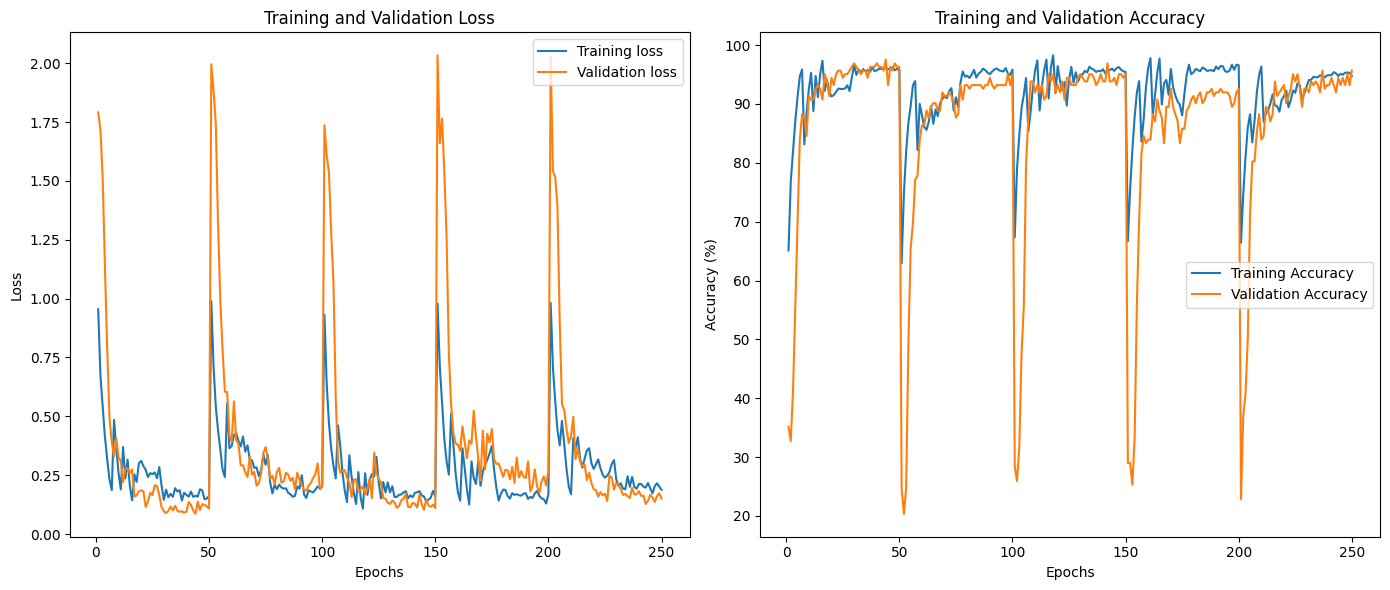

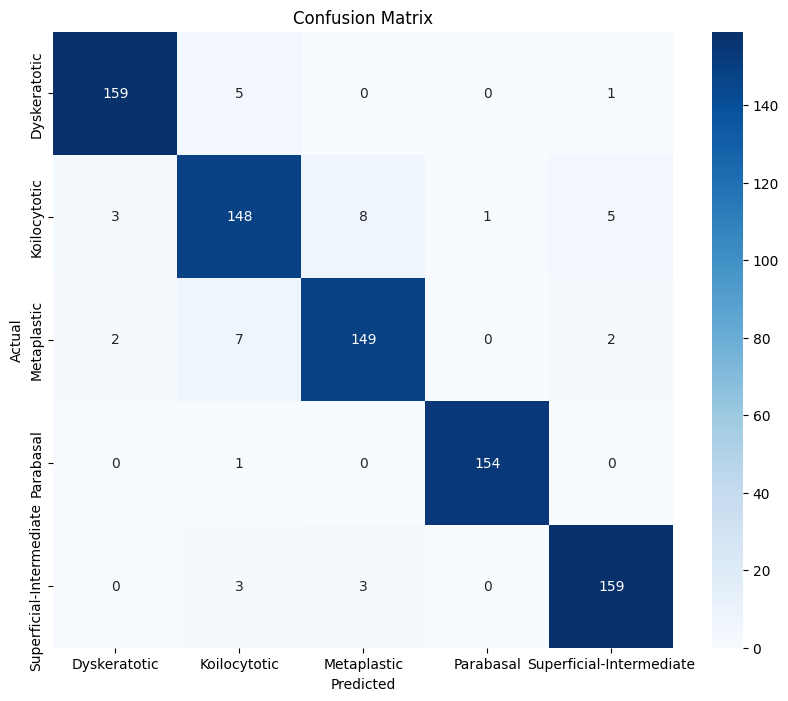

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import transforms
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os


def print_score(y_true, y_pred):
    print('------Weighted------')
    print('Weighted precision', precision_score(y_true, y_pred, average='weighted'))
    print('Weighted recall', recall_score(y_true, y_pred, average='weighted'))
    wf1 = f1_score(y_true, y_pred, average='weighted')
    print('Weighted f1-score', wf1)
    print('------Macro------')
    print('Macro precision', precision_score(y_true, y_pred, average='macro'))
    print('Macro recall', recall_score(y_true, y_pred, average='macro'))
    maf1 = f1_score(y_true, y_pred, average='macro')
    print('Macro f1-score', maf1)
    return wf1, maf1


def is_image_file(filename):
    return filename.endswith('.bmp')


def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(270),
            transforms.RandomAffine(degrees=270, translate=(0.1, 0.1), shear=0.1, scale=(0.98, 1.02)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


def train():
    model.train()
    loss, correct, total = 0.0, 0, 0
    pred_total = None
    y_total = None
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        with autocast():
            scores = model(data)
            current_loss = criterion(scores, targets)

        optimizer.zero_grad()
        scaler.scale(current_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, predictions = torch.max(scores, dim=1)
        loss += current_loss.item()
        total += targets.size(0)
        correct += (predictions == targets).sum().item()
        if pred_total is None:
            pred_total = predictions
            y_total = targets
        else:
            pred_total = torch.concat([pred_total, predictions], dim=0)
            y_total = torch.concat([y_total, targets], dim=0)
    batch_idx += 1
    loss /= batch_idx
    train_acc = 100 * correct / total
    print(f'Train Loss: {loss}')
    print(f'Train Acc ({total}): {train_acc}%')
    print_score(y_total.flatten().cpu(), pred_total.flatten().cpu())
    return loss, train_acc


def val():
    model.eval()
    loss, correct, total = 0.0, 0, 0
    pred_total = []
    y_total = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader)):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            val_loss = criterion(scores, targets)
            _, predictions = torch.max(scores, dim=1)
            loss += val_loss.item()
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
            pred_total.extend(predictions.cpu().numpy())
            y_total.extend(targets.cpu().numpy())
    batch_idx += 1
    loss /= batch_idx
    accuracy = 100 * correct / total
    print(f'Val Loss: {loss}')
    print(f'Val Acc ({total}): {accuracy}%')
    print_score(np.array(y_total), np.array(pred_total))
    return loss, accuracy, y_total, pred_total


if __name__ == "__main__":
    dir = '/kaggle/input/sipakmed-dataset/SIPaKMeD dataset'
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_image_file(path):
                    imgs.append(path)
                    labels.append(class_index)

    skf = StratifiedKFold(n_splits=5)
    test_accuracies = []
    test_losses = []
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    all_preds = []
    all_labels = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(imgs, labels)):
        print(f'Fold {fold + 1}')
        train_imgs, val_imgs = np.array(imgs)[train_idx], np.array(imgs)[val_idx]
        train_labels, val_labels = np.array(labels)[train_idx], np.array(labels)[val_idx]

        # Further split train set to create a small validation set
        train_imgs, val_imgs_inner, train_labels, val_labels_inner = train_test_split(
            train_imgs, train_labels, test_size=0.05, stratify=train_labels
        )
        settings = TolerateLossEpochsPeriod(7e-2)
        train_dataset = MyDataset(train_imgs, train_labels, transform=data_transforms['train'])
        val_dataset = MyDataset(val_imgs_inner, val_labels_inner, transform=data_transforms['val'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = VTCNet(5).to(device)
        initialize_weights(model)
        model = nn.DataParallel(model)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-2)
        scaler = GradScaler()
        train_loss = 1e5
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_acc = 0.0
        best_model_wts = None

        for epoch in range(num_epochs):
            scheduler.step()
            settings.step(train_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_acc = train()
            val_loss, val_acc, _, _ = val()
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_accuracy_list.append(train_acc)
            val_accuracy_list.append(val_acc)

        # Load best model weights from the validation phase
        model.load_state_dict(best_model_wts)

        # Evaluate the model on the final validation set (which serves as the test set for this fold)
        final_val_dataset = MyDataset(val_imgs, val_labels, transform=data_transforms['val'])
        final_val_dataloader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
        test_loss, test_acc, y_true, y_pred = val()

        # Record the test accuracy and loss
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        all_preds.extend(y_pred)
        all_labels.extend(y_true)

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        print(f'Fold {fold + 1}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    # Calculate the average test accuracy, loss, precision, recall, and f1-score across all folds
    average_test_acc = np.mean(test_accuracies)
    average_test_loss = np.mean(test_losses)
    average_precision = np.mean(all_precisions)
    average_recall = np.mean(all_recalls)
    average_f1 = np.mean(all_f1s)

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


Average Test Accuracy: 94.94%, Average Test Loss: 0.1613
Average Precision: 0.9510, Average Recall: 0.9498, Average F1-score: 0.9498


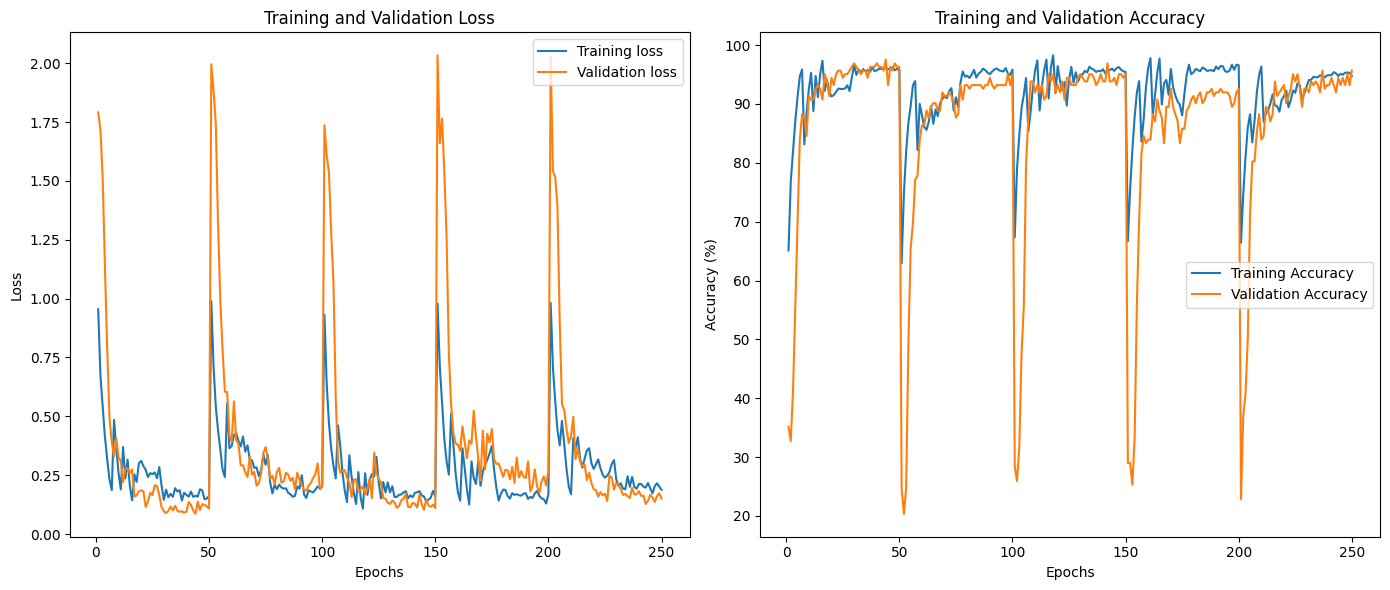

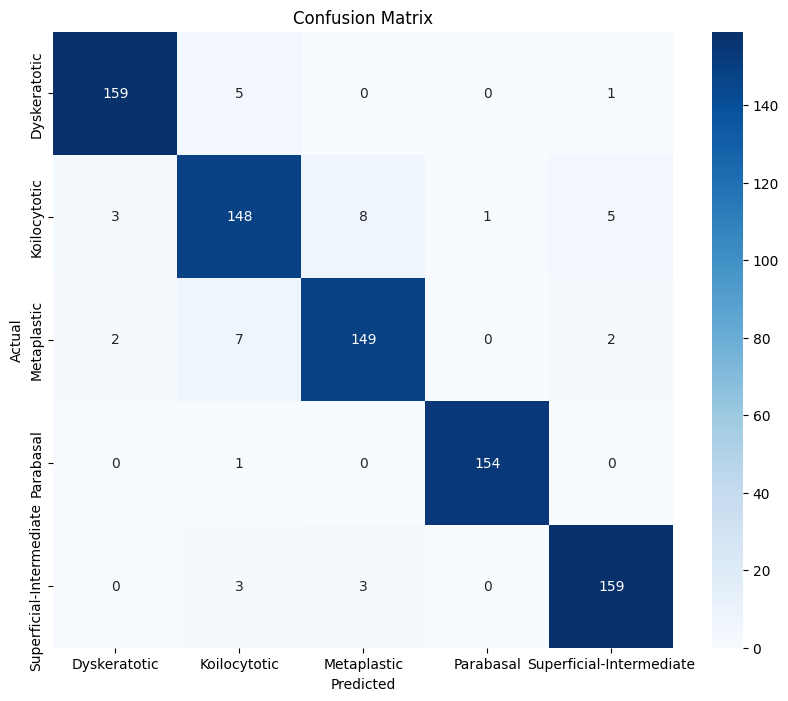

In [18]:

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
